# Projet Maldive

# 0. Preparatory stage

## Set up the libraries

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

import json
import numpy as np
import random
import math



from pprint import pprint
from collections import Counter
from matplotlib.ticker import MaxNLocator
from itertools import tee



from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from trefle.fitness_functions.output_thresholder import round_to_cls
from trefle.trefle_classifier import TrefleClassifier

from trefle_engine import TrefleFIS



import libraries.measures_calculation
import libraries.trefle_project
import libraries.interpretability_methods
import libraries.interpretability_plots
import libraries.results_plot
from libraries.model_var import ModelVar
from libraries.model_train_cv import *

## Split the dataset
<br>
The first step of the ML process is to split our dataset into training and test parts (subsets). <br> 
<ul>
    <li>You must indicate the path of your original dataset</li>
    <li>You must indicate the path where you want to save the training part</li>
    <li>You must indicate the path where you want to save the test part</li>
</ul>
<br>When a plot is "open" you need to "shut it down" in order to plot the others (button on the upper corner right)

    Herbicide
0           0
1           1
2           0
3           1
4           0
..        ...
68          0
69          0
70          0
71          0
72          0

[73 rows x 1 columns]


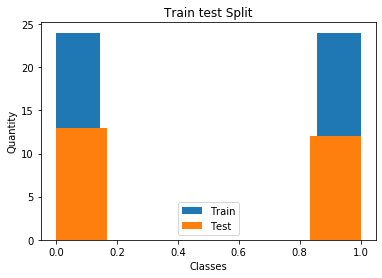

In [6]:
#Read Dataset
#Indicate the path of the original DS HERE:
#--------------------
csv_path_file_name = './datasets/ProtistAmpliconSequenceVariants_ASV_2016.csv'
#--------------------

data_load = pd.read_csv(csv_path_file_name, sep = ';')
target_load = pd.read_csv('./datasets/Env_2016.csv', sep = ';')

#Remove the 0's columns
data_load = data_load.loc[:, (data_load != 0).any(axis=0)]
data_load = data_load.drop(data_load.columns[0], axis=1)
target_load = target_load[['Herbicide']]

# TODO: Changer la colonne à prendre, la lamdba en dessous et lancer ensuite
#target_load['pH'] = target_load['pH'].apply(lambda x: 1 if x <= 7 else 0)
target_load['Herbicide'] = target_load['Herbicide'].apply(lambda x: 1 if x == "yes" else 0)
#target_load['Cu_mg_kg'] = target_load['Cu_mg_kg'].apply(lambda x: 1 if x>100 else 0)

print(target_load)



X = data_load
y = target_load['Herbicide']


#Split it into train test DS
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, stratify=y, random_state=42, test_size=0.33)

plt.hist(y_train, bins='auto', label='Train')

plt.hist(y_test, bins='auto', label='Test')
plt.title("Train test Split")
plt.xlabel('Classes')
plt.ylabel('Quantity')
plt.legend()
plt.show()


#Save separetly in training and test
#It is important to save the training and test sets (we will use the test in the second part)
y_train_modify = np.reshape(y_train, (-1, 1))
train_dataset = np.append(X_train, y_train_modify, axis=1)

y_test_modify = np.reshape(y_test, (-1, 1))
test_dataset = np.append(X_test, y_test_modify, axis=1)

#This indicates to numpy how to format the output (you can create a function for a larger number of variables...)
#format_values = '%1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %i'


#Indicate the path where you want to save the training and test part DS HERE:
#--------------------
path_train_csv = './datasets/data_project_train_v2.csv'
path_test_csv = './datasets/data_project_test_v2.csv'
#--------------------
np.savetxt(path_train_csv, train_dataset, delimiter=";")
np.savetxt(path_test_csv, test_dataset, delimiter=";")


<b style="background-color:red;color:white">Question 1</b>:  Comment the plot above (include it into your report)

## Trefle Classifier
<br> In the code below you have a description of the (fuzzy logic-based) classifier that we use along this labo, the theory is provided in the slides of the cours. <br>
Don't forget to change, if necessary, the number of generations (iterations) of your algorithm. 

In [8]:
# Declare the fitness function we want to use
def fit(y_true, y_pred):
    # Here no need to threshold y_pred because we are using a regression
    # metric
    return -mean_squared_error(y_true, y_pred)

#Initialize our classsifier TREFLE
clf = TrefleClassifier(
    n_rules=10,
    n_classes_per_cons=[2],  # In regression, there is no class (i.e. 0)
    n_labels_per_mf=3,  # use 3 labels LOW, MEDIUM, HIGH
    default_cons=[0],  # default rule yield the class 0
    n_max_vars_per_rule=12,  # WBCD dataset has 30 variables, here we force
    # to use a maximum of 3 variables per rule
    # to have a better interpretability
    # In total we can have up to 3*4=12 different variables
    # for a fuzzy system
    
    #Change here the number of generations (if necessary)
    n_generations=100,
    fitness_function=fit,
    verbose=True,
)

## Training and predicting with Trefle
<br> Below you have a simple example of how to:<br>
<ul>
    <li>train a model and make a prediction with it</li>
    <li>save the model in a file</li>
</ul>

In [9]:
#Make a train
y_sklearn = np.reshape(y_train, (-1, 1))

clf.fit(X_train, y_sklearn)
# Make predictions
y_pred = clf.predict_classes(X_test)

clf.print_best_fuzzy_system()

# Evaluate accuracy
score = f1_score(y_test, y_pred)
print("Score on test set: {:.3f}".format(score))

tff = clf.get_best_fuzzy_system_as_tff()

# Export: save the fuzzy model to disk
with open("my_saved_model_trefle.tff", mode="w") as f:
    f.write(tff)

gen	species	std      	min      	avg      	max    	avg_hof
1  	sp1    	0.0027155	-0.452416	-0.438239	-0.4375	-0.4375
1  	sp2    	0.0319906	-0.565346	-0.47665 	-0.4375	-0.4375
2  	sp1    	0.002976 	-0.458333	-0.438222	-0.4375	-0.4375
2  	sp2    	0.0304508	-0.508647	-0.476232	-0.391129	-0.435568
3  	sp1    	0.00905317	-0.468904	-0.436537	-0.394482	-0.430191
3  	sp2    	0.0471039 	-0.523895	-0.460031	-0.357984	-0.392418
4  	sp1    	0.0278021 	-0.4657  	-0.370453	-0.351376	-0.357121
4  	sp2    	0.0658978 	-0.541667	-0.447241	-0.351376	-0.354631
5  	sp1    	0.0345431 	-0.479167	-0.366569	-0.348323	-0.351121
5  	sp2    	0.0689989 	-0.555471	-0.447497	-0.338633	-0.348965
6  	sp1    	0.0191514 	-0.4375  	-0.3468  	-0.328249	-0.337632
6  	sp2    	0.0675446 	-0.520833	-0.438804	-0.311809	-0.333968
7  	sp1    	0.02298   	-0.408572	-0.323449	-0.300967	-0.310191
7  	sp2    	0.0841263 	-0.520833	-0.410935	-0.300967	-0.305222
8  	sp1    	0.0216456 	-0.39773 	-0.308764	-0.299094	-0.300701
8  	sp2    	0

66 	sp1    	0.00230942	-0.169035	-0.157404	-0.15625 	-0.15625 
66 	sp2    	0.135067  	-0.532851	-0.392692	-0.15625 	-0.15625 
67 	sp1    	0.00179367	-0.168482	-0.156949	-0.15625 	-0.15625 
67 	sp2    	0.140514  	-0.541667	-0.382758	-0.151386	-0.155927
68 	sp1    	0.00293574	-0.164171	-0.153112	-0.151091	-0.151374
68 	sp2    	0.13271   	-0.552517	-0.378376	-0.148025	-0.151234
69 	sp1    	0.00623179	-0.184299	-0.150359	-0.145833	-0.147798
69 	sp2    	0.146507  	-0.690833	-0.376899	-0.145833	-0.147798
70 	sp1    	0.00928857	-0.185946	-0.149654	-0.145833	-0.145833
70 	sp2    	0.144124  	-0.705197	-0.366214	-0.145833	-0.145833
71 	sp1    	0.00443769	-0.162612	-0.148676	-0.145833	-0.145833
71 	sp2    	0.148393  	-0.679533	-0.35721 	-0.145833	-0.145833
72 	sp1    	0.00865269	-0.182454	-0.149661	-0.145833	-0.145833
72 	sp2    	0.13457   	-0.520833	-0.386329	-0.145833	-0.145833
73 	sp1    	0.00756443	-0.182454	-0.149033	-0.145833	-0.145833
73 	sp2    	0.144486  	-0.628852	-0.355932	-0.145833	-0

## 1.2 Model-parameter search

Now that the fitness function have been defined, we may search values for other parameters of the algorithm. In this part we will focus on the size (complexity) of the model, represented by the number of rules and the number of variables per rule.

<b style="background-color:red;color:white">Question 5</b>: Explain what are the implications of these two parameters (i.e., number of rules and number of variables per rule) on the models, in terms of both performance and interpretability.
<br>
<b style="background-color:red;color:white">Question 6</b>: If you have setted your algorithm up to use 6 rules and 5 variables per rule on a dataset composeed of 100 features, how many features could be used at most by a model?
<br>

** Important:** Before continuing, don't forget to set the right weights for sensitivity, specificity, and RMSE!

### Coarse estimation of the model size
Not knowing the complexity of the required models, we must first roughly estimate them. This is done by exploring a relatively large range of model sizes. Performing a grid search (i.e., exploring both parameters simultaneously) would be the best approach, but that may be extremely costly and time consuming. Instead, we will explore one of the parameters, the number of rules. 

** Note:** Before performing the experiments, don't forget to set the values for the <b>rules_number_vec</b>. They represent the number of rules, pay attention to the size of the model. Don't change the value of 'var_per_rule_fix'.

<b style="background-color:red;color:white">Question 7</b>: In your opinion, why did we decide to first explore the number of rules instead of the number of variables per rule?
<br>
<b style="background-color:red;color:white">Question 8</b>: Which values have you decided to test at this stage? Why this range?
<br>


In [11]:
%load_ext autoreload
%autoreload

##############fitness function
def fit (y_true, y_pred):
    
    y_pred_bin = round_to_cls(y_pred, n_classes=2)
    tn, fp, fn, tp = libraries.trefle_project.getConfusionMatrixValues(y_true, y_pred_bin)

    return libraries.measures_calculation.calculateF1(tn, fp, fn, tp)

clf.fitness_function=fit
###############

#Path where you want to save yours models (you need to create the directory befor start the algorithm)
path_save_results_directory = 'experiences/n_rules/'
#file nam that will contain the results for each model create (so fo each fold)
file_results_dv = 'values_number_of_rules.csv'
#Name of the experience, this name will appear on the models files
experience_value_name = 'exps_lab_lfa_number_of_rules'


#Perform Cross-validation
#Change here the number of folds (if necessary)
k_fold_number = 5
cv_kf = KFold(n_splits=k_fold_number, random_state=42, shuffle=True)
array_index_train_test = cv_kf.split(X_train)
array_index_train_test, array_index_train_test_copy = tee(array_index_train_test)

model_train_obj = ModelTrain(array_index_train_test = array_index_train_test,
                             X_train = X_train,
                             y_train = y_train, 
                             number_rule = 0, var_per_rule = 0, 
                             classifier_trefle = clf, 
                             path_save_results = path_save_results_directory,
                            path_save_results_values=file_results_dv,
                            experience_name = experience_value_name)


#Here we can choose wich values for the number of rules and maximum variable per 
#rule we want to test along our experience ('here you need to change and explain your choice, on the repport')
#--------------------
rules_number_vec = [3,5, 7,10]
var_per_rule_fix = 4
#--------------------

for qty_of_rule in rules_number_vec:
    model_train_obj.number_rule = qty_of_rule
    model_train_obj.var_per_rule = var_per_rule_fix
    model_train_obj.execute_cv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
gen	species	std        	min     	avg     	max     	avg_hof 
1  	sp1    	1.11022e-16	0.701754	0.701754	0.701754	0.701754
1  	sp2    	0.302698   	0       	0.354009	0.703704	0.701836
2  	sp1    	0.000370338	0.701754	0.703631	0.703704	0.703704
2  	sp2    	0.299802   	0       	0.460845	0.703704	0.703704
3  	sp1    	1.11022e-16	0.703704	0.703704	0.703704	0.703704
3  	sp2    	0.284135   	0       	0.492291	0.714286	0.704586
4  	sp1    	0          	0.714286	0.714286	0.714286	0.714286
4  	sp2    	0.281399   	0       	0.508051	0.727273	0.715319
5  	sp1    	0.00785921 	0.703704	0.724116	0.727273	0.727273
5  	sp2    	0.278007   	0       	0.532781	0.740741	0.727834
6  	sp1    	0.00740529 	0.714286	0.721609	0.740741	0.728956
6  	sp2    	0.252766   	0       	0.56881 	0.740741	0.730079
7  	sp1    	0.00149633 	0.727273	0.740572	0.740741	0.740741
7  	sp2    	0.249183   	0       	0.57994 	0.740741	0.740741
8  	sp1    	

68 	sp2    	0.284611   	0       	0.59166 	0.851064	0.851064
69 	sp1    	0.0258986  	0.769231	0.813782	0.851064	0.851064
69 	sp2    	0.241206   	0       	0.638566	0.851064	0.851064
70 	sp1    	0.0208439  	0.772727	0.822661	0.851064	0.851064
70 	sp2    	0.259437   	0       	0.617767	0.851064	0.851064
71 	sp1    	0.0156462  	0.772727	0.827472	0.851064	0.851064
71 	sp2    	0.289884   	0       	0.607085	0.851064	0.851064
72 	sp1    	0.0147375  	0.808511	0.83503 	0.851064	0.851064
72 	sp2    	0.24925    	0       	0.637297	0.851064	0.851064
73 	sp1    	0.0230174  	0.769231	0.824382	0.851064	0.851064
73 	sp2    	0.313177   	0       	0.579404	0.851064	0.851064
74 	sp1    	0.0166007  	0.772727	0.832857	0.851064	0.851064
74 	sp2    	0.303771   	0       	0.593927	0.851064	0.851064
75 	sp1    	0.0195712  	0.772727	0.827297	0.851064	0.851064
75 	sp2    	0.32403    	0       	0.550861	0.851064	0.851064
76 	sp1    	0.0190707  	0.772727	0.828819	0.851064	0.851064
76 	sp2    	0.307642   	0       	0.56343

36 	sp2    	0.314318   	0       	0.475583	0.818182	0.813492
37 	sp1    	0.0204431  	0.731707	0.794641	0.818182	0.817821
37 	sp2    	0.279444   	0       	0.543663	0.818182	0.817821
38 	sp1    	0.0264288  	0.708333	0.793526	0.829268	0.818644
38 	sp2    	0.267347   	0       	0.561883	0.829268	0.818644
39 	sp1    	0.0184319  	0.75    	0.800156	0.829268	0.82003 
39 	sp2    	0.263581   	0       	0.577111	0.829268	0.82003 
40 	sp1    	0.0332057  	0.7     	0.791644	0.829268	0.820953
40 	sp2    	0.264454   	0       	0.585969	0.829268	0.820953
41 	sp1    	0.0369739  	0.7     	0.789123	0.829268	0.822339
41 	sp2    	0.261859   	0       	0.58758 	0.829268	0.822801
42 	sp1    	0.036525   	0.690909	0.783484	0.829268	0.829268
42 	sp2    	0.281705   	0       	0.574455	0.829268	0.829268
43 	sp1    	0.0390514  	0.65    	0.789633	0.829268	0.829268
43 	sp2    	0.302093   	0       	0.525997	0.829268	0.829268
44 	sp1    	0.0390939  	0.679245	0.795338	0.829268	0.829268
44 	sp2    	0.312031   	0       	0.51676

5  	sp1    	0.0144826	0.641509	0.657642	0.68    	0.672222
5  	sp2    	0.218884 	0       	0.501073	0.68    	0.672222
6  	sp1    	0.0126915	0.641509	0.659757	0.68    	0.676111
6  	sp2    	0.224182 	0       	0.494877	0.68    	0.676667
7  	sp1    	0.0143476	0.641509	0.660345	0.68    	0.68    
7  	sp2    	0.238917 	0       	0.492358	0.68    	0.68    
8  	sp1    	0.0161715	0.641509	0.65995 	0.68    	0.68    
8  	sp2    	0.214799 	0       	0.525154	0.68    	0.68    
9  	sp1    	0.0140054	0.641509	0.662097	0.68    	0.68    
9  	sp2    	0.259803 	0       	0.458257	0.68    	0.68    
10 	sp1    	0.0159703	0.641509	0.66251 	0.68    	0.68    
10 	sp2    	0.248286 	0       	0.494903	0.68    	0.68    
11 	sp1    	0.00883257	0.653846	0.669244	0.68    	0.68    
11 	sp2    	0.236711  	0       	0.519408	0.68    	0.68    
12 	sp1    	0.00832481	0.653846	0.673872	0.68    	0.68    
12 	sp2    	0.199773  	0       	0.552203	0.723404	0.681809
13 	sp1    	0.020748  	0.666667	0.699597	0.744186	0.72546 
13 	sp2  

75 	sp1    	0.0569855 	0.642857	0.865571	0.918919	0.918919
75 	sp2    	0.294273  	0       	0.570877	0.918919	0.918919
76 	sp1    	0.0634929 	0.62069 	0.860134	0.918919	0.918919
76 	sp2    	0.309547  	0       	0.536355	0.918919	0.918919
77 	sp1    	0.0680755 	0.62069 	0.855476	0.918919	0.918919
77 	sp2    	0.313596  	0       	0.542215	0.918919	0.918919
78 	sp1    	0.0685645 	0.622222	0.863756	0.918919	0.918919
78 	sp2    	0.333833  	0       	0.533159	0.918919	0.918919
79 	sp1    	0.0767228 	0.642857	0.85158 	0.918919	0.918919
79 	sp2    	0.322191  	0       	0.533814	0.918919	0.918919
80 	sp1    	0.0714268 	0.642857	0.863205	0.918919	0.918919
80 	sp2    	0.310322  	0       	0.541486	0.918919	0.918919
81 	sp1    	0.0751221 	0.622222	0.857908	0.918919	0.918919
81 	sp2    	0.306749  	0       	0.557211	0.918919	0.918919
82 	sp1    	0.075489  	0.62069 	0.860497	0.918919	0.918919
82 	sp2    	0.318935  	0       	0.501646	0.918919	0.918919
83 	sp1    	0.0615553 	0.642857	0.867739	0.918919	0.9189

44 	sp2    	0.294282  	0       	0.521264	0.8     	0.8     
45 	sp1    	0.0337193 	0.701754	0.770059	0.8     	0.8     
45 	sp2    	0.298444  	0       	0.524727	0.8     	0.8     
46 	sp1    	0.0459445 	0.615385	0.761801	0.8     	0.8     
46 	sp2    	0.286126  	0       	0.530198	0.816327	0.80068 
47 	sp1    	0.0241318 	0.723404	0.77472 	0.816327	0.802041
47 	sp2    	0.262869  	0       	0.581521	0.816327	0.802721
48 	sp1    	0.0376716 	0.666667	0.753533	0.816327	0.809524
48 	sp2    	0.303337  	0       	0.513048	0.816327	0.810204
49 	sp1    	0.0381627 	0.689655	0.758544	0.816327	0.816327
49 	sp2    	0.299683  	0       	0.526876	0.816327	0.816327
50 	sp1    	0.0427397 	0.666667	0.762672	0.816327	0.816327
50 	sp2    	0.24065   	0       	0.603162	0.816327	0.816327
51 	sp1    	0.0300507 	0.723404	0.769027	0.816327	0.816327
51 	sp2    	0.283027  	0       	0.567511	0.816327	0.816327
52 	sp1    	0.0442081 	0.65    	0.762682	0.816327	0.816327
52 	sp2    	0.286514  	0       	0.55513 	0.816327	0.8163

13 	sp1    	0.0168569  	0.701754 	0.754394	0.769231	0.769231
13 	sp2    	0.267265   	0        	0.547589	0.769231	0.769231
14 	sp1    	0.0163578  	0.705882 	0.751395	0.769231	0.769231
14 	sp2    	0.26739    	0        	0.543484	0.769231	0.769231
15 	sp1    	0.0154584  	0.701754 	0.753126	0.769231	0.769231
15 	sp2    	0.262741   	0        	0.561764	0.784314	0.769859
16 	sp1    	0.0156707  	0.727273 	0.765776	0.784314	0.784314
16 	sp2    	0.285206   	0        	0.536315	0.784314	0.784314
17 	sp1    	0.0156193  	0.727273 	0.766517	0.784314	0.784314
17 	sp2    	0.26493    	0        	0.559489	0.784314	0.784314
18 	sp1    	0.0144935  	0.727273 	0.765613	0.784314	0.784314
18 	sp2    	0.238012   	0        	0.592377	0.784314	0.784314
19 	sp1    	0.0150799  	0.727273 	0.76951 	0.784314	0.784314
19 	sp2    	0.287511   	0        	0.51134 	0.784314	0.784314
20 	sp1    	0.0157202  	0.727273 	0.768449	0.784314	0.784314
20 	sp2    	0.275175   	0        	0.548166	0.784314	0.784314
21 	sp1    	0.018352   	

80 	sp2    	0.307046   	0        	0.547002	0.869565	0.869565
81 	sp1    	0.0287557  	0.754717 	0.835991	0.869565	0.869565
81 	sp2    	0.289323   	0        	0.568969	0.869565	0.869565
82 	sp1    	0.0255762  	0.76     	0.841825	0.869565	0.869565
82 	sp2    	0.256476   	0        	0.592412	0.869565	0.869565
83 	sp1    	0.0246044  	0.754717 	0.842592	0.869565	0.869565
83 	sp2    	0.328136   	0        	0.535913	0.869565	0.869565
84 	sp1    	0.0213159  	0.791667 	0.847087	0.869565	0.869565
84 	sp2    	0.304021   	0        	0.544576	0.869565	0.869565
85 	sp1    	0.0266817  	0.754717 	0.84535 	0.869565	0.869565
85 	sp2    	0.295712   	0        	0.568779	0.869565	0.869565
86 	sp1    	0.0281468  	0.769231 	0.84276 	0.869565	0.869565
86 	sp2    	0.26652    	0        	0.616131	0.869565	0.869565
87 	sp1    	0.0234168  	0.769231 	0.844243	0.869565	0.869565
87 	sp2    	0.308507   	0        	0.560777	0.869565	0.869565
88 	sp1    	0.0224131  	0.769231 	0.844994	0.869565	0.869565
88 	sp2    	0.27755    	

49 	sp1    	0.0288117 	0.8     	0.851131	0.883721	0.883721
49 	sp2    	0.292336  	0       	0.571293	0.883721	0.883721
50 	sp1    	0.0272119 	0.8     	0.849944	0.883721	0.883721
50 	sp2    	0.290737  	0       	0.575396	0.883721	0.883721
51 	sp1    	0.0266606 	0.8     	0.853993	0.883721	0.883721
51 	sp2    	0.256906  	0       	0.620349	0.883721	0.883721
52 	sp1    	0.0266502 	0.8     	0.85529 	0.883721	0.883721
52 	sp2    	0.247275  	0       	0.633014	0.883721	0.883721
53 	sp1    	0.0268316 	0.790698	0.857758	0.883721	0.883721
53 	sp2    	0.308089  	0       	0.551957	0.883721	0.883721
54 	sp1    	0.0271453 	0.784314	0.854602	0.883721	0.883721
54 	sp2    	0.283853  	0       	0.591881	0.883721	0.883721
55 	sp1    	0.0222235 	0.8     	0.85067 	0.883721	0.883721
55 	sp2    	0.334439  	0       	0.526377	0.883721	0.883721
56 	sp1    	0.0245618 	0.8     	0.849994	0.883721	0.883721
56 	sp2    	0.335791  	0       	0.519912	0.883721	0.883721
57 	sp1    	0.0274495 	0.772727	0.853622	0.883721	0.8837

18 	sp2    	0.266577   	0       	0.562853	0.809524	0.809524
19 	sp1    	0.0338291  	0.711111	0.770459	0.837209	0.810677
19 	sp2    	0.275489   	0       	0.554342	0.837209	0.810677
20 	sp1    	0.0353678  	0.684211	0.750661	0.837209	0.810677
20 	sp2    	0.293828   	0       	0.50274 	0.837209	0.810677
21 	sp1    	0.0333571  	0.693878	0.775842	0.837209	0.810677
21 	sp2    	0.276933   	0       	0.533725	0.837209	0.810677
22 	sp1    	0.0259613  	0.72    	0.790375	0.837209	0.811831
22 	sp2    	0.288322   	0       	0.52957 	0.837209	0.811831
23 	sp1    	0.0307965  	0.716981	0.777689	0.837209	0.811831
23 	sp2    	0.292951   	0       	0.532869	0.837209	0.811831
24 	sp1    	0.0413611  	0.682927	0.775823	0.837209	0.821059
24 	sp2    	0.269846   	0       	0.584581	0.837209	0.821059
25 	sp1    	0.034041   	0.693878	0.794589	0.837209	0.829134
25 	sp2    	0.269444   	0       	0.586937	0.837209	0.829134
26 	sp1    	0.0318594  	0.72    	0.800409	0.837209	0.837209
26 	sp2    	0.264351   	0       	0.57146

87 	sp1    	0.0361512  	0.72    	0.820664	0.857143	0.857143
87 	sp2    	0.291647   	0       	0.548813	0.857143	0.857143
88 	sp1    	0.0356089  	0.734694	0.823545	0.857143	0.857143
88 	sp2    	0.303377   	0       	0.533868	0.857143	0.857143
89 	sp1    	0.0340891  	0.723404	0.819766	0.857143	0.857143
89 	sp2    	0.282727   	0       	0.577086	0.857143	0.857143
90 	sp1    	0.0376938  	0.730769	0.822884	0.857143	0.857143
90 	sp2    	0.262854   	0       	0.60095 	0.857143	0.857143
91 	sp1    	0.0381885  	0.730769	0.82392 	0.857143	0.857143
91 	sp2    	0.23373    	0       	0.60525 	0.857143	0.857143
92 	sp1    	0.0313999  	0.734694	0.829687	0.857143	0.857143
92 	sp2    	0.264435   	0       	0.564538	0.857143	0.857143
93 	sp1    	0.0371778  	0.734694	0.820551	0.857143	0.857143
93 	sp2    	0.300421   	0       	0.504978	0.857143	0.857143
94 	sp1    	0.0333719  	0.734694	0.828002	0.857143	0.857143
94 	sp2    	0.316929   	0       	0.485591	0.857143	0.857143
95 	sp1    	0.0348947  	0.734694	0.82397

55 	sp1    	0.0583858  	0.645161	0.811678	0.871795	0.871795
55 	sp2    	0.314206   	0       	0.517571	0.871795	0.871795
56 	sp1    	0.0650358  	0.62069 	0.82186 	0.871795	0.871795
56 	sp2    	0.277364   	0       	0.585957	0.871795	0.871795
57 	sp1    	0.0764722  	0.62069 	0.799539	0.871795	0.871795
57 	sp2    	0.298501   	0       	0.526447	0.871795	0.871795
58 	sp1    	0.0615861  	0.625   	0.807822	0.871795	0.871795
58 	sp2    	0.282962   	0       	0.567308	0.871795	0.871795
59 	sp1    	0.0782127  	0.62963 	0.796164	0.871795	0.871795
59 	sp2    	0.289127   	0       	0.52942 	0.871795	0.871795
60 	sp1    	0.0731937  	0.571429	0.801175	0.871795	0.871795
60 	sp2    	0.295618   	0       	0.536814	0.871795	0.871795
61 	sp1    	0.0679424  	0.62069 	0.808691	0.871795	0.871795
61 	sp2    	0.280707   	0       	0.531513	0.871795	0.871795
62 	sp1    	0.0878824  	0.571429	0.79046 	0.871795	0.871795
62 	sp2    	0.275742   	0       	0.549544	0.871795	0.871795
63 	sp1    	0.0944658  	0.576923	0.77061

22 	sp2    	0.293489   	0        	0.506678	0.769231	0.769231
23 	sp1    	0.0210876  	0.705882 	0.744562	0.769231	0.769231
23 	sp2    	0.292561   	0        	0.509771	0.769231	0.769231
24 	sp1    	0.0217303  	0.705882 	0.743251	0.769231	0.769231
24 	sp2    	0.305405   	0        	0.491013	0.769231	0.769231
25 	sp1    	0.0216728  	0.705882 	0.745635	0.769231	0.769231
25 	sp2    	0.273733   	0        	0.562477	0.769231	0.769231
26 	sp1    	0.0195767  	0.705882 	0.746459	0.769231	0.769231
26 	sp2    	0.307084   	0        	0.485012	0.769231	0.769231
27 	sp1    	0.0188204  	0.705882 	0.746823	0.769231	0.769231
27 	sp2    	0.309849   	0        	0.485279	0.769231	0.769231
28 	sp1    	0.0169438  	0.705882 	0.750923	0.769231	0.769231
28 	sp2    	0.29341    	0        	0.517185	0.769231	0.769231
29 	sp1    	0.0162514  	0.705882 	0.752117	0.769231	0.769231
29 	sp2    	0.286358   	0        	0.533726	0.769231	0.769231
30 	sp1    	0.0175271  	0.705882 	0.7512  	0.769231	0.769231
30 	sp2    	0.286378   	

90 	sp1    	0.0464321  	0.677966 	0.788176	0.833333	0.833333
90 	sp2    	0.342145   	0        	0.451475	0.833333	0.833333
91 	sp1    	0.0344162  	0.711111 	0.80586 	0.833333	0.833333
91 	sp2    	0.2842     	0        	0.574928	0.833333	0.833333
92 	sp1    	0.0310189  	0.714286 	0.806376	0.833333	0.833333
92 	sp2    	0.296346   	0        	0.546409	0.833333	0.833333
93 	sp1    	0.028793   	0.727273 	0.808785	0.833333	0.833333
93 	sp2    	0.317647   	0        	0.488544	0.833333	0.833333
94 	sp1    	0.0364985  	0.711111 	0.802464	0.833333	0.833333
94 	sp2    	0.295621   	0        	0.531026	0.833333	0.833333
95 	sp1    	0.0371336  	0.711111 	0.798349	0.833333	0.833333
95 	sp2    	0.267744   	0        	0.584605	0.833333	0.833333
96 	sp1    	0.039092   	0.681818 	0.793709	0.833333	0.833333
96 	sp2    	0.263431   	0        	0.595311	0.833333	0.833333
97 	sp1    	0.0332918  	0.705882 	0.802521	0.851064	0.834072
97 	sp2    	0.281133   	0        	0.590091	0.851064	0.834072
98 	sp1    	0.0396324  	

58 	sp2    	0.276989   	0       	0.553921	0.816327	0.816327
59 	sp1    	0.028899   	0.714286	0.785248	0.816327	0.816327
59 	sp2    	0.272757   	0       	0.57184 	0.816327	0.816327
60 	sp1    	0.0274844  	0.708333	0.786195	0.816327	0.816327
60 	sp2    	0.246273   	0       	0.598843	0.816327	0.816327
61 	sp1    	0.0155172  	0.754717	0.795106	0.816327	0.816327
61 	sp2    	0.26091    	0       	0.579307	0.816327	0.816327
62 	sp1    	0.0291418  	0.708333	0.779745	0.816327	0.816327
62 	sp2    	0.285158   	0       	0.559318	0.816327	0.816327
63 	sp1    	0.0284805  	0.705882	0.776035	0.816327	0.816327
63 	sp2    	0.291556   	0       	0.554393	0.816327	0.816327
64 	sp1    	0.0240832  	0.723404	0.774039	0.816327	0.816327
64 	sp2    	0.288264   	0       	0.547711	0.816327	0.816327
65 	sp1    	0.0275956  	0.666667	0.775682	0.816327	0.816327
65 	sp2    	0.29257    	0       	0.548958	0.816327	0.816327
66 	sp1    	0.0161998  	0.761905	0.803736	0.833333	0.820892
66 	sp2    	0.318608   	0       	0.48623

27 	sp1    	0.0227308 	0.703704	0.774164	0.8     	0.8     
27 	sp2    	0.255755  	0       	0.577875	0.8     	0.8     
28 	sp1    	0.0260685 	0.705882	0.77339 	0.8     	0.8     
28 	sp2    	0.279657  	0       	0.547164	0.8     	0.8     
29 	sp1    	0.0152889 	0.745098	0.784041	0.8     	0.8     
29 	sp2    	0.297532  	0       	0.484314	0.8     	0.8     
30 	sp1    	0.015867  	0.754717	0.783274	0.8     	0.8     
30 	sp2    	0.289554  	0       	0.528084	0.8     	0.8     
31 	sp1    	0.0176975 	0.727273	0.782696	0.8     	0.8     
31 	sp2    	0.215656  	0       	0.607891	0.8     	0.8     
32 	sp1    	0.0168178 	0.740741	0.778608	0.8     	0.8     
32 	sp2    	0.211904  	0       	0.610912	0.8     	0.8     
33 	sp1    	0.0163762 	0.740741	0.780476	0.8     	0.8     
33 	sp2    	0.251856  	0       	0.581011	0.8     	0.8     
34 	sp1    	0.0172067 	0.740741	0.780344	0.8     	0.8     
34 	sp2    	0.225353  	0       	0.615837	0.8     	0.8     
35 	sp1    	0.012701  	0.76    	0.789879	0.8     	0.8   

96 	sp2    	0.25133   	0       	0.592412	0.816327	0.816327
97 	sp1    	0.0177025 	0.727273	0.799255	0.816327	0.816327
97 	sp2    	0.272516  	0       	0.56313 	0.816327	0.816327
98 	sp1    	0.0221807 	0.727273	0.796997	0.816327	0.816327
98 	sp2    	0.218185  	0       	0.630162	0.816327	0.816327
99 	sp1    	0.0183286 	0.727273	0.801328	0.816327	0.816327
99 	sp2    	0.215537  	0       	0.622788	0.816327	0.816327
100	sp1    	0.0157543 	0.754717	0.801864	0.816327	0.816327
100	sp2    	0.258636  	0       	0.594545	0.816327	0.816327
save end
gen	species	std      	min     	avg     	max     	avg_hof 
1  	sp1    	0.0119447	0.603774	0.620467	0.642857	0.657989
1  	sp2    	0.26644  	0       	0.471722	0.730769	0.691475
2  	sp1    	0.00978721	0.690909	0.71375 	0.730769	0.722726
2  	sp2    	0.264603  	0       	0.516963	0.730769	0.723301
3  	sp1    	0.0135756 	0.690909	0.719537	0.730769	0.730769
3  	sp2    	0.261111  	0       	0.534169	0.734694	0.730933
4  	sp1    	0.0135023 	0.690909	0.72029 	0.734694	

65 	sp2    	0.237184  	0       	0.60425 	0.883721	0.883721
66 	sp1    	0.0571302 	0.666667	0.814515	0.883721	0.883721
66 	sp2    	0.291062  	0       	0.535931	0.883721	0.883721
67 	sp1    	0.0532864 	0.666667	0.817054	0.883721	0.883721
67 	sp2    	0.262768  	0       	0.565629	0.883721	0.883721
68 	sp1    	0.0620473 	0.6     	0.808582	0.883721	0.883721
68 	sp2    	0.266546  	0       	0.584521	0.883721	0.883721
69 	sp1    	0.0622255 	0.666667	0.809289	0.883721	0.883721
69 	sp2    	0.254094  	0       	0.588633	0.883721	0.883721
70 	sp1    	0.0640649 	0.666667	0.807846	0.883721	0.883721
70 	sp2    	0.282207  	0       	0.543627	0.883721	0.883721
71 	sp1    	0.0554954 	0.681818	0.809403	0.883721	0.883721
71 	sp2    	0.2377    	0       	0.586929	0.883721	0.883721
72 	sp1    	0.0630955 	0.690909	0.800375	0.883721	0.883721
72 	sp2    	0.283225  	0       	0.543328	0.883721	0.883721
73 	sp1    	0.0712205 	0.641509	0.79831 	0.883721	0.883721
73 	sp2    	0.281488  	0       	0.550967	0.883721	0.8837

34 	sp1    	0.0253849  	0.666667	0.75659 	0.772727	0.772727
34 	sp2    	0.268526   	0       	0.506495	0.772727	0.772727
35 	sp1    	0.0227647  	0.684211	0.759282	0.772727	0.772727
35 	sp2    	0.269006   	0       	0.506942	0.772727	0.772727
36 	sp1    	0.029755   	0.634146	0.755818	0.772727	0.772727
36 	sp2    	0.286544   	0       	0.45365 	0.772727	0.772727
37 	sp1    	0.030416   	0.634146	0.753095	0.772727	0.772727
37 	sp2    	0.246518   	0       	0.542108	0.790698	0.773476
38 	sp1    	0.020774   	0.723404	0.773725	0.829268	0.796227
38 	sp2    	0.243507   	0       	0.561483	0.829268	0.796227
39 	sp1    	0.0230351  	0.723404	0.774516	0.829268	0.799403
39 	sp2    	0.287853   	0       	0.509278	0.829268	0.800187
40 	sp1    	0.02984    	0.693878	0.770537	0.829268	0.808146
40 	sp2    	0.264964   	0       	0.529351	0.829268	0.808931
41 	sp1    	0.035425   	0.666667	0.77471 	0.829268	0.816105
41 	sp2    	0.251186   	0       	0.545295	0.829268	0.816105
42 	sp1    	0.0381855  	0.666667	0.77839

2  	sp2    	0.272494	0       	0.508665	0.727273	0.702565
3  	sp1    	0.00622495	0.701754	0.717881	0.740741	0.726119
3  	sp2    	0.257038  	0       	0.53244 	0.740741	0.726547
4  	sp1    	0.0126951 	0.689655	0.718606	0.740741	0.729517
4  	sp2    	0.256262  	0       	0.53957 	0.740741	0.729517
5  	sp1    	0.0138492 	0.689655	0.718954	0.740741	0.732323
5  	sp2    	0.254776  	0       	0.54049 	0.76    	0.734248
6  	sp1    	0.0238282 	0.689655	0.727293	0.76    	0.75317 
6  	sp2    	0.252157  	0       	0.516544	0.76    	0.75317 
7  	sp1    	0.00789437	0.727273	0.744205	0.76    	0.756895
7  	sp2    	0.254628  	0       	0.534555	0.76    	0.757296
8  	sp1    	0.0104824 	0.714286	0.748604	0.76    	0.76    
8  	sp2    	0.266648  	0       	0.524878	0.76    	0.76    
9  	sp1    	0.0125351 	0.714286	0.748108	0.76    	0.76    
9  	sp2    	0.228995  	0       	0.575648	0.76    	0.76    
10 	sp1    	0.0114485 	0.714286	0.74813 	0.76    	0.76    
10 	sp2    	0.247172  	0       	0.53095 	0.76    	0.76    

72 	sp1    	0.025664  	0.75    	0.819392	0.878049	0.850443
72 	sp2    	0.271363  	0       	0.533818	0.878049	0.852043
73 	sp1    	0.0283905 	0.75    	0.820563	0.878049	0.854843
73 	sp2    	0.277026  	0       	0.545841	0.878049	0.856442
74 	sp1    	0.0262673 	0.772727	0.823571	0.878049	0.858074
74 	sp2    	0.238476  	0       	0.588763	0.878049	0.859673
75 	sp1    	0.0301033 	0.75    	0.820414	0.878049	0.862705
75 	sp2    	0.26314   	0       	0.549139	0.878049	0.864305
76 	sp1    	0.0343272 	0.723404	0.822658	0.878049	0.869971
76 	sp2    	0.280368  	0       	0.534831	0.878049	0.870242
77 	sp1    	0.0369876 	0.723404	0.820943	0.883721	0.874318
77 	sp2    	0.260307  	0       	0.561952	0.883721	0.874318
78 	sp1    	0.0337737 	0.765957	0.835037	0.883721	0.87923 
78 	sp2    	0.296982  	0       	0.506969	0.883721	0.87923 
79 	sp1    	0.0308842 	0.761905	0.844627	0.883721	0.880412
79 	sp2    	0.269015  	0       	0.542543	0.883721	0.880412
80 	sp1    	0.0294348 	0.772727	0.842929	0.883721	0.8820

40 	sp2    	0.297778   	0       	0.502058	0.816327	0.816327
41 	sp1    	0.0282871  	0.708333	0.772988	0.816327	0.816327
41 	sp2    	0.263333   	0       	0.575867	0.816327	0.816327
42 	sp1    	0.0244035  	0.730769	0.777766	0.816327	0.816327
42 	sp2    	0.26384    	0       	0.558697	0.816327	0.816327
43 	sp1    	0.0251438  	0.730769	0.780577	0.816327	0.816327
43 	sp2    	0.276596   	0       	0.534183	0.816327	0.816327
44 	sp1    	0.0233364  	0.727273	0.781908	0.816327	0.816327
44 	sp2    	0.298184   	0       	0.525736	0.816327	0.816327
45 	sp1    	0.0250452  	0.708333	0.781036	0.816327	0.816327
45 	sp2    	0.256102   	0       	0.571277	0.816327	0.816327
46 	sp1    	0.023749   	0.723404	0.779109	0.816327	0.816327
46 	sp2    	0.235768   	0       	0.584848	0.816327	0.816327
47 	sp1    	0.023342   	0.730769	0.783532	0.816327	0.816327
47 	sp2    	0.263868   	0       	0.553207	0.816327	0.816327
48 	sp1    	0.0278159  	0.705882	0.778206	0.816327	0.816327
48 	sp2    	0.243876   	0       	0.58590

8  	sp2    	0.305591  	0       	0.481566	0.784314	0.784314
9  	sp1    	0.0167129 	0.727273	0.765014	0.784314	0.784314
9  	sp2    	0.283248  	0       	0.547238	0.784314	0.784314
10 	sp1    	0.0193959 	0.716981	0.7658  	0.784314	0.784314
10 	sp2    	0.274088  	0       	0.544501	0.784314	0.784314
11 	sp1    	0.0181462 	0.727273	0.76484 	0.784314	0.784314
11 	sp2    	0.288     	0       	0.53427 	0.784314	0.784314
12 	sp1    	0.0175193 	0.730769	0.769666	0.784314	0.784314
12 	sp2    	0.288897  	0       	0.524581	0.784314	0.784314
13 	sp1    	0.0194527 	0.727273	0.76817 	0.784314	0.784314
13 	sp2    	0.274192  	0       	0.551871	0.784314	0.784314
14 	sp1    	0.0171856 	0.727273	0.76644 	0.784314	0.784314
14 	sp2    	0.28391   	0       	0.526001	0.784314	0.784314
15 	sp1    	0.0173832 	0.730769	0.767997	0.784314	0.784314
15 	sp2    	0.25225   	0       	0.575019	0.784314	0.784314
16 	sp1    	0.0172062 	0.730769	0.767941	0.784314	0.784314
16 	sp2    	0.257675  	0       	0.568877	0.784314	0.7843

78 	sp1    	0.0201138 	0.754717	0.803341	0.833333	0.824121
78 	sp2    	0.278815  	0       	0.540951	0.833333	0.82483 
79 	sp1    	0.0174153 	0.754717	0.807803	0.833333	0.833333
79 	sp2    	0.294693  	0       	0.554452	0.833333	0.833333
80 	sp1    	0.0174027 	0.769231	0.809519	0.833333	0.833333
80 	sp2    	0.287368  	0       	0.56117 	0.833333	0.833333
81 	sp1    	0.0178528 	0.769231	0.811408	0.833333	0.833333
81 	sp2    	0.302752  	0       	0.545364	0.833333	0.833333
82 	sp1    	0.0223529 	0.754717	0.805767	0.833333	0.833333
82 	sp2    	0.281112  	0       	0.55795 	0.833333	0.833333
83 	sp1    	0.021934  	0.754717	0.806171	0.833333	0.833333
83 	sp2    	0.286587  	0       	0.548738	0.833333	0.833333
84 	sp1    	0.018716  	0.754717	0.810123	0.833333	0.833333
84 	sp2    	0.285292  	0       	0.551757	0.833333	0.833333
85 	sp1    	0.0179584 	0.769231	0.811846	0.833333	0.833333
85 	sp2    	0.270836  	0       	0.596951	0.833333	0.833333
86 	sp1    	0.0178439 	0.769231	0.812773	0.833333	0.8333

47 	sp1    	0.0130114 	0.734694	0.760097	0.77551 	0.77551 
47 	sp2    	0.273549  	0       	0.519837	0.791667	0.776183
48 	sp1    	0.0136213 	0.73913 	0.770752	0.791667	0.786281
48 	sp2    	0.249038  	0       	0.55672 	0.791667	0.786281
49 	sp1    	0.0152114 	0.734694	0.77403 	0.791667	0.791667
49 	sp2    	0.274185  	0       	0.518803	0.791667	0.791667
50 	sp1    	0.015365  	0.73913 	0.774583	0.791667	0.791667
50 	sp2    	0.251622  	0       	0.558358	0.791667	0.791667
51 	sp1    	0.0182794 	0.723404	0.774068	0.791667	0.791667
51 	sp2    	0.279264  	0       	0.533213	0.791667	0.791667
52 	sp1    	0.0177554 	0.73913 	0.773207	0.791667	0.791667
52 	sp2    	0.287333  	0       	0.513913	0.791667	0.791667
53 	sp1    	0.0159274 	0.73913 	0.776194	0.791667	0.791667
53 	sp2    	0.24999   	0       	0.580021	0.791667	0.791667
54 	sp1    	0.0167966 	0.723404	0.774037	0.791667	0.791667
54 	sp2    	0.237793  	0       	0.583022	0.791667	0.791667
55 	sp1    	0.0163735 	0.734694	0.776383	0.791667	0.7916

16 	sp1    	0.0273888  	0.641509	0.689708	0.723404	0.723404
16 	sp2    	0.256539   	0       	0.483961	0.723404	0.723404
17 	sp1    	0.0297309  	0.627451	0.68951 	0.723404	0.723404
17 	sp2    	0.236521   	0       	0.508169	0.723404	0.723404
18 	sp1    	0.0280723  	0.627451	0.693602	0.723404	0.723404
18 	sp2    	0.215415   	0       	0.527391	0.723404	0.723404
19 	sp1    	0.0288745  	0.627451	0.690928	0.723404	0.723404
19 	sp2    	0.265577   	0       	0.44927 	0.723404	0.723404
20 	sp1    	0.0271048  	0.64    	0.697724	0.723404	0.723404
20 	sp2    	0.212139   	0       	0.54922 	0.772727	0.725459
21 	sp1    	0.0287191  	0.666667	0.7261  	0.772727	0.761646
21 	sp2    	0.181346   	0       	0.585156	0.790698	0.763794
22 	sp1    	0.0275797  	0.68    	0.735772	0.790698	0.773576
22 	sp2    	0.218191   	0       	0.556064	0.790698	0.774291
23 	sp1    	0.028814   	0.680851	0.736304	0.790698	0.77722 
23 	sp2    	0.254432   	0       	0.516383	0.790698	0.77722 
24 	sp1    	0.0296677  	0.666667	0.73718

84 	sp2    	0.272907   	0       	0.524535	0.894737	0.872751
85 	sp1    	0.0389111  	0.73913 	0.834446	0.894737	0.883022
85 	sp2    	0.252971   	0       	0.58293 	0.894737	0.883022
86 	sp1    	0.0427759  	0.73913 	0.836059	0.894737	0.891382
86 	sp2    	0.263209   	0       	0.563326	0.894737	0.891382
87 	sp1    	0.0413434  	0.761905	0.833038	0.894737	0.894737
87 	sp2    	0.272857   	0       	0.561761	0.894737	0.894737
88 	sp1    	0.0435533  	0.73913 	0.833952	0.894737	0.894737
88 	sp2    	0.301347   	0       	0.496846	0.894737	0.894737
89 	sp1    	0.0493593  	0.73913 	0.83405 	0.894737	0.894737
89 	sp2    	0.248532   	0       	0.573553	0.894737	0.894737
90 	sp1    	0.0431931  	0.73913 	0.842171	0.894737	0.894737
90 	sp2    	0.282835   	0       	0.502986	0.894737	0.894737
91 	sp1    	0.0463277  	0.73913 	0.835038	0.894737	0.894737
91 	sp2    	0.281402   	0       	0.530195	0.894737	0.894737
92 	sp1    	0.0443594  	0.73913 	0.839326	0.894737	0.894737
92 	sp2    	0.291918   	0       	0.53183

52 	sp2    	0.260187  	0        	0.56975 	0.8     	0.8     
53 	sp1    	0.0107365 	0.754717 	0.795972	0.8     	0.8     
53 	sp2    	0.247637  	0        	0.579097	0.8     	0.8     
54 	sp1    	0.00658817	0.754717 	0.798061	0.8     	0.8     
54 	sp2    	0.242268  	0        	0.589188	0.8     	0.8     
55 	sp1    	0.00840676	0.784314 	0.794134	0.816327	0.801361
55 	sp2    	0.257672  	0        	0.572778	0.816327	0.801361
56 	sp1    	0.00789294	0.784314 	0.796495	0.816327	0.802041
56 	sp2    	0.270507  	0        	0.576432	0.816327	0.802041
57 	sp1    	0.00645868	0.784314 	0.800252	0.816327	0.804762
57 	sp2    	0.284876  	0        	0.533027	0.816327	0.804762
58 	sp1    	0.00956652	0.784314 	0.797523	0.816327	0.806122
58 	sp2    	0.246089  	0        	0.586147	0.816327	0.806122
59 	sp1    	0.0108647 	0.754717 	0.797757	0.816327	0.807483
59 	sp2    	0.270814  	0        	0.54641 	0.816327	0.807483
60 	sp1    	0.0106739 	0.769231 	0.798347	0.816327	0.810884
60 	sp2    	0.280015  	0        	0.54959

21 	sp1    	0.00748255	0.727273	0.749582	0.754717	0.754717
21 	sp2    	0.304723  	0       	0.474965	0.754717	0.754717
22 	sp1    	0.0123825 	0.716981	0.745289	0.754717	0.754717
22 	sp2    	0.273441  	0       	0.545548	0.754717	0.754717
23 	sp1    	0.0107714 	0.716981	0.748484	0.754717	0.754717
23 	sp2    	0.295788  	0       	0.512735	0.754717	0.754717
24 	sp1    	0.0118503 	0.716981	0.743294	0.754717	0.754717
24 	sp2    	0.307527  	0       	0.482611	0.754717	0.754717
25 	sp1    	0.00947889	0.727273	0.74974 	0.754717	0.754717
25 	sp2    	0.312123  	0       	0.459225	0.754717	0.754717
26 	sp1    	0.00709416	0.727273	0.751205	0.754717	0.754717
26 	sp2    	0.24217   	0       	0.583814	0.754717	0.754717
27 	sp1    	0.00810904	0.727273	0.748977	0.754717	0.754717
27 	sp2    	0.304365  	0       	0.476206	0.754717	0.754717
28 	sp1    	0.008433  	0.727273	0.748634	0.754717	0.754717
28 	sp2    	0.284922  	0       	0.514994	0.769231	0.755322
29 	sp1    	0.00458608	0.754717	0.767598	0.769231	0.7692

90 	sp2    	0.250655  	0       	0.56523 	0.816327	0.816327
91 	sp1    	0.0274762 	0.727273	0.773839	0.816327	0.816327
91 	sp2    	0.282462  	0       	0.52216 	0.816327	0.816327
92 	sp1    	0.026301  	0.744186	0.779114	0.816327	0.816327
92 	sp2    	0.272455  	0       	0.541791	0.816327	0.816327
93 	sp1    	0.0293223 	0.727273	0.777637	0.816327	0.816327
93 	sp2    	0.236332  	0       	0.585957	0.816327	0.816327
94 	sp1    	0.0297102 	0.727273	0.774305	0.816327	0.816327
94 	sp2    	0.282941  	0       	0.520331	0.816327	0.816327
95 	sp1    	0.0285927 	0.727273	0.776779	0.816327	0.816327
95 	sp2    	0.295904  	0       	0.508681	0.816327	0.816327
96 	sp1    	0.0284608 	0.727273	0.774248	0.816327	0.816327
96 	sp2    	0.294977  	0       	0.511112	0.816327	0.816327
97 	sp1    	0.0272694 	0.727273	0.776612	0.816327	0.816327
97 	sp2    	0.262649  	0       	0.573731	0.816327	0.816327
98 	sp1    	0.0292505 	0.716981	0.77521 	0.816327	0.816327
98 	sp2    	0.2858    	0       	0.505725	0.816327	0.8163

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,N rule,N var per rule,acc,f1,sen,spe
0,3.0,4.0,0.391111,0.464895,0.544286,0.253333
1,5.0,4.0,0.480000,0.524040,0.605714,0.433333
2,7.0,4.0,0.428889,0.527619,0.681429,0.186667
3,10.0,4.0,0.500000,0.611389,0.802857,0.226667


[0.2533333333333333, 0.4333333333333334, 0.18666666666666668, 0.22666666666666666]


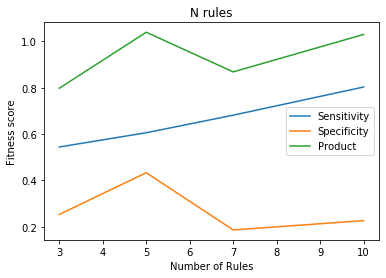

In [12]:
%load_ext autoreload
%autoreload

#Plot sen spe resuts
#read all csv
#--------------------
dataframe_results = pd.read_csv('values_number_of_rules.csv')
#--------------------

#dataframe_results_c = pd.read_csv('values_w.csv')
dataframe_results.head()

param_a_designation = 'nb of rules'
param_b_designation = 'nb of var per rule'

vec_measures = ['acc', 'f1', 'sen', 'spe']



test_data = dataframe_results.iloc[:,0:2]


data_frame_treated = libraries.trefle_project.treatmentResultsValues(dataframe_results, param_a_designation, param_b_designation, vec_measures)
data_frame_treated.columns = ['N rule', 'N var per rule', 'acc', 'f1', 'sen', 'spe']
display(data_frame_treated)



libraries.interpretability_plots.plotSenSpeNRules(data_frame_treated, 'N rules')


### Finer search of parameters

The next step will be to perform a grid search for both parameters on a narrow range of values. For this, we need to define ranges for them.


<b style="background-color:red;color:white">Question 9</b>: On the base of the graphic above, select a narrower range for the number of rules to be explored in the next step. Justify your choice.
<br>
<b style="background-color:red;color:white">Question 10</b>: Then, define a range of values for the number of variables per rule. How did you decide on them? Why?

In [16]:
#Var per rule and number of rules


#--------------------
#Path where you want to save yours models (you need to create the directory befor start the algorithm)
path_save_results_directory = 'experiences/n_rules_nvar/'
#file nam that will contain the results for each model create (so fo each fold)
file_results_dv = 'values_number_of_rules_nvar.csv'
#Name of the experience, this name will appear on the models files
experience_value_name = 'exps_lab_lfa_number_of_rules_var'
#--------------------


model_train_obj = ModelTrain(array_index_train_test = array_index_train_test,
                             X_train = X_train,
                             y_train = y_train, 
                             number_rule = 0, var_per_rule = 0, 
                             classifier_trefle = clf, 
                             path_save_results = path_save_results_directory,
                            path_save_results_values=file_results_dv,
                            experience_name = experience_value_name)



#Here we can choose wich values for the number of rules and maximum variable per 
#rule we want to test along our experience ('here you need to change and explain your choice, on the repport')
#--------------------
rules_number_vec = [4,5,6]
var_per_rule_vec = [1,2,3,4,5]
#--------------------

for variation_a in rules_number_vec:
    for variation_b in var_per_rule_vec:
        model_train_obj.number_rule = variation_a
        model_train_obj.var_per_rule = variation_b
        model_train_obj.execute_cv()

gen	species	std    	min      	avg     	max     	avg_hof 
1  	sp1    	0.18338	0.0869565	0.272118	0.636364	0.676739
1  	sp2    	0.254013	0        	0.544204	0.716981	0.704044
2  	sp1    	0.00118596	0.714286 	0.714993	0.716981	0.716644
2  	sp2    	0.247069  	0        	0.567344	0.716981	0.716644
3  	sp1    	0.00698015	0.701754 	0.707127	0.716981	0.716981
3  	sp2    	0.207726  	0        	0.608165	0.727273	0.717839
4  	sp1    	0.00943964	0.701754 	0.722144	0.769231	0.729021
4  	sp2    	0.171096  	0        	0.637561	0.769231	0.729021
5  	sp1    	0.00986471	0.701754 	0.724467	0.769231	0.730769
5  	sp2    	0.164894  	0        	0.640284	0.769231	0.730769
6  	sp1    	0.0109324 	0.701754 	0.723654	0.769231	0.730769
6  	sp2    	0.189153  	0        	0.623777	0.769231	0.730769
7  	sp1    	0.0113703 	0.701754 	0.727115	0.769231	0.734266
7  	sp2    	0.201549  	0        	0.61281 	0.769231	0.73616 
8  	sp1    	0.0141801 	0.701754 	0.731193	0.769231	0.748397
8  	sp2    	0.224899  	0        	0.609375	0.7692

69 	sp1    	0.0265437 	0.727273 	0.788514	0.816327	0.816327
69 	sp2    	0.206358  	0        	0.644488	0.816327	0.816327
70 	sp1    	0.0285293 	0.727273 	0.785572	0.816327	0.816327
70 	sp2    	0.109242  	0.153846 	0.686702	0.816327	0.816327
71 	sp1    	0.0242807 	0.714286 	0.790307	0.816327	0.816327
71 	sp2    	0.166076  	0        	0.663529	0.816327	0.816327
72 	sp1    	0.0215665 	0.714286 	0.79131 	0.816327	0.816327
72 	sp2    	0.184929  	0        	0.669498	0.816327	0.816327
73 	sp1    	0.018462  	0.740741 	0.796058	0.816327	0.816327
73 	sp2    	0.21583   	0        	0.654986	0.816327	0.816327
74 	sp1    	0.0188241 	0.740741 	0.796473	0.816327	0.816327
74 	sp2    	0.175249  	0        	0.671757	0.816327	0.816327
75 	sp1    	0.0194539 	0.740741 	0.792562	0.816327	0.816327
75 	sp2    	0.178043  	0        	0.678527	0.816327	0.816327
76 	sp1    	0.0182075 	0.740741 	0.794859	0.816327	0.816327
76 	sp2    	0.215345  	0        	0.645168	0.816327	0.816327
77 	sp1    	0.0172889 	0.740741 	0.78797

37 	sp1    	0.075127   	0.533333	0.730918	0.809524	0.809524
37 	sp2    	0.224899   	0       	0.605103	0.809524	0.809524
38 	sp1    	0.0512963  	0.666667	0.75205 	0.809524	0.809524
38 	sp2    	0.205613   	0       	0.626125	0.809524	0.809524
39 	sp1    	0.0561017  	0.642857	0.731858	0.809524	0.809524
39 	sp2    	0.200732   	0       	0.648717	0.809524	0.809524
40 	sp1    	0.0535078  	0.666667	0.739841	0.809524	0.809524
40 	sp2    	0.180535   	0       	0.639804	0.809524	0.809524
41 	sp1    	0.0554331  	0.627451	0.740344	0.809524	0.809524
41 	sp2    	0.213435   	0       	0.62266 	0.809524	0.809524
42 	sp1    	0.0639219  	0.6     	0.743355	0.809524	0.809524
42 	sp2    	0.144909   	0       	0.664621	0.809524	0.809524
43 	sp1    	0.0443833  	0.678571	0.735331	0.809524	0.809524
43 	sp2    	0.203781   	0       	0.631272	0.809524	0.809524
44 	sp1    	0.0459762  	0.679245	0.745369	0.809524	0.809524
44 	sp2    	0.198342   	0       	0.649345	0.809524	0.809524
45 	sp1    	0.0468401  	0.690909	0.74799

5  	sp2    	0.202545 	0       	0.556201	0.790698	0.770198
6  	sp1    	0.0537969	0.625   	0.724121	0.790698	0.790698
6  	sp2    	0.22184  	0       	0.535829	0.790698	0.790698
7  	sp1    	0.0583881	0.62963 	0.727985	0.790698	0.790698
7  	sp2    	0.229532 	0       	0.531436	0.790698	0.790698
8  	sp1    	0.0546935	0.62963 	0.725987	0.790698	0.790698
8  	sp2    	0.187598 	0       	0.570197	0.790698	0.790698
9  	sp1    	0.0589682	0.62963 	0.724378	0.790698	0.790698
9  	sp2    	0.193231 	0       	0.589606	0.790698	0.790698
10 	sp1    	0.0478147	0.62963 	0.748768	0.790698	0.790698
10 	sp2    	0.195942 	0       	0.596521	0.809524	0.791482
11 	sp1    	0.0570228	0.615385	0.739338	0.809524	0.807171
11 	sp2    	0.177954 	0       	0.617482	0.809524	0.807171
12 	sp1    	0.0522625	0.62963 	0.753042	0.809524	0.809524
12 	sp2    	0.191532 	0       	0.606448	0.809524	0.809524
13 	sp1    	0.0535733	0.6     	0.754366	0.809524	0.809524
13 	sp2    	0.187203 	0       	0.612754	0.809524	0.809524
14 	sp1    	0.

76 	sp2    	0.192022 	0       	0.650437	0.914286	0.914286
77 	sp1    	0.073291 	0.68    	0.812037	0.914286	0.914286
77 	sp2    	0.196095 	0.105263	0.646881	0.914286	0.914286
78 	sp1    	0.089189 	0.618182	0.783047	0.914286	0.914286
78 	sp2    	0.229583 	0       	0.619425	0.914286	0.914286
79 	sp1    	0.0901936	0.627451	0.809897	0.914286	0.914286
79 	sp2    	0.165424 	0       	0.658858	0.914286	0.914286
80 	sp1    	0.0855865	0.618182	0.817526	0.914286	0.914286
80 	sp2    	0.211349 	0       	0.626338	0.914286	0.914286
81 	sp1    	0.0771971	0.642857	0.813558	0.914286	0.914286
81 	sp2    	0.196331 	0       	0.62315 	0.914286	0.914286
82 	sp1    	0.0972073	0.588235	0.806106	0.914286	0.914286
82 	sp2    	0.186653 	0       	0.631455	0.914286	0.914286
83 	sp1    	0.0791099	0.653061	0.825346	0.914286	0.914286
83 	sp2    	0.203589 	0       	0.627377	0.914286	0.914286
84 	sp1    	0.0871316	0.615385	0.821623	0.914286	0.914286
84 	sp2    	0.207379 	0       	0.635495	0.914286	0.914286
85 	sp1    	0.

45 	sp1    	0.0306345  	0.714286 	0.75917 	0.791667	0.791667
45 	sp2    	0.212191   	0        	0.636964	0.791667	0.791667
46 	sp1    	0.0394779  	0.653061 	0.753594	0.791667	0.791667
46 	sp2    	0.162598   	0        	0.677847	0.791667	0.791667
47 	sp1    	0.0390368  	0.653846 	0.749632	0.791667	0.791667
47 	sp2    	0.191737   	0        	0.66725 	0.791667	0.791667
48 	sp1    	0.0381278  	0.677966 	0.751844	0.791667	0.791667
48 	sp2    	0.162041   	0        	0.664649	0.791667	0.791667
49 	sp1    	0.0318195  	0.666667 	0.754365	0.791667	0.791667
49 	sp2    	0.149989   	0        	0.678751	0.791667	0.791667
50 	sp1    	0.0412477  	0.653061 	0.742403	0.791667	0.791667
50 	sp2    	0.16503    	0        	0.664029	0.791667	0.791667
51 	sp1    	0.036832   	0.689655 	0.745752	0.791667	0.791667
51 	sp2    	0.159457   	0        	0.659999	0.791667	0.791667
52 	sp1    	0.0341807  	0.666667 	0.747948	0.791667	0.791667
52 	sp2    	0.233548   	0        	0.607969	0.791667	0.791667
53 	sp1    	0.0220711  	

12 	sp1    	0.027039  	0.690909	0.722351	0.77551 	0.758646
12 	sp2    	0.240382  	0       	0.581697	0.77551 	0.759913
13 	sp1    	0.0300742 	0.678571	0.726872	0.77551 	0.7662  
13 	sp2    	0.202168  	0       	0.611979	0.77551 	0.766668
14 	sp1    	0.0316796 	0.678571	0.734622	0.77551 	0.77551 
14 	sp2    	0.177971  	0       	0.63291 	0.77551 	0.77551 
15 	sp1    	0.0294895 	0.678571	0.735536	0.77551 	0.77551 
15 	sp2    	0.169239  	0       	0.645629	0.77551 	0.77551 
16 	sp1    	0.0303435 	0.689655	0.741107	0.77551 	0.77551 
16 	sp2    	0.197544  	0       	0.621963	0.77551 	0.77551 
17 	sp1    	0.0299191 	0.690909	0.73511 	0.77551 	0.77551 
17 	sp2    	0.177876  	0       	0.634974	0.77551 	0.77551 
18 	sp1    	0.0279693 	0.690909	0.740064	0.77551 	0.77551 
18 	sp2    	0.161837  	0       	0.653801	0.77551 	0.77551 
19 	sp1    	0.0247179 	0.703704	0.743893	0.77551 	0.77551 
19 	sp2    	0.206651  	0       	0.620408	0.77551 	0.77551 
20 	sp1    	0.0259192 	0.690909	0.742813	0.77551 	0.7755

80 	sp2    	0.236266  	0        	0.622371	0.826087	0.826087
81 	sp1    	0.038599  	0.703704 	0.785626	0.826087	0.826087
81 	sp2    	0.233754  	0        	0.632036	0.826087	0.826087
82 	sp1    	0.0395526 	0.703704 	0.783304	0.826087	0.826087
82 	sp2    	0.210904  	0        	0.641927	0.826087	0.826087
83 	sp1    	0.0420779 	0.693878 	0.781963	0.826087	0.826087
83 	sp2    	0.2282    	0        	0.627714	0.826087	0.826087
84 	sp1    	0.0441979 	0.693878 	0.784592	0.826087	0.826087
84 	sp2    	0.188234  	0        	0.650701	0.826087	0.826087
85 	sp1    	0.0410748 	0.693878 	0.784102	0.826087	0.826087
85 	sp2    	0.166572  	0        	0.670489	0.826087	0.826087
86 	sp1    	0.0358444 	0.703704 	0.787972	0.826087	0.826087
86 	sp2    	0.225433  	0        	0.626783	0.826087	0.826087
87 	sp1    	0.0347567 	0.703704 	0.787525	0.826087	0.826087
87 	sp2    	0.265301  	0        	0.588096	0.826087	0.826087
88 	sp1    	0.0405872 	0.703704 	0.778198	0.826087	0.826087
88 	sp2    	0.236774  	0        	0.62396

48 	sp2    	0.226545   	0       	0.629026	0.833333	0.833333
49 	sp1    	0.0343987  	0.714286	0.8051  	0.833333	0.833333
49 	sp2    	0.213106   	0       	0.646782	0.833333	0.833333
50 	sp1    	0.0345252  	0.731707	0.801211	0.833333	0.833333
50 	sp2    	0.217493   	0       	0.631968	0.833333	0.833333
51 	sp1    	0.034144   	0.714286	0.798734	0.833333	0.833333
51 	sp2    	0.246029   	0       	0.625688	0.833333	0.833333
52 	sp1    	0.0319153  	0.731707	0.803645	0.833333	0.833333
52 	sp2    	0.211793   	0       	0.649234	0.833333	0.833333
53 	sp1    	0.0288688  	0.727273	0.805345	0.833333	0.833333
53 	sp2    	0.171166   	0       	0.673534	0.833333	0.833333
54 	sp1    	0.0296848  	0.714286	0.806433	0.833333	0.833333
54 	sp2    	0.265291   	0       	0.597918	0.833333	0.833333
55 	sp1    	0.0309665  	0.714286	0.80591 	0.833333	0.833333
55 	sp2    	0.191337   	0       	0.670805	0.833333	0.833333
56 	sp1    	0.0303755  	0.714286	0.804728	0.833333	0.833333
56 	sp2    	0.248504   	0       	0.62321

16 	sp2    	0.234633  	0       	0.561822	0.790698	0.790698
17 	sp1    	0.0423683 	0.678571	0.736138	0.790698	0.790698
17 	sp2    	0.216628  	0       	0.593527	0.790698	0.790698
18 	sp1    	0.0404195 	0.678571	0.730381	0.790698	0.790698
18 	sp2    	0.183286  	0       	0.632823	0.790698	0.790698
19 	sp1    	0.037774  	0.68    	0.740514	0.790698	0.790698
19 	sp2    	0.201636  	0       	0.612406	0.790698	0.790698
20 	sp1    	0.0413658 	0.666667	0.729861	0.790698	0.790698
20 	sp2    	0.234878  	0       	0.569773	0.790698	0.790698
21 	sp1    	0.052993  	0.580645	0.721093	0.790698	0.790698
21 	sp2    	0.183451  	0       	0.633487	0.790698	0.790698
22 	sp1    	0.0423056 	0.678571	0.733846	0.790698	0.790698
22 	sp2    	0.227416  	0       	0.577506	0.790698	0.790698
23 	sp1    	0.0409818 	0.678571	0.728239	0.790698	0.790698
23 	sp2    	0.174291  	0       	0.627667	0.790698	0.790698
24 	sp1    	0.043821  	0.666667	0.737893	0.790698	0.790698
24 	sp2    	0.223498  	0       	0.592322	0.790698	0.7906

86 	sp1    	0.0511136 	0.666667	0.774092	0.837209	0.837209
86 	sp2    	0.234713  	0       	0.599629	0.837209	0.837209
87 	sp1    	0.0523728 	0.666667	0.762014	0.837209	0.837209
87 	sp2    	0.250772  	0       	0.568784	0.837209	0.837209
88 	sp1    	0.0577796 	0.654545	0.763181	0.837209	0.837209
88 	sp2    	0.279083  	0       	0.54122 	0.837209	0.837209
89 	sp1    	0.058186  	0.647059	0.760674	0.837209	0.837209
89 	sp2    	0.229236  	0       	0.582245	0.837209	0.837209
90 	sp1    	0.0540003 	0.666667	0.771731	0.837209	0.837209
90 	sp2    	0.269146  	0       	0.544257	0.837209	0.837209
91 	sp1    	0.0510797 	0.666667	0.776704	0.837209	0.837209
91 	sp2    	0.206048  	0       	0.623615	0.857143	0.83804 
92 	sp1    	0.0542544 	0.666667	0.777849	0.857143	0.842193
92 	sp2    	0.195153  	0       	0.630463	0.857143	0.842193
93 	sp1    	0.0514815 	0.666667	0.776763	0.857143	0.843023
93 	sp2    	0.208186  	0       	0.61259 	0.857143	0.843023
94 	sp1    	0.0553835 	0.678571	0.787728	0.857143	0.8480

55 	sp2    	0.247739  	0       	0.53581 	0.829268	0.829268
56 	sp1    	0.0454198 	0.666667	0.765938	0.829268	0.829268
56 	sp2    	0.236035  	0       	0.535966	0.829268	0.829268
57 	sp1    	0.0457923 	0.68    	0.769171	0.829268	0.829268
57 	sp2    	0.214672  	0       	0.575214	0.829268	0.829268
58 	sp1    	0.0454337 	0.68    	0.775437	0.829268	0.829268
58 	sp2    	0.225186  	0       	0.558664	0.829268	0.829268
59 	sp1    	0.0489355 	0.666667	0.762566	0.829268	0.829268
59 	sp2    	0.214616  	0       	0.581408	0.829268	0.829268
60 	sp1    	0.0438022 	0.68    	0.760655	0.829268	0.829268
60 	sp2    	0.205419  	0       	0.605604	0.829268	0.829268
61 	sp1    	0.047733  	0.666667	0.76783 	0.829268	0.829268
61 	sp2    	0.229904  	0       	0.577735	0.829268	0.829268
62 	sp1    	0.049486  	0.666667	0.762199	0.829268	0.829268
62 	sp2    	0.225695  	0       	0.557575	0.829268	0.829268
63 	sp1    	0.049448  	0.666667	0.751135	0.829268	0.829268
63 	sp2    	0.22337   	0       	0.565905	0.829268	0.8292

24 	sp1    	0.0237216  	0.693878	0.755582	0.784314	0.784314
24 	sp2    	0.232487   	0       	0.602276	0.784314	0.784314
25 	sp1    	0.0224159  	0.708333	0.757597	0.784314	0.784314
25 	sp2    	0.273078   	0       	0.559933	0.784314	0.784314
26 	sp1    	0.0223568  	0.678571	0.760076	0.784314	0.784314
26 	sp2    	0.220458   	0       	0.607108	0.784314	0.784314
27 	sp1    	0.019718   	0.708333	0.7635  	0.784314	0.784314
27 	sp2    	0.213909   	0       	0.62675 	0.784314	0.784314
28 	sp1    	0.018415   	0.716981	0.758735	0.784314	0.784314
28 	sp2    	0.238578   	0       	0.593799	0.784314	0.784314
29 	sp1    	0.0196945  	0.714286	0.763307	0.784314	0.784314
29 	sp2    	0.206245   	0       	0.627253	0.784314	0.784314
30 	sp1    	0.0191825  	0.727273	0.761701	0.784314	0.784314
30 	sp2    	0.228385   	0       	0.610606	0.784314	0.784314
31 	sp1    	0.0197393  	0.689655	0.762862	0.784314	0.784314
31 	sp2    	0.243444   	0       	0.58319 	0.784314	0.784314
32 	sp1    	0.0211817  	0.653846	0.76406

92 	sp2    	0.221844   	0       	0.628481	0.844444	0.844444
93 	sp1    	0.0359409  	0.666667	0.803427	0.844444	0.844444
93 	sp2    	0.2137     	0       	0.629821	0.844444	0.844444
94 	sp1    	0.0337379  	0.730769	0.803155	0.844444	0.844444
94 	sp2    	0.253771   	0       	0.591471	0.844444	0.844444
95 	sp1    	0.0320501  	0.730769	0.811088	0.844444	0.844444
95 	sp2    	0.228807   	0       	0.606918	0.844444	0.844444
96 	sp1    	0.0306815  	0.727273	0.802821	0.844444	0.844444
96 	sp2    	0.233869   	0       	0.599866	0.844444	0.844444
97 	sp1    	0.0329947  	0.727273	0.80627 	0.844444	0.844444
97 	sp2    	0.248669   	0       	0.585271	0.844444	0.844444
98 	sp1    	0.0350466  	0.727273	0.803163	0.844444	0.844444
98 	sp2    	0.244869   	0       	0.591158	0.844444	0.844444
99 	sp1    	0.0364397  	0.730769	0.80156 	0.844444	0.844444
99 	sp2    	0.18977    	0       	0.647446	0.844444	0.844444
100	sp1    	0.0391157  	0.730769	0.802955	0.844444	0.844444
100	sp2    	0.215186   	0       	0.64422

61 	sp2    	0.238431  	0       	0.599394	0.784314	0.784314
62 	sp1    	0.0108917 	0.740741	0.773367	0.784314	0.784314
62 	sp2    	0.213607  	0       	0.625254	0.784314	0.784314
63 	sp1    	0.0113444 	0.745098	0.777176	0.784314	0.784314
63 	sp2    	0.282899  	0       	0.541211	0.784314	0.784314
64 	sp1    	0.0179091 	0.716981	0.765108	0.784314	0.784314
64 	sp2    	0.219267  	0       	0.614856	0.784314	0.784314
65 	sp1    	0.010044  	0.745098	0.774446	0.784314	0.784314
65 	sp2    	0.226113  	0       	0.600936	0.784314	0.784314
66 	sp1    	0.0117518 	0.734694	0.774917	0.784314	0.784314
66 	sp2    	0.243158  	0       	0.588645	0.784314	0.784314
67 	sp1    	0.00673476	0.769231	0.780166	0.784314	0.784314
67 	sp2    	0.234449  	0       	0.595559	0.784314	0.784314
68 	sp1    	0.0141554 	0.730769	0.772432	0.784314	0.784314
68 	sp2    	0.248071  	0       	0.59576 	0.784314	0.784314
69 	sp1    	0.00992238	0.740741	0.775886	0.784314	0.784314
69 	sp2    	0.232163  	0       	0.625304	0.784314	0.7843

30 	sp1    	0.037405   	0.75    	0.801102	0.837209	0.837209
30 	sp2    	0.272733   	0       	0.579901	0.837209	0.837209
31 	sp1    	0.0377626  	0.740741	0.79716 	0.837209	0.837209
31 	sp2    	0.307352   	0       	0.544447	0.837209	0.837209
32 	sp1    	0.0350907  	0.684211	0.802149	0.837209	0.837209
32 	sp2    	0.283429   	0       	0.572605	0.837209	0.837209
33 	sp1    	0.0356728  	0.684211	0.801005	0.837209	0.837209
33 	sp2    	0.211301   	0       	0.656794	0.857143	0.838341
34 	sp1    	0.0330117  	0.76    	0.808722	0.857143	0.846032
34 	sp2    	0.231971   	0       	0.62877 	0.857143	0.846032
35 	sp1    	0.0382228  	0.731707	0.798907	0.857143	0.846032
35 	sp2    	0.232623   	0       	0.624628	0.857143	0.846032
36 	sp1    	0.0402716  	0.714286	0.793003	0.857143	0.846561
36 	sp2    	0.223744   	0       	0.660945	0.857143	0.846561
37 	sp1    	0.0409859  	0.701754	0.792973	0.857143	0.847619
37 	sp2    	0.232674   	0       	0.648128	0.857143	0.847619
38 	sp1    	0.0397156  	0.723404	0.77996

98 	sp2    	0.257868   	0       	0.606881	0.857143	0.857143
99 	sp1    	0.0478399  	0.666667	0.811577	0.857143	0.857143
99 	sp2    	0.250276   	0       	0.629859	0.878049	0.858014
100	sp1    	0.0530831  	0.685714	0.826992	0.9     	0.878963
100	sp2    	0.206416   	0       	0.653633	0.9     	0.878963
save end
gen	species	std        	min     	avg     	max     	avg_hof 
1  	sp1    	1.11022e-16	0.642857	0.642857	0.642857	0.648257
1  	sp2    	0.283322   	0       	0.395222	0.68    	0.671154
2  	sp1    	0.000546258	0.678571	0.678847	0.68    	0.679489
2  	sp2    	0.287474   	0       	0.429188	0.734694	0.683489
3  	sp1    	0.0183476  	0.666667	0.734354	0.75    	0.749362
3  	sp2    	0.262586   	0       	0.51029 	0.75    	0.749362
4  	sp1    	0.0090007  	0.716981	0.739739	0.75    	0.75    
4  	sp2    	0.286559   	0       	0.47354 	0.75    	0.75    
5  	sp1    	0.00891097 	0.716981	0.7413  	0.75    	0.75    
5  	sp2    	0.265916   	0       	0.528886	0.75    	0.75    
6  	sp1    	0.00910285 	0.71698

66 	sp2    	0.316745   	0       	0.508211	0.857143	0.857143
67 	sp1    	0.0274762  	0.744186	0.826454	0.857143	0.857143
67 	sp2    	0.298925   	0       	0.563832	0.857143	0.857143
68 	sp1    	0.0260152  	0.75    	0.832296	0.857143	0.857143
68 	sp2    	0.292033   	0       	0.572656	0.857143	0.857143
69 	sp1    	0.0295131  	0.75    	0.829679	0.857143	0.857143
69 	sp2    	0.289298   	0       	0.5371  	0.857143	0.857143
70 	sp1    	0.0269306  	0.765957	0.830914	0.857143	0.857143
70 	sp2    	0.291719   	0       	0.554621	0.857143	0.857143
71 	sp1    	0.0297615  	0.765957	0.830512	0.857143	0.857143
71 	sp2    	0.30806    	0       	0.530604	0.857143	0.857143
72 	sp1    	0.0290844  	0.75    	0.833266	0.857143	0.857143
72 	sp2    	0.267957   	0       	0.609426	0.857143	0.857143
73 	sp1    	0.0266077  	0.75    	0.835224	0.857143	0.857143
73 	sp2    	0.294377   	0       	0.572782	0.857143	0.857143
74 	sp1    	0.0239365  	0.765957	0.836003	0.857143	0.857143
74 	sp2    	0.308103   	0       	0.52562

34 	sp2    	0.298204   	0       	0.553188	0.85    	0.85    
35 	sp1    	0.0752718  	0.62069 	0.79635 	0.85    	0.85    
35 	sp2    	0.288909   	0       	0.577715	0.85    	0.85    
36 	sp1    	0.0727409  	0.62069 	0.796023	0.85    	0.85    
36 	sp2    	0.192129   	0       	0.651685	0.85    	0.85    
37 	sp1    	0.0692803  	0.62963 	0.800934	0.85    	0.85    
37 	sp2    	0.176563   	0       	0.656617	0.85    	0.85    
38 	sp1    	0.0415385  	0.666667	0.816805	0.85    	0.85    
38 	sp2    	0.225617   	0       	0.622105	0.85    	0.85    
39 	sp1    	0.0452024  	0.666667	0.817204	0.85    	0.85    
39 	sp2    	0.24397    	0       	0.608456	0.85    	0.85    
40 	sp1    	0.0879177  	0.62069 	0.775674	0.85    	0.85    
40 	sp2    	0.265662   	0       	0.566252	0.85    	0.85    
41 	sp1    	0.0801789  	0.62069 	0.79087 	0.85    	0.85    
41 	sp2    	0.274634   	0       	0.572755	0.85    	0.85    
42 	sp1    	0.0352385  	0.723404	0.828479	0.85    	0.85    
42 	sp2    	0.289127   	0       	0.57002

2  	sp2    	0.257155   	0       	0.538838	0.716981	0.705804
3  	sp1    	0.0101124  	0.677966	0.69749 	0.716981	0.706358
3  	sp2    	0.223257   	0       	0.586799	0.716981	0.707793
4  	sp1    	0.0125057  	0.666667	0.695581	0.716981	0.708346
4  	sp2    	0.268076   	0       	0.532469	0.716981	0.709669
5  	sp1    	0.00756243 	0.678571	0.699952	0.716981	0.709669
5  	sp2    	0.242326   	0       	0.566788	0.716981	0.712755
6  	sp1    	0.0059316  	0.689655	0.702106	0.716981	0.714415
6  	sp2    	0.231929   	0       	0.578912	0.716981	0.715521
7  	sp1    	0.00855365 	0.666667	0.702585	0.716981	0.716083
7  	sp2    	0.26898    	0       	0.528398	0.727273	0.716961
8  	sp1    	0.0155408  	0.677966	0.717322	0.727273	0.727273
8  	sp2    	0.223666   	0       	0.592964	0.727273	0.727273
9  	sp1    	0.0114838  	0.690909	0.720635	0.727273	0.727273
9  	sp2    	0.232631   	0       	0.575441	0.761905	0.730159
10 	sp1    	0.0261612  	0.689655	0.734276	0.790698	0.767341
10 	sp2    	0.256282   	0       	0.56594

71 	sp1    	0.0515255  	0.703704	0.796397	0.878049	0.858885
71 	sp2    	0.223857   	0       	0.632323	0.878049	0.858885
72 	sp1    	0.052121   	0.703704	0.801491	0.878049	0.858885
72 	sp2    	0.191611   	0       	0.650343	0.878049	0.858885
73 	sp1    	0.0520799  	0.703704	0.807114	0.878049	0.860627
73 	sp2    	0.228811   	0       	0.603164	0.878049	0.860627
74 	sp1    	0.0532696  	0.703704	0.800309	0.878049	0.860627
74 	sp2    	0.262577   	0       	0.57382 	0.878049	0.860627
75 	sp1    	0.0573623  	0.701754	0.800836	0.878049	0.862369
75 	sp2    	0.27985    	0       	0.576179	0.878049	0.862369
76 	sp1    	0.0602239  	0.692308	0.804363	0.878049	0.869338
76 	sp2    	0.214244   	0       	0.658251	0.878049	0.869338
77 	sp1    	0.0562482  	0.692308	0.811724	0.878049	0.875436
77 	sp2    	0.202081   	0       	0.642033	0.878049	0.875436
78 	sp1    	0.0514767  	0.692308	0.81742 	0.878049	0.878049
78 	sp2    	0.252846   	0       	0.586533	0.878049	0.878049
79 	sp1    	0.0513223  	0.692308	0.81682

39 	sp1    	0.044641 	0.678571	0.762037 	0.808511 	0.808511
39 	sp2    	0.217443 	0       	0.616134 	0.808511 	0.808511
40 	sp1    	0.0432939	0.677966	0.765859 	0.808511 	0.808511
40 	sp2    	0.206026 	0       	0.624702 	0.808511 	0.808511
41 	sp1    	0.0467693	0.677966	0.771185 	0.808511 	0.808511
41 	sp2    	0.240301 	0       	0.588799 	0.808511 	0.808511
42 	sp1    	0.0511965	0.666667	0.768553 	0.808511 	0.808511
42 	sp2    	0.214186 	0       	0.610029 	0.808511 	0.808511
43 	sp1    	0.0468558	0.666667	0.772846 	0.808511 	0.808511
43 	sp2    	0.225228 	0       	0.605101 	0.808511 	0.808511
44 	sp1    	0.0418774	0.689655	0.774616 	0.808511 	0.808511
44 	sp2    	0.23379  	0       	0.596597 	0.808511 	0.808511
45 	sp1    	0.0444791	0.677966	0.766798 	0.808511 	0.808511
45 	sp2    	0.240455 	0       	0.59867  	0.808511 	0.808511
46 	sp1    	0.0401386	0.689655	0.769745 	0.808511 	0.808511
46 	sp2    	0.232733 	0       	0.608865 	0.808511 	0.808511
47 	sp1    	0.0570187	0.611111	0.762958 

7  	sp1    	0.0076411 	0.727273	0.732847	0.754717	0.745982
7  	sp2    	0.300754  	0       	0.504224	0.754717	0.750641
8  	sp1    	0.0107086 	0.714286	0.729584	0.754717	0.753552
8  	sp2    	0.29559   	0       	0.516955	0.754717	0.754717
9  	sp1    	0.0122422 	0.714286	0.733139	0.754717	0.754717
9  	sp2    	0.252404  	0       	0.56599 	0.754717	0.754717
10 	sp1    	0.0135518 	0.714286	0.734194	0.754717	0.754717
10 	sp2    	0.273445  	0       	0.565493	0.784314	0.75595 
11 	sp1    	0.0142952 	0.727273	0.756045	0.791667	0.775101
11 	sp2    	0.270012  	0       	0.563036	0.791667	0.776421
12 	sp1    	0.0152539 	0.745098	0.760739	0.791667	0.783032
12 	sp2    	0.269245  	0       	0.54377 	0.791667	0.783705
13 	sp1    	0.015439  	0.745098	0.76386 	0.791667	0.785846
13 	sp2    	0.282465  	0       	0.524501	0.791667	0.786152
14 	sp1    	0.0176191 	0.745098	0.766541	0.8     	0.789379
14 	sp2    	0.225036  	0       	0.586293	0.8     	0.789685
15 	sp1    	0.0183394 	0.745098	0.765464	0.8     	0.7922

76 	sp2    	0.278316  	0       	0.589155	0.851064	0.851064
77 	sp1    	0.0350815 	0.727273	0.823422	0.851064	0.851064
77 	sp2    	0.313436  	0       	0.548745	0.851064	0.851064
78 	sp1    	0.0264962 	0.714286	0.833725	0.851064	0.851064
78 	sp2    	0.309915  	0       	0.551678	0.851064	0.851064
79 	sp1    	0.0302591 	0.731707	0.826267	0.851064	0.851064
79 	sp2    	0.290958  	0       	0.572145	0.851064	0.851064
80 	sp1    	0.0243403 	0.744186	0.831225	0.851064	0.851064
80 	sp2    	0.277658  	0       	0.572583	0.851064	0.851064
81 	sp1    	0.0431158 	0.68    	0.822206	0.851064	0.851064
81 	sp2    	0.29318   	0       	0.55935 	0.851064	0.851064
82 	sp1    	0.0383013 	0.678571	0.825919	0.851064	0.851064
82 	sp2    	0.283841  	0       	0.603237	0.851064	0.851064
83 	sp1    	0.0376382 	0.648649	0.829191	0.851064	0.851064
83 	sp2    	0.302583  	0       	0.581794	0.851064	0.851064
84 	sp1    	0.0318736 	0.714286	0.833597	0.869565	0.862133
84 	sp2    	0.240829  	0       	0.646233	0.869565	0.8621

46 	sp2    	0.237978 	0       	0.562127	0.808511	0.808511
47 	sp1    	0.0179323	0.745098	0.789178	0.808511	0.808511
47 	sp2    	0.251818 	0       	0.539392	0.808511	0.808511
48 	sp1    	0.0204913	0.730769	0.788957	0.808511	0.808511
48 	sp2    	0.269656 	0       	0.509659	0.808511	0.808511
49 	sp1    	0.0187946	0.730769	0.789609	0.808511	0.808511
49 	sp2    	0.278077 	0       	0.513378	0.808511	0.808511
50 	sp1    	0.018666 	0.745098	0.789112	0.808511	0.808511
50 	sp2    	0.275609 	0       	0.529097	0.808511	0.808511
51 	sp1    	0.019979 	0.745098	0.788508	0.808511	0.808511
51 	sp2    	0.286285 	0       	0.513009	0.808511	0.808511
52 	sp1    	0.0199483	0.745098	0.786165	0.808511	0.808511
52 	sp2    	0.259037 	0       	0.545034	0.808511	0.808511
53 	sp1    	0.0229149	0.730769	0.782845	0.808511	0.808511
53 	sp2    	0.225761 	0       	0.571951	0.809524	0.808553
54 	sp1    	0.0282587	0.705882	0.78114 	0.829268	0.811232
54 	sp2    	0.26994  	0       	0.507638	0.829268	0.811232
55 	sp1    	0.

17 	sp1    	0.0270764 	0.64    	0.681589	0.723404	0.723404
17 	sp2    	0.279682  	0       	0.445338	0.723404	0.723404
18 	sp1    	0.0266125 	0.64    	0.682635	0.723404	0.723404
18 	sp2    	0.226536  	0       	0.530863	0.723404	0.723404
19 	sp1    	0.0265697 	0.653061	0.686635	0.723404	0.723404
19 	sp2    	0.257478  	0       	0.48736 	0.723404	0.723404
20 	sp1    	0.0219415 	0.653061	0.69401 	0.723404	0.723404
20 	sp2    	0.234137  	0       	0.498702	0.723404	0.723404
21 	sp1    	0.0239527 	0.652174	0.69642 	0.723404	0.723404
21 	sp2    	0.260588  	0       	0.471366	0.723404	0.723404
22 	sp1    	0.0237304 	0.622222	0.697801	0.723404	0.723404
22 	sp2    	0.258707  	0       	0.474637	0.736842	0.724125
23 	sp1    	0.0356024 	0.666667	0.71147 	0.8     	0.756804
23 	sp2    	0.268791  	0       	0.45417 	0.8     	0.757508
24 	sp1    	0.0518318 	0.615385	0.717445	0.809524	0.779237
24 	sp2    	0.261931  	0       	0.431392	0.809524	0.779976
25 	sp1    	0.066125  	0.627451	0.714118	0.809524	0.8019

86 	sp2    	0.300313  	0       	0.562113	0.871795	0.871795
87 	sp1    	0.0380461 	0.722222	0.836276	0.871795	0.871795
87 	sp2    	0.256048  	0       	0.619932	0.871795	0.871795
88 	sp1    	0.0477    	0.68    	0.826371	0.871795	0.871795
88 	sp2    	0.285342  	0       	0.577966	0.871795	0.871795
89 	sp1    	0.0546402 	0.681818	0.820416	0.871795	0.871795
89 	sp2    	0.286324  	0       	0.554922	0.871795	0.871795
90 	sp1    	0.0454025 	0.666667	0.826735	0.871795	0.871795
90 	sp2    	0.28049   	0       	0.566867	0.871795	0.871795
91 	sp1    	0.0872584 	0.580645	0.785126	0.871795	0.871795
91 	sp2    	0.296875  	0       	0.565159	0.871795	0.871795
92 	sp1    	0.0573629 	0.642857	0.820364	0.871795	0.871795
92 	sp2    	0.316034  	0       	0.52957 	0.871795	0.871795
93 	sp1    	0.0619349 	0.62069 	0.81636 	0.871795	0.871795
93 	sp2    	0.261429  	0       	0.627702	0.871795	0.871795
94 	sp1    	0.0632974 	0.642857	0.814951	0.871795	0.871795
94 	sp2    	0.281867  	0       	0.569643	0.871795	0.8717

55 	sp2    	0.323358  	0       	0.505569	0.851064	0.851064
56 	sp1    	0.0323612 	0.731707	0.816885	0.851064	0.851064
56 	sp2    	0.308756  	0       	0.510742	0.851064	0.851064
57 	sp1    	0.0356188 	0.731707	0.812748	0.851064	0.851064
57 	sp2    	0.291245  	0       	0.541448	0.851064	0.851064
58 	sp1    	0.0349269 	0.714286	0.812504	0.851064	0.851064
58 	sp2    	0.30774   	0       	0.515114	0.851064	0.851064
59 	sp1    	0.0304455 	0.76    	0.81813 	0.851064	0.851064
59 	sp2    	0.297505  	0       	0.55457 	0.851064	0.851064
60 	sp1    	0.0298411 	0.744186	0.817431	0.851064	0.851064
60 	sp2    	0.311921  	0       	0.527792	0.851064	0.851064
61 	sp1    	0.0420858 	0.714286	0.805108	0.851064	0.851064
61 	sp2    	0.238188  	0       	0.619074	0.851064	0.851064
62 	sp1    	0.0327972 	0.744186	0.808956	0.851064	0.851064
62 	sp2    	0.301171  	0       	0.534818	0.851064	0.851064
63 	sp1    	0.0427101 	0.714286	0.803636	0.851064	0.851064
63 	sp2    	0.281678  	0       	0.557581	0.851064	0.8510

24 	sp1    	0.0493669	0.642857 	0.754223 	0.809524 	0.809524
24 	sp2    	0.291687 	0        	0.527828 	0.809524 	0.809524
25 	sp1    	0.03086  	0.695652 	0.777256 	0.809524 	0.809524
25 	sp2    	0.302117 	0        	0.528601 	0.809524 	0.809524
26 	sp1    	0.0446193	0.689655 	0.756232 	0.809524 	0.809524
26 	sp2    	0.26125  	0        	0.592704 	0.809524 	0.809524
27 	sp1    	0.0719414	0.5625   	0.747658 	0.809524 	0.809524
27 	sp2    	0.27129  	0        	0.572702 	0.809524 	0.809524
28 	sp1    	0.0777274	0.5      	0.742887 	0.809524 	0.809524
28 	sp2    	0.30052  	0        	0.520789 	0.809524 	0.809524
29 	sp1    	0.0483292	0.5625   	0.746203 	0.809524 	0.809524
29 	sp2    	0.298595 	0        	0.536983 	0.809524 	0.809524
30 	sp1    	0.0442741	0.666667 	0.745944 	0.809524 	0.809524
30 	sp2    	0.301898 	0        	0.521718 	0.809524 	0.809524
31 	sp1    	0.03887  	0.594595 	0.75772  	0.809524 	0.809524
31 	sp2    	0.289661 	0        	0.552984 	0.809524 	0.809524
32 	sp1    	0.0567491	0.

91 	sp2    	0.295776 	0        	0.552501 	0.829268 	0.829268
92 	sp1    	0.053993 	0.666667 	0.761464 	0.829268 	0.829268
92 	sp2    	0.315885 	0        	0.505429 	0.829268 	0.829268
93 	sp1    	0.0695704	0.545455 	0.759165 	0.829268 	0.829268
93 	sp2    	0.27583  	0        	0.586984 	0.829268 	0.829268
94 	sp1    	0.04906  	0.678571 	0.768603 	0.829268 	0.829268
94 	sp2    	0.290906 	0        	0.560193 	0.829268 	0.829268
95 	sp1    	0.0458154	0.588235 	0.776857 	0.829268 	0.829268
95 	sp2    	0.294895 	0        	0.565046 	0.829268 	0.829268
96 	sp1    	0.0674381	0.5625   	0.762479 	0.829268 	0.829268
96 	sp2    	0.295779 	0        	0.559341 	0.829268 	0.829268
97 	sp1    	0.0410394	0.690909 	0.781118 	0.829268 	0.829268
97 	sp2    	0.290739 	0        	0.541998 	0.829268 	0.829268
98 	sp1    	0.0488068	0.678571 	0.778399 	0.829268 	0.829268
98 	sp2    	0.329666 	0        	0.477223 	0.829268 	0.829268
99 	sp1    	0.076079 	0.5625   	0.761664 	0.829268 	0.829268
99 	sp2    	0.312589 	0 

60 	sp2    	0.321226  	0       	0.47096 	0.8     	0.8     
61 	sp1    	0.0215119 	0.727273	0.778297	0.8     	0.8     
61 	sp2    	0.303418  	0       	0.532059	0.816327	0.80068 
62 	sp1    	0.0215357 	0.727273	0.788407	0.816327	0.812245
62 	sp2    	0.301879  	0       	0.505862	0.816327	0.812925
63 	sp1    	0.0294597 	0.727273	0.784912	0.816327	0.816327
63 	sp2    	0.3102    	0       	0.525007	0.816327	0.816327
64 	sp1    	0.0476482 	0.678571	0.775722	0.816327	0.816327
64 	sp2    	0.284694  	0       	0.573713	0.816327	0.816327
65 	sp1    	0.0312891 	0.703704	0.784633	0.816327	0.816327
65 	sp2    	0.28393   	0       	0.565832	0.816327	0.816327
66 	sp1    	0.0231702 	0.730769	0.787357	0.816327	0.816327
66 	sp2    	0.296643  	0       	0.554751	0.816327	0.816327
67 	sp1    	0.0263971 	0.703704	0.790037	0.816327	0.816327
67 	sp2    	0.286994  	0       	0.56275 	0.816327	0.816327
68 	sp1    	0.0234958 	0.730769	0.792028	0.816327	0.816327
68 	sp2    	0.319881  	0       	0.487829	0.833333	0.8170

30 	sp2    	0.317617 	0       	0.454551	0.8     	0.8     
31 	sp1    	0.0224174	0.723404	0.774726	0.8     	0.8     
31 	sp2    	0.306806 	0       	0.487021	0.8     	0.8     
32 	sp1    	0.0202351	0.723404	0.78109 	0.8     	0.8     
32 	sp2    	0.320757 	0       	0.481308	0.8     	0.8     
33 	sp1    	0.0195393	0.723404	0.78353 	0.8     	0.8     
33 	sp2    	0.279632 	0       	0.54667 	0.8     	0.8     
34 	sp1    	0.0190305	0.73913 	0.781719	0.8     	0.8     
34 	sp2    	0.321931 	0       	0.483589	0.8     	0.8     
35 	sp1    	0.0189988	0.723404	0.779703	0.8     	0.8     
35 	sp2    	0.290292 	0       	0.541437	0.8     	0.8     
36 	sp1    	0.020112 	0.72    	0.777678	0.8     	0.8     
36 	sp2    	0.321908 	0       	0.500994	0.8     	0.8     
37 	sp1    	0.0231069	0.708333	0.774713	0.8     	0.8     
37 	sp2    	0.261856 	0       	0.591516	0.8     	0.8     
38 	sp1    	0.025971 	0.708333	0.775742	0.8     	0.8     
38 	sp2    	0.301106 	0       	0.5319  	0.8     	0.8     
39 	sp1    	0.

1  	sp2    	0.251058	0  	0.30178	0.641509	0.610308 
2  	sp1    	0.0038204	0.641509	0.642953	0.653061	0.623248 
2  	sp2    	0.256906 	0       	0.386283	0.653061	0.633404 
3  	sp1    	0.00346554	0.641509	0.642665	0.653061	0.64536  
3  	sp2    	0.2595    	0       	0.413117	0.653061	0.64536  
4  	sp1    	0.00397814	0.641509	0.643098	0.653061	0.646804 
4  	sp2    	0.255205  	0       	0.458713	0.680851	0.652179 
5  	sp1    	0.0097907 	0.653061	0.668726	0.680851	0.680851 
5  	sp2    	0.251163  	0       	0.468145	0.680851	0.680851 
6  	sp1    	0.00957879	0.653061	0.671349	0.680851	0.680851 
6  	sp2    	0.265048  	0       	0.446379	0.693878	0.681937 
7  	sp1    	0.0116798 	0.653061	0.676229	0.693878	0.691706 
7  	sp2    	0.277627  	0       	0.431992	0.693878	0.692249 
8  	sp1    	0.00866194	0.666667	0.684183	0.693878	0.693878 
8  	sp2    	0.28707   	0       	0.398755	0.693878	0.693878 
9  	sp1    	0.0102165 	0.666667	0.682371	0.693878	0.693878 
9  	sp2    	0.260106  	0       	0.458622	0.693878	

70 	sp1    	0.03683   	0.648649	0.771083	0.8     	0.8      
70 	sp2    	0.296262  	0       	0.480133	0.8     	0.8      
71 	sp1    	0.0325466 	0.666667	0.773967	0.8     	0.8      
71 	sp2    	0.287876  	0       	0.495799	0.820513	0.800855 
72 	sp1    	0.0176843 	0.731707	0.781217	0.820513	0.802503 
72 	sp2    	0.28723   	0       	0.524324	0.820513	0.802503 
73 	sp1    	0.0276515 	0.685714	0.772504	0.820513	0.803694 
73 	sp2    	0.226896  	0       	0.595937	0.820513	0.804548 
74 	sp1    	0.0326717 	0.666667	0.760153	0.820513	0.809829 
74 	sp2    	0.283125  	0       	0.490934	0.820513	0.810684 
75 	sp1    	0.0346783 	0.666667	0.766983	0.820513	0.815018 
75 	sp2    	0.283368  	0       	0.502632	0.820513	0.815476 
76 	sp1    	0.0382991 	0.666667	0.768527	0.820513	0.818681 
76 	sp2    	0.282105  	0       	0.512546	0.820513	0.819139 
77 	sp1    	0.0369044 	0.68    	0.776205	0.820513	0.820513 
77 	sp2    	0.275396  	0       	0.516168	0.820513	0.820513 
78 	sp1    	0.030111  	0.717949	0.788331

38 	sp1    	0.0129903 	0.727273 	0.774481	0.784314	0.784314
38 	sp2    	0.309082  	0        	0.487897	0.784314	0.784314
39 	sp1    	0.0161488 	0.714286 	0.771992	0.784314	0.784314
39 	sp2    	0.285934  	0        	0.546863	0.784314	0.784314
40 	sp1    	0.0187637 	0.714286 	0.768595	0.784314	0.784314
40 	sp2    	0.331891  	0        	0.453019	0.784314	0.784314
41 	sp1    	0.0147355 	0.714286 	0.770748	0.784314	0.784314
41 	sp2    	0.30262   	0        	0.531784	0.784314	0.784314
42 	sp1    	0.0148556 	0.727273 	0.773427	0.784314	0.784314
42 	sp2    	0.315755  	0        	0.518288	0.784314	0.784314
43 	sp1    	0.0176487 	0.714286 	0.768813	0.784314	0.784314
43 	sp2    	0.269889  	0        	0.58127 	0.784314	0.784314
44 	sp1    	0.00948255	0.754717 	0.773624	0.784314	0.784314
44 	sp2    	0.29625   	0        	0.545765	0.784314	0.784314
45 	sp1    	0.0112793 	0.740741 	0.773673	0.784314	0.784314
45 	sp2    	0.302825  	0        	0.554582	0.784314	0.784314
46 	sp1    	0.0109769 	0.740741 	0.77273

6  	sp1    	0.0154522  	0.692308	0.727346	0.740741	0.740741
6  	sp2    	0.220363   	0       	0.588166	0.769231	0.741928
7  	sp1    	0.0218359  	0.692308	0.737982	0.769231	0.763183
7  	sp2    	0.255846   	0       	0.55207 	0.769231	0.764393
8  	sp1    	0.0138108  	0.72    	0.755373	0.769231	0.769231
8  	sp2    	0.270618   	0       	0.535446	0.769231	0.769231
9  	sp1    	0.0148239  	0.72    	0.755825	0.769231	0.769231
9  	sp2    	0.292145   	0       	0.500374	0.769231	0.769231
10 	sp1    	0.0121993  	0.740741	0.759552	0.769231	0.769231
10 	sp2    	0.296573   	0       	0.509251	0.784314	0.769859
11 	sp1    	0.0140476  	0.734694	0.773132	0.784314	0.784314
11 	sp2    	0.306476   	0       	0.507214	0.784314	0.784314
12 	sp1    	0.015084   	0.734694	0.771043	0.8     	0.786275
12 	sp2    	0.288127   	0       	0.540295	0.8     	0.786275
13 	sp1    	0.0173296  	0.734694	0.771047	0.8     	0.788889
13 	sp2    	0.242027   	0       	0.589359	0.8     	0.788889
14 	sp1    	0.0174264  	0.734694	0.77164

74 	sp2    	0.298069   	0       	0.589406	0.869565	0.869565
75 	sp1    	0.0270875  	0.77551 	0.84487 	0.869565	0.869565
75 	sp2    	0.311892   	0       	0.543168	0.869565	0.869565
76 	sp1    	0.0264674  	0.754717	0.848485	0.869565	0.869565
76 	sp2    	0.309277   	0       	0.557717	0.869565	0.869565
77 	sp1    	0.0249855  	0.745098	0.846707	0.869565	0.869565
77 	sp2    	0.304033   	0       	0.553256	0.869565	0.869565
78 	sp1    	0.0289029  	0.73913 	0.842427	0.869565	0.869565
78 	sp2    	0.305484   	0       	0.551491	0.869565	0.869565
79 	sp1    	0.0290194  	0.73913 	0.837371	0.869565	0.869565
79 	sp2    	0.317103   	0       	0.532731	0.869565	0.869565
80 	sp1    	0.0280305  	0.73913 	0.845819	0.869565	0.869565
80 	sp2    	0.297872   	0       	0.581515	0.869565	0.869565
81 	sp1    	0.0267766  	0.76    	0.845781	0.869565	0.869565
81 	sp2    	0.326716   	0       	0.516947	0.869565	0.869565
82 	sp1    	0.0317643  	0.731707	0.836139	0.869565	0.869565
82 	sp2    	0.285693   	0       	0.60424

43 	sp2    	0.203909  	0       	0.627212	0.826087	0.818031
44 	sp1    	0.0461361 	0.689655	0.750593	0.826087	0.820961
44 	sp2    	0.216154  	0       	0.641142	0.826087	0.823158
45 	sp1    	0.0332006 	0.727273	0.794176	0.844444	0.827617
45 	sp2    	0.193631  	0       	0.648382	0.844444	0.827617
46 	sp1    	0.0308479 	0.716981	0.800848	0.844444	0.829147
46 	sp2    	0.219441  	0       	0.630158	0.844444	0.829147
47 	sp1    	0.0299379 	0.722222	0.802352	0.844444	0.832206
47 	sp2    	0.224743  	0       	0.638782	0.844444	0.832206
48 	sp1    	0.0328432 	0.689655	0.803358	0.844444	0.833736
48 	sp2    	0.15534   	0       	0.671363	0.844444	0.833736
49 	sp1    	0.032531  	0.685714	0.809239	0.844444	0.83909 
49 	sp2    	0.166449  	0       	0.664967	0.844444	0.83909 
50 	sp1    	0.030499  	0.717949	0.810038	0.844444	0.844444
50 	sp2    	0.184248  	0       	0.649017	0.844444	0.844444
51 	sp1    	0.0274478 	0.731707	0.808249	0.844444	0.844444
51 	sp2    	0.214468  	0       	0.619049	0.844444	0.8444

12 	sp1    	0.0192039 	0.678571	0.73325 	0.765957	0.75266 
12 	sp2    	0.248892  	0       	0.559981	0.765957	0.75266 
13 	sp1    	0.0365175 	0.641509	0.721186	0.765957	0.753324
13 	sp2    	0.221099  	0       	0.584206	0.765957	0.753324
14 	sp1    	0.0305981 	0.678571	0.726453	0.765957	0.755984
14 	sp2    	0.228232  	0       	0.575113	0.765957	0.755984
15 	sp1    	0.0269731 	0.666667	0.729143	0.765957	0.757979
15 	sp2    	0.221083  	0       	0.584227	0.765957	0.758644
16 	sp1    	0.034434  	0.666667	0.734323	0.765957	0.765957
16 	sp2    	0.263954  	0       	0.540101	0.765957	0.765957
17 	sp1    	0.0258872 	0.679245	0.742585	0.765957	0.765957
17 	sp2    	0.268331  	0       	0.535844	0.765957	0.765957
18 	sp1    	0.033763  	0.666667	0.736317	0.765957	0.765957
18 	sp2    	0.237443  	0       	0.578922	0.765957	0.765957
19 	sp1    	0.0357688 	0.654545	0.737981	0.765957	0.765957
19 	sp2    	0.24242   	0       	0.57689 	0.765957	0.765957
20 	sp1    	0.0258314 	0.666667	0.743921	0.765957	0.7659

81 	sp2    	0.202865  	0       	0.603477	0.809524	0.803968
82 	sp1    	0.0310279 	0.692308	0.767368	0.809524	0.809524
82 	sp2    	0.262215  	0       	0.55723 	0.809524	0.809524
83 	sp1    	0.0372361 	0.692308	0.765134	0.809524	0.809524
83 	sp2    	0.245812  	0       	0.57577 	0.809524	0.809524
84 	sp1    	0.0378365 	0.678571	0.766887	0.809524	0.809524
84 	sp2    	0.201255  	0       	0.613743	0.809524	0.809524
85 	sp1    	0.038103  	0.705882	0.770494	0.809524	0.809524
85 	sp2    	0.205394  	0       	0.615158	0.809524	0.809524
86 	sp1    	0.0357659 	0.705882	0.768962	0.809524	0.809524
86 	sp2    	0.216642  	0       	0.609552	0.809524	0.809524
87 	sp1    	0.0302126 	0.705882	0.779621	0.809524	0.809524
87 	sp2    	0.210476  	0       	0.606671	0.809524	0.809524
88 	sp1    	0.0364895 	0.703704	0.759236	0.809524	0.809524
88 	sp2    	0.20271   	0       	0.619513	0.809524	0.809524
89 	sp1    	0.0361401 	0.692308	0.764028	0.809524	0.809524
89 	sp2    	0.209419  	0       	0.608804	0.809524	0.8095

51 	sp2    	0.191901 	0        	0.576448	0.829268	0.829268
52 	sp1    	0.053675 	0.625    	0.759181	0.829268	0.829268
52 	sp2    	0.187189 	0        	0.603826	0.829268	0.829268
53 	sp1    	0.0531583	0.62069  	0.759193	0.829268	0.829268
53 	sp2    	0.228621 	0        	0.578444	0.829268	0.829268
54 	sp1    	0.047907 	0.62963  	0.7691  	0.829268	0.829268
54 	sp2    	0.177091 	0        	0.6149  	0.829268	0.829268
55 	sp1    	0.0487557	0.62069  	0.76139 	0.829268	0.829268
55 	sp2    	0.216903 	0        	0.584726	0.829268	0.829268
56 	sp1    	0.0497941	0.642857 	0.753811	0.829268	0.829268
56 	sp2    	0.185588 	0        	0.612573	0.829268	0.829268
57 	sp1    	0.0535845	0.62069  	0.75682 	0.829268	0.829268
57 	sp2    	0.152486 	0.0952381	0.62288 	0.829268	0.829268
58 	sp1    	0.047913 	0.666667 	0.768718	0.829268	0.829268
58 	sp2    	0.196849 	0        	0.585318	0.829268	0.829268
59 	sp1    	0.0515451	0.625    	0.759288	0.829268	0.829268
59 	sp2    	0.179023 	0        	0.590927	0.829268	0.8292

20 	sp2    	0.247574   	0       	0.558077	0.761905	0.75561 
21 	sp1    	0.0323885  	0.677966	0.708358	0.761905	0.756085
21 	sp2    	0.226665   	0       	0.569965	0.772727	0.7568  
22 	sp1    	0.167752   	0.173913	0.621524	0.772727	0.759065
22 	sp2    	0.196852   	0       	0.602812	0.772727	0.760046
23 	sp1    	0.0348654  	0.592593	0.74738 	0.809524	0.776418
23 	sp2    	0.17417    	0       	0.63317 	0.809524	0.777618
24 	sp1    	0.042838   	0.642857	0.748556	0.809524	0.790751
24 	sp2    	0.226882   	0       	0.58992 	0.809524	0.7915  
25 	sp1    	0.0481846  	0.628571	0.748458	0.809524	0.794611
25 	sp2    	0.201749   	0       	0.602474	0.809524	0.794611
26 	sp1    	0.0474717  	0.677966	0.74727 	0.809524	0.796955
26 	sp2    	0.13184    	0       	0.648803	0.809524	0.796955
27 	sp1    	0.0342556  	0.690909	0.766598	0.809524	0.803221
27 	sp2    	0.187613   	0       	0.615226	0.809524	0.804005
28 	sp1    	0.0480739  	0.677966	0.763238	0.829268	0.810826
28 	sp2    	0.224806   	0       	0.59279

89 	sp1    	0.0816443  	0.655172 	0.802846	0.883721	0.883721
89 	sp2    	0.228643   	0        	0.615099	0.883721	0.883721
90 	sp1    	0.0787902  	0.677966 	0.793763	0.883721	0.883721
90 	sp2    	0.226292   	0        	0.619264	0.883721	0.883721
91 	sp1    	0.139763   	0.37037  	0.760435	0.883721	0.883721
91 	sp2    	0.229616   	0        	0.62187 	0.883721	0.883721
92 	sp1    	0.127333   	0.357143 	0.773533	0.883721	0.883721
92 	sp2    	0.19485    	0        	0.646954	0.883721	0.883721
93 	sp1    	0.0793355  	0.677966 	0.806209	0.883721	0.883721
93 	sp2    	0.273186   	0        	0.574285	0.883721	0.883721
94 	sp1    	0.0668003  	0.678571 	0.814794	0.883721	0.883721
94 	sp2    	0.240013   	0        	0.61145 	0.883721	0.883721
95 	sp1    	0.0611092  	0.714286 	0.820905	0.883721	0.883721
95 	sp2    	0.260908   	0        	0.58743 	0.883721	0.883721
96 	sp1    	0.0937367  	0.428571 	0.805754	0.883721	0.883721
96 	sp2    	0.217168   	0        	0.632226	0.883721	0.883721
97 	sp1    	0.065102   	

58 	sp1    	0.0476535 	0.594595 	0.761815	0.808511	0.808511
58 	sp2    	0.225033  	0        	0.603207	0.808511	0.808511
59 	sp1    	0.0355949 	0.677966 	0.760414	0.808511	0.808511
59 	sp2    	0.218369  	0        	0.601271	0.808511	0.808511
60 	sp1    	0.0423318 	0.642857 	0.757967	0.808511	0.808511
60 	sp2    	0.170385  	0        	0.648494	0.808511	0.808511
61 	sp1    	0.0545356 	0.571429 	0.753611	0.808511	0.808511
61 	sp2    	0.165752  	0        	0.66177 	0.818182	0.808914
62 	sp1    	0.0336366 	0.677966 	0.779805	0.818182	0.810165
62 	sp2    	0.138022  	0        	0.654694	0.818182	0.810165
63 	sp1    	0.0264424 	0.7      	0.781   	0.818182	0.811903
63 	sp2    	0.191784  	0        	0.635727	0.818182	0.811903
64 	sp1    	0.0302072 	0.701754 	0.783104	0.818182	0.814087
64 	sp2    	0.234172  	0        	0.57995 	0.818182	0.814087
65 	sp1    	0.0328651 	0.625    	0.784226	0.818182	0.817821
65 	sp2    	0.179235  	0        	0.621481	0.818182	0.817821
66 	sp1    	0.028033  	0.727273 	0.78618

27 	sp1    	0.0250571	0.705882	0.767407	0.791667	0.792014
27 	sp2    	0.262705 	0       	0.58093 	0.791667	0.792014
28 	sp1    	0.0285688	0.693878	0.76393 	0.791667	0.792014
28 	sp2    	0.280834 	0       	0.56317 	0.791667	0.792014
29 	sp1    	0.0268444	0.705882	0.765192	0.791667	0.792014
29 	sp2    	0.236595 	0       	0.629662	0.791667	0.792014
30 	sp1    	0.0178751	0.72    	0.77286 	0.791667	0.792014
30 	sp2    	0.236042 	0       	0.614338	0.791667	0.792014
31 	sp1    	0.0303449	0.705882	0.762334	0.791667	0.792014
31 	sp2    	0.256328 	0       	0.59445 	0.8     	0.792361
32 	sp1    	0.017594 	0.730769	0.775578	0.8     	0.795833
32 	sp2    	0.269643 	0       	0.56105 	0.8     	0.795833
33 	sp1    	0.0173426	0.730769	0.770929	0.8     	0.796181
33 	sp2    	0.241193 	0       	0.595846	0.8     	0.796181
34 	sp1    	0.0155222	0.75    	0.77779 	0.8     	0.798264
34 	sp2    	0.222116 	0       	0.608416	0.8     	0.798611
35 	sp1    	0.0169847	0.72    	0.773869	0.8     	0.8     
35 	sp2    	0.

98 	sp1    	0.0449409	0.723404	0.817248	0.869565	0.869565
98 	sp2    	0.289096 	0       	0.579385	0.869565	0.869565
99 	sp1    	0.0450169	0.734694	0.811081	0.869565	0.869565
99 	sp2    	0.234566 	0       	0.640696	0.869565	0.869565
100	sp1    	0.0431496	0.734694	0.816131	0.869565	0.869565
100	sp2    	0.232817 	0       	0.626437	0.869565	0.869565
save end
gen	species	std      	min	avg     	max 	avg_hof 
1  	sp1    	0.0467484	0.1	0.209769	0.24	0.548818
1  	sp2    	0.26024  	0  	0.490575	0.703704	0.681836
2  	sp1    	0.00641241	0.679245	0.700547	0.703704	0.703704
2  	sp2    	0.222048  	0       	0.549251	0.703704	0.703704
3  	sp1    	0.00768515	0.678571	0.697369	0.703704	0.703704
3  	sp2    	0.235711  	0       	0.553792	0.703704	0.703704
4  	sp1    	0.00911034	0.679245	0.702972	0.730769	0.711833
4  	sp2    	0.245024  	0       	0.543803	0.730769	0.712961
5  	sp1    	0.0102419 	0.690909	0.710945	0.730769	0.721577
5  	sp2    	0.280087  	0       	0.487144	0.730769	0.722152
6  	sp1    	0.011156

67 	sp2    	0.215276  	0       	0.615649	0.9     	0.884399
68 	sp1    	0.040588  	0.76    	0.855611	0.9     	0.884399
68 	sp2    	0.293161  	0       	0.531448	0.9     	0.884399
69 	sp1    	0.0408665 	0.745098	0.857432	0.9     	0.885078
69 	sp2    	0.232495  	0       	0.6185  	0.9     	0.885078
70 	sp1    	0.0422414 	0.745098	0.857242	0.9     	0.887791
70 	sp2    	0.219759  	0       	0.615838	0.9     	0.887791
71 	sp1    	0.0372858 	0.745098	0.862365	0.9     	0.889826
71 	sp2    	0.223196  	0       	0.618153	0.9     	0.889826
72 	sp1    	0.0374294 	0.745098	0.866374	0.9     	0.893895
72 	sp2    	0.2082    	0       	0.628452	0.9     	0.893895
73 	sp1    	0.0370093 	0.734694	0.866794	0.9     	0.898643
73 	sp2    	0.230785  	0       	0.621688	0.9     	0.898643
74 	sp1    	0.0341074 	0.734694	0.869401	0.9     	0.9     
74 	sp2    	0.250304  	0       	0.595841	0.9     	0.9     
75 	sp1    	0.0403672 	0.745098	0.864734	0.9     	0.9     
75 	sp2    	0.26214   	0       	0.578689	0.9     	0.9   

36 	sp1    	0.0782266  	0.551724	0.765018	0.85    	0.85    
36 	sp2    	0.19956    	0       	0.627367	0.85    	0.85    
37 	sp1    	0.0640137  	0.627451	0.771285	0.85    	0.85    
37 	sp2    	0.214459   	0       	0.617385	0.85    	0.85    
38 	sp1    	0.0620791  	0.62963 	0.772326	0.85    	0.85    
38 	sp2    	0.164034   	0       	0.648357	0.85    	0.85    
39 	sp1    	0.0455634  	0.666667	0.788024	0.85    	0.85    
39 	sp2    	0.212362   	0       	0.613044	0.85    	0.85    
40 	sp1    	0.070104   	0.625   	0.770609	0.85    	0.85    
40 	sp2    	0.183988   	0       	0.630386	0.85    	0.85    
41 	sp1    	0.0689314  	0.62963 	0.779215	0.85    	0.85    
41 	sp2    	0.192918   	0       	0.63901 	0.85    	0.85    
42 	sp1    	0.0671811  	0.618182	0.779986	0.85    	0.85    
42 	sp2    	0.224153   	0       	0.60179 	0.871795	0.850908
43 	sp1    	0.0807603  	0.580645	0.786631	0.871795	0.868162
43 	sp2    	0.234955   	0       	0.597972	0.871795	0.869979
44 	sp1    	0.0741159  	0.618182	0.79268

4  	sp1    	0.0135406 	0.701754	0.72226 	0.740741	0.737717
4  	sp2    	0.218624  	0       	0.586705	0.740741	0.737717
5  	sp1    	0.0111551 	0.701754	0.728566	0.740741	0.740741
5  	sp2    	0.26081   	0       	0.530692	0.740741	0.740741
6  	sp1    	0.0120589 	0.701754	0.728092	0.740741	0.740741
6  	sp2    	0.266591  	0       	0.53165 	0.740741	0.740741
7  	sp1    	0.0113404 	0.703704	0.729102	0.740741	0.740741
7  	sp2    	0.267883  	0       	0.525397	0.740741	0.740741
8  	sp1    	0.0111322 	0.708333	0.730653	0.740741	0.740741
8  	sp2    	0.263116  	0       	0.549564	0.745098	0.740922
9  	sp1    	0.0152574 	0.701754	0.734485	0.769231	0.749858
9  	sp2    	0.205683  	0       	0.599238	0.769231	0.749858
10 	sp1    	0.0225644 	0.701754	0.733014	0.769231	0.758773
10 	sp2    	0.242303  	0       	0.562429	0.769231	0.758773
11 	sp1    	0.0241587 	0.680851	0.735037	0.769231	0.765812
11 	sp2    	0.162013  	0       	0.631275	0.769231	0.765812
12 	sp1    	0.0227862 	0.692308	0.738186	0.769231	0.7692

73 	sp2    	0.222997  	0       	0.610225	0.833333	0.833333
74 	sp1    	0.0337191 	0.708333	0.786568	0.833333	0.833333
74 	sp2    	0.210879  	0       	0.609131	0.833333	0.833333
75 	sp1    	0.0328587 	0.72    	0.787195	0.833333	0.833333
75 	sp2    	0.167909  	0       	0.653355	0.833333	0.833333
76 	sp1    	0.0295754 	0.72    	0.794155	0.833333	0.833333
76 	sp2    	0.244351  	0       	0.606045	0.833333	0.833333
77 	sp1    	0.0306886 	0.72    	0.79488 	0.833333	0.833333
77 	sp2    	0.260577  	0       	0.591039	0.833333	0.833333
78 	sp1    	0.0316274 	0.72    	0.792203	0.833333	0.833333
78 	sp2    	0.200707  	0       	0.640385	0.833333	0.833333
79 	sp1    	0.0293083 	0.714286	0.78861 	0.833333	0.833333
79 	sp2    	0.262626  	0       	0.588408	0.833333	0.833333
80 	sp1    	0.0308787 	0.705882	0.790809	0.833333	0.833333
80 	sp2    	0.22854   	0       	0.613312	0.833333	0.833333
81 	sp1    	0.0280403 	0.730769	0.79078 	0.833333	0.833333
81 	sp2    	0.250084  	0       	0.587829	0.833333	0.8333

42 	sp2    	0.292189  	0       	0.545093	0.809524	0.802381
43 	sp1    	0.0360906 	0.666667	0.756905	0.809524	0.803571
43 	sp2    	0.255955  	0       	0.578688	0.818182	0.804329
44 	sp1    	0.0344725 	0.681818	0.757214	0.818182	0.807792
44 	sp2    	0.273509  	0       	0.534891	0.818182	0.807792
45 	sp1    	0.0378605 	0.666667	0.763253	0.818182	0.81241 
45 	sp2    	0.220309  	0       	0.599984	0.818182	0.81241 
46 	sp1    	0.0365016 	0.708333	0.769196	0.818182	0.813492
46 	sp2    	0.24133   	0       	0.572281	0.818182	0.813492
47 	sp1    	0.0364936 	0.708333	0.775348	0.818182	0.81746 
47 	sp2    	0.210128  	0       	0.620385	0.818182	0.817821
48 	sp1    	0.0353388 	0.708333	0.766094	0.818182	0.818182
48 	sp2    	0.203362  	0       	0.621797	0.818182	0.818182
49 	sp1    	0.0340733 	0.7     	0.768414	0.818182	0.818182
49 	sp2    	0.228278  	0       	0.616546	0.818182	0.818182
50 	sp1    	0.032275  	0.72    	0.775277	0.818182	0.818182
50 	sp2    	0.22068   	0       	0.631782	0.818182	0.8181

11 	sp2    	0.291831  	0       	0.551123	0.808511	0.794821
12 	sp1    	0.0135454 	0.754717	0.779652	0.808511	0.795168
12 	sp2    	0.242084  	0       	0.605966	0.808511	0.79587 
13 	sp1    	0.0135017 	0.754717	0.784911	0.808511	0.800428
13 	sp2    	0.30023   	0       	0.517408	0.808511	0.80113 
14 	sp1    	0.0138042 	0.754717	0.787706	0.808511	0.80639 
14 	sp2    	0.278313  	0       	0.544251	0.808511	0.808156
15 	sp1    	0.0234008 	0.723404	0.779254	0.808511	0.808511
15 	sp2    	0.289854  	0       	0.533202	0.808511	0.808511
16 	sp1    	0.0250849 	0.723404	0.78108 	0.808511	0.808511
16 	sp2    	0.285777  	0       	0.553209	0.808511	0.808511
17 	sp1    	0.0144796 	0.76    	0.79004 	0.808511	0.808511
17 	sp2    	0.304523  	0       	0.53612 	0.808511	0.808511
18 	sp1    	0.0194496 	0.73913 	0.782371	0.808511	0.808511
18 	sp2    	0.232827  	0       	0.626042	0.808511	0.808511
19 	sp1    	0.0188749 	0.723404	0.785931	0.808511	0.808511
19 	sp2    	0.265165  	0       	0.572787	0.808511	0.8085

81 	sp1    	0.0434006 	0.690909	0.791096	0.857143	0.857143
81 	sp2    	0.227707  	0       	0.659476	0.857143	0.857143
82 	sp1    	0.041745  	0.695652	0.793349	0.857143	0.857143
82 	sp2    	0.278163  	0       	0.592068	0.857143	0.857143
83 	sp1    	0.0436909 	0.684211	0.795793	0.857143	0.857143
83 	sp2    	0.29945   	0       	0.566155	0.857143	0.857143
84 	sp1    	0.0418373 	0.648649	0.802309	0.857143	0.857143
84 	sp2    	0.257575  	0       	0.614288	0.857143	0.857143
85 	sp1    	0.0374841 	0.7     	0.807886	0.857143	0.857143
85 	sp2    	0.277527  	0       	0.597003	0.857143	0.857143
86 	sp1    	0.0382047 	0.680851	0.807981	0.857143	0.857143
86 	sp2    	0.248931  	0       	0.635035	0.857143	0.857143
87 	sp1    	0.0368702 	0.711111	0.802683	0.857143	0.857143
87 	sp2    	0.246603  	0       	0.637235	0.857143	0.857143
88 	sp1    	0.0338749 	0.727273	0.803104	0.857143	0.857143
88 	sp2    	0.297064  	0       	0.561708	0.857143	0.857143
89 	sp1    	0.0358291 	0.717949	0.799809	0.857143	0.8571

50 	sp1    	0.0179059 	0.73913 	0.791626	0.818182	0.818182
50 	sp2    	0.257268  	0       	0.585593	0.818182	0.818182
51 	sp1    	0.0173161 	0.75    	0.793317	0.818182	0.818182
51 	sp2    	0.278709  	0       	0.559231	0.818182	0.818182
52 	sp1    	0.0160104 	0.765957	0.795945	0.818182	0.818182
52 	sp2    	0.274103  	0       	0.567702	0.818182	0.818182
53 	sp1    	0.0233587 	0.72    	0.79288 	0.818182	0.818182
53 	sp2    	0.299219  	0       	0.539924	0.818182	0.818182
54 	sp1    	0.0207881 	0.705882	0.796825	0.818182	0.818182
54 	sp2    	0.281842  	0       	0.558757	0.818182	0.818182
55 	sp1    	0.0248519 	0.705882	0.793719	0.818182	0.818182
55 	sp2    	0.283687  	0       	0.568596	0.818182	0.818182
56 	sp1    	0.0217159 	0.730769	0.791758	0.818182	0.818182
56 	sp2    	0.254715  	0       	0.584699	0.818182	0.818182
57 	sp1    	0.0196469 	0.75    	0.796765	0.818182	0.818182
57 	sp2    	0.276606  	0       	0.553333	0.818182	0.818182
58 	sp1    	0.0202707 	0.705882	0.799035	0.818182	0.8181

19 	sp1    	0.0382279  	0.666667	0.761811	0.790698	0.790698
19 	sp2    	0.261421   	0       	0.511813	0.790698	0.790698
20 	sp1    	0.0605542  	0.6     	0.74283 	0.790698	0.790698
20 	sp2    	0.235325   	0       	0.552769	0.790698	0.790698
21 	sp1    	0.0564333  	0.618182	0.744523	0.790698	0.790698
21 	sp2    	0.202495   	0       	0.593631	0.809524	0.791482
22 	sp1    	0.0556895  	0.6     	0.754032	0.809524	0.807955
22 	sp2    	0.237231   	0       	0.57071 	0.809524	0.808739
23 	sp1    	0.0383139  	0.641509	0.779428	0.809524	0.809524
23 	sp2    	0.236413   	0       	0.578851	0.809524	0.809524
24 	sp1    	0.0255475  	0.723404	0.792316	0.809524	0.809524
24 	sp2    	0.232898   	0       	0.591464	0.829268	0.810346
25 	sp1    	0.0540598  	0.606061	0.762394	0.829268	0.811992
25 	sp2    	0.251469   	0       	0.565558	0.829268	0.811992
26 	sp1    	0.0653021  	0.606061	0.759601	0.85    	0.817792
26 	sp2    	0.218199   	0       	0.592752	0.85    	0.818614
27 	sp1    	0.0495543  	0.648649	0.78217

87 	sp2    	0.274215   	0       	0.54828 	0.871795	0.871795
88 	sp1    	0.0631417  	0.625   	0.80593 	0.871795	0.871795
88 	sp2    	0.274142   	0       	0.570491	0.871795	0.871795
89 	sp1    	0.0632839  	0.625   	0.805981	0.871795	0.871795
89 	sp2    	0.276822   	0       	0.548515	0.871795	0.871795
90 	sp1    	0.0676181  	0.625   	0.794096	0.871795	0.871795
90 	sp2    	0.264863   	0       	0.56936 	0.871795	0.871795
91 	sp1    	0.0886598  	0.5     	0.778914	0.871795	0.871795
91 	sp2    	0.299185   	0       	0.531656	0.871795	0.871795
92 	sp1    	0.0744165  	0.653061	0.785818	0.871795	0.871795
92 	sp2    	0.291516   	0       	0.55129 	0.871795	0.871795
93 	sp1    	0.0847013  	0.651163	0.774828	0.871795	0.871795
93 	sp2    	0.306648   	0       	0.535842	0.871795	0.871795
94 	sp1    	0.068642   	0.6     	0.792359	0.871795	0.871795
94 	sp2    	0.259502   	0       	0.590974	0.871795	0.871795
95 	sp1    	0.0714992  	0.645161	0.807557	0.871795	0.871795
95 	sp2    	0.230922   	0       	0.60155

57 	sp2    	0.279727 	0       	0.574367	0.816327	0.816327
58 	sp1    	0.0330202	0.680851	0.779854	0.816327	0.816327
58 	sp2    	0.288083 	0       	0.524938	0.816327	0.816327
59 	sp1    	0.0395904	0.680851	0.776733	0.816327	0.816327
59 	sp2    	0.261791 	0       	0.579812	0.816327	0.816327
60 	sp1    	0.0367636	0.677966	0.783144	0.816327	0.816327
60 	sp2    	0.271658 	0       	0.573232	0.816327	0.816327
61 	sp1    	0.0432861	0.677966	0.77327 	0.816327	0.816327
61 	sp2    	0.290231 	0       	0.546169	0.816327	0.816327
62 	sp1    	0.0493074	0.653061	0.766873	0.816327	0.816327
62 	sp2    	0.301842 	0       	0.528635	0.816327	0.816327
63 	sp1    	0.0397254	0.701754	0.770016	0.816327	0.816327
63 	sp2    	0.259756 	0       	0.608849	0.816327	0.816327
64 	sp1    	0.05075  	0.654545	0.759443	0.816327	0.816327
64 	sp2    	0.245909 	0       	0.605455	0.816327	0.816327
65 	sp1    	0.0531618	0.653061	0.764016	0.816327	0.816327
65 	sp2    	0.269591 	0       	0.576319	0.816327	0.816327
66 	sp1    	0.

26 	sp1    	0.0165685  	0.692308 	0.731102 	0.745098 	0.745098
26 	sp2    	0.175783   	0        	0.625631 	0.745098 	0.745098
27 	sp1    	0.0184045  	0.692308 	0.726873 	0.745098 	0.745098
27 	sp2    	0.255965   	0        	0.540628 	0.745098 	0.745098
28 	sp1    	0.0188328  	0.692308 	0.725713 	0.745098 	0.745098
28 	sp2    	0.251789   	0        	0.562254 	0.745098 	0.745098
29 	sp1    	0.0171441  	0.692308 	0.728686 	0.745098 	0.745098
29 	sp2    	0.238151   	0        	0.577563 	0.754717 	0.745499
30 	sp1    	0.0158496  	0.705882 	0.742404 	0.754717 	0.754717
30 	sp2    	0.199668   	0        	0.614737 	0.754717 	0.754717
31 	sp1    	0.0170541  	0.705882 	0.74153  	0.754717 	0.754717
31 	sp2    	0.183062   	0        	0.620362 	0.754717 	0.754717
32 	sp1    	0.015733   	0.705882 	0.744438 	0.754717 	0.754717
32 	sp2    	0.255623   	0        	0.539552 	0.754717 	0.754717
33 	sp1    	0.0163612  	0.705882 	0.744264 	0.754717 	0.754717
33 	sp2    	0.259018   	0        	0.568649 	0.754717 	0

91 	sp2    	0.187448   	0        	0.640243 	0.844444 	0.829911
92 	sp1    	0.0149431  	0.782609 	0.820076 	0.844444 	0.832971
92 	sp2    	0.211654   	0        	0.624883 	0.844444 	0.832971
93 	sp1    	0.0264494  	0.730769 	0.796559 	0.844444 	0.836031
93 	sp2    	0.233839   	0        	0.579479 	0.844444 	0.836031
94 	sp1    	0.0219592  	0.765957 	0.809719 	0.844444 	0.84062 
94 	sp2    	0.19552    	0        	0.640094 	0.844444 	0.84062 
95 	sp1    	0.02553    	0.730769 	0.810488 	0.844444 	0.844444
95 	sp2    	0.240563   	0        	0.61907  	0.844444 	0.844444
96 	sp1    	0.0303459  	0.730769 	0.79126  	0.844444 	0.844444
96 	sp2    	0.207994   	0        	0.640799 	0.844444 	0.844444
97 	sp1    	0.029779   	0.755556 	0.807413 	0.844444 	0.844444
97 	sp2    	0.2249     	0        	0.631134 	0.844444 	0.844444
98 	sp1    	0.0287583  	0.730769 	0.811481 	0.844444 	0.844444
98 	sp2    	0.253793   	0        	0.583157 	0.844444 	0.844444
99 	sp1    	0.0289251  	0.730769 	0.802347 	0.844444 	0

58 	sp1    	0.0209745 	0.744186	0.810813 	0.833333 	0.833333
58 	sp2    	0.257143  	0       	0.596763 	0.833333 	0.833333
59 	sp1    	0.0247068 	0.744186	0.808047 	0.833333 	0.833333
59 	sp2    	0.280469  	0       	0.549778 	0.833333 	0.833333
60 	sp1    	0.0231412 	0.744186	0.808794 	0.833333 	0.833333
60 	sp2    	0.277641  	0       	0.559639 	0.833333 	0.833333
61 	sp1    	0.0210156 	0.75    	0.811447 	0.833333 	0.833333
61 	sp2    	0.263833  	0       	0.581475 	0.833333 	0.833333
62 	sp1    	0.0195732 	0.761905	0.812272 	0.833333 	0.833333
62 	sp2    	0.282808  	0       	0.553175 	0.833333 	0.833333
63 	sp1    	0.0228386 	0.744186	0.812429 	0.833333 	0.833333
63 	sp2    	0.297702  	0       	0.507465 	0.833333 	0.833333
64 	sp1    	0.0219074 	0.744186	0.812021 	0.833333 	0.833333
64 	sp2    	0.209433  	0       	0.630218 	0.833333 	0.833333
65 	sp1    	0.0201319 	0.73913 	0.803262 	0.833333 	0.833333
65 	sp2    	0.266125  	0       	0.589643 	0.833333 	0.833333
66 	sp1    	0.0273785 	0

26 	sp1    	0.0294582 	0.716981	0.784616	0.809524	0.809524
26 	sp2    	0.199773  	0       	0.652843	0.837209	0.810677
27 	sp1    	0.0298262 	0.72    	0.806815	0.837209	0.837209
27 	sp2    	0.21415   	0       	0.637137	0.837209	0.837209
28 	sp1    	0.0270439 	0.73913 	0.809758	0.837209	0.837209
28 	sp2    	0.299108  	0       	0.520223	0.837209	0.837209
29 	sp1    	0.030064  	0.745098	0.809126	0.837209	0.837209
29 	sp2    	0.30713   	0       	0.522515	0.837209	0.837209
30 	sp1    	0.0306788 	0.727273	0.812461	0.857143	0.83804 
30 	sp2    	0.275292  	0       	0.586976	0.857143	0.83804 
31 	sp1    	0.0330928 	0.727273	0.812002	0.857143	0.83887 
31 	sp2    	0.267706  	0       	0.594342	0.857143	0.839701
32 	sp1    	0.0332865 	0.723404	0.786671	0.857143	0.841362
32 	sp2    	0.295734  	0       	0.563049	0.857143	0.841362
33 	sp1    	0.0371585 	0.723404	0.797159	0.857143	0.843023
33 	sp2    	0.278585  	0       	0.569209	0.857143	0.843854
34 	sp1    	0.0363117 	0.723404	0.809105	0.857143	0.8463

95 	sp2    	0.247471  	0       	0.616923	0.894737	0.894737
96 	sp1    	0.0375482 	0.77551 	0.85207 	0.894737	0.894737
96 	sp2    	0.277773  	0       	0.595302	0.894737	0.894737
97 	sp1    	0.0425928 	0.761905	0.846617	0.894737	0.894737
97 	sp2    	0.252534  	0       	0.613841	0.894737	0.894737
98 	sp1    	0.0456087 	0.76    	0.844832	0.894737	0.894737
98 	sp2    	0.25539   	0       	0.586274	0.894737	0.894737
99 	sp1    	0.043391  	0.76    	0.842383	0.894737	0.894737
99 	sp2    	0.276912  	0       	0.57299 	0.894737	0.894737
100	sp1    	0.042216  	0.76    	0.849133	0.894737	0.894737
100	sp2    	0.275681  	0       	0.596967	0.894737	0.894737
save end
gen	species	std      	min	avg      	max     	avg_hof 
1  	sp1    	0.0409899	0  	0.0930556	0.111111	0.344537
1  	sp2    	0.278767 	0  	0.350499 	0.680851	0.635788
2  	sp1    	0.0125987	0.653846	0.669496 	0.695652	0.6836  
2  	sp2    	0.259117 	0       	0.422189 	0.695652	0.6836  
3  	sp1    	0.0138127	0.64    	0.671204 	0.695652	0.686845
3  

64 	sp2    	0.24283  	0       	0.575034 	0.820513	0.820513
65 	sp1    	0.0394488	0.685714	0.776457 	0.820513	0.820513
65 	sp2    	0.28517  	0       	0.522224 	0.820513	0.820513
66 	sp1    	0.0346567	0.685714	0.779032 	0.820513	0.820513
66 	sp2    	0.257942 	0       	0.561734 	0.820513	0.820513
67 	sp1    	0.033577 	0.685714	0.786461 	0.820513	0.820513
67 	sp2    	0.300197 	0       	0.511896 	0.820513	0.820513
68 	sp1    	0.0300305	0.711111	0.788765 	0.820513	0.820513
68 	sp2    	0.307334 	0       	0.498927 	0.820513	0.820513
69 	sp1    	0.0383679	0.680851	0.777605 	0.820513	0.820513
69 	sp2    	0.276574 	0       	0.568114 	0.820513	0.820513
70 	sp1    	0.0389492	0.680851	0.767475 	0.820513	0.820513
70 	sp2    	0.297194 	0       	0.500351 	0.820513	0.820513
71 	sp1    	0.0442231	0.653846	0.760956 	0.820513	0.820513
71 	sp2    	0.283724 	0       	0.534523 	0.820513	0.820513
72 	sp1    	0.0318634	0.685714	0.781932 	0.820513	0.820513
72 	sp2    	0.252771 	0       	0.561988 	0.820513	0.8205

33 	sp2    	0.280808  	0       	0.567655	0.837209	0.837209
34 	sp1    	0.0281029 	0.7     	0.807398	0.837209	0.837209
34 	sp2    	0.303863  	0       	0.533253	0.837209	0.837209
35 	sp1    	0.0290755 	0.727273	0.802441	0.837209	0.837209
35 	sp2    	0.287928  	0       	0.577256	0.837209	0.837209
36 	sp1    	0.0313097 	0.7     	0.799251	0.837209	0.837209
36 	sp2    	0.289247  	0       	0.570389	0.837209	0.837209
37 	sp1    	0.0359926 	0.666667	0.796791	0.837209	0.837209
37 	sp2    	0.302083  	0       	0.554647	0.837209	0.837209
38 	sp1    	0.0297036 	0.717949	0.799677	0.837209	0.837209
38 	sp2    	0.250963  	0       	0.613015	0.837209	0.837209
39 	sp1    	0.0445663 	0.701754	0.777939	0.837209	0.837209
39 	sp2    	0.282024  	0       	0.566523	0.837209	0.837209
40 	sp1    	0.0335844 	0.717949	0.793837	0.837209	0.837209
40 	sp2    	0.296435  	0       	0.547236	0.837209	0.837209
41 	sp1    	0.0422242 	0.689655	0.77906 	0.837209	0.837209
41 	sp2    	0.276697  	0       	0.569308	0.837209	0.8372

2  	sp2    	0.24747   	0       	0.545304	0.727273	0.727059
3  	sp1    	0.00552664	0.714286	0.71737 	0.727273	0.72822 
3  	sp2    	0.317868  	0       	0.422835	0.75    	0.729167
4  	sp1    	0.0096757 	0.714286	0.725203	0.75    	0.734848
4  	sp2    	0.228863  	0       	0.572259	0.75    	0.734994
5  	sp1    	0.0161816 	0.703704	0.727109	0.75    	0.74724 
5  	sp2    	0.30868   	0       	0.454237	0.75    	0.748457
6  	sp1    	0.03292   	0.642857	0.710933	0.75    	0.75    
6  	sp2    	0.269344  	0       	0.548618	0.754717	0.750197
7  	sp1    	0.0164904 	0.689655	0.742293	0.754717	0.754717
7  	sp2    	0.279144  	0       	0.528796	0.754717	0.754717
8  	sp1    	0.0156134 	0.679245	0.745362	0.754717	0.754717
8  	sp2    	0.271086  	0       	0.526475	0.76    	0.754937
9  	sp1    	0.0124999 	0.716981	0.751081	0.76    	0.76    
9  	sp2    	0.252437  	0       	0.551239	0.76    	0.76    
10 	sp1    	0.00995641	0.716981	0.753589	0.76    	0.76    
10 	sp2    	0.250042  	0       	0.565955	0.76    	0.76  

72 	sp1    	0.0463333 	0.682927	0.797984	0.844444	0.844444
72 	sp2    	0.283816  	0       	0.551241	0.844444	0.844444
73 	sp1    	0.0290868 	0.68    	0.823126	0.844444	0.844444
73 	sp2    	0.245625  	0       	0.613218	0.844444	0.844444
74 	sp1    	0.0469111 	0.68    	0.796698	0.844444	0.844444
74 	sp2    	0.293063  	0       	0.536715	0.844444	0.844444
75 	sp1    	0.0397874 	0.679245	0.809272	0.844444	0.844444
75 	sp2    	0.298609  	0       	0.506965	0.844444	0.844444
76 	sp1    	0.0394012 	0.653061	0.809367	0.844444	0.844444
76 	sp2    	0.29632   	0       	0.533659	0.844444	0.844444
77 	sp1    	0.0370024 	0.714286	0.81054 	0.844444	0.844444
77 	sp2    	0.280923  	0       	0.569187	0.844444	0.844444
78 	sp1    	0.0358183 	0.714286	0.808874	0.844444	0.844444
78 	sp2    	0.261651  	0       	0.60002 	0.844444	0.844444
79 	sp1    	0.0359331 	0.730769	0.81154 	0.844444	0.844444
79 	sp2    	0.234451  	0       	0.636131	0.844444	0.844444
80 	sp1    	0.0300433 	0.734694	0.8083  	0.844444	0.8444

40 	sp2    	0.340171   	0       	0.488839	0.844444	0.844444
41 	sp1    	0.0318226  	0.730769	0.817792	0.844444	0.844444
41 	sp2    	0.310453   	0       	0.564624	0.844444	0.844444
42 	sp1    	0.0357363  	0.697674	0.808126	0.844444	0.844444
42 	sp2    	0.319822   	0       	0.556021	0.844444	0.844444
43 	sp1    	0.0378178  	0.730769	0.814316	0.851064	0.845823
43 	sp2    	0.323673   	0       	0.566398	0.851064	0.845823
44 	sp1    	0.0318645  	0.745098	0.819948	0.851064	0.847754
44 	sp2    	0.287599   	0       	0.591988	0.851064	0.84803 
45 	sp1    	0.0265865  	0.754717	0.827598	0.851064	0.851064
45 	sp2    	0.358099   	0       	0.479775	0.851064	0.851064
46 	sp1    	0.0226971  	0.76    	0.810426	0.851064	0.851064
46 	sp2    	0.347283   	0       	0.506581	0.851064	0.851064
47 	sp1    	0.0246746  	0.76    	0.818733	0.851064	0.851064
47 	sp2    	0.289792   	0       	0.589977	0.851064	0.851064
48 	sp1    	0.0335316  	0.745098	0.824343	0.851064	0.851064
48 	sp2    	0.340437   	0       	0.50615

9  	sp1    	0.0216732 	0.716981	0.772585	0.791667	0.791667
9  	sp2    	0.29146   	0       	0.521656	0.791667	0.791667
10 	sp1    	0.0280454 	0.703704	0.763848	0.791667	0.791667
10 	sp2    	0.300482  	0       	0.485142	0.791667	0.791667
11 	sp1    	0.0187026 	0.730769	0.776593	0.791667	0.791667
11 	sp2    	0.27629   	0       	0.538065	0.791667	0.791667
12 	sp1    	0.019765  	0.730769	0.774156	0.791667	0.791667
12 	sp2    	0.296861  	0       	0.5294  	0.791667	0.791667
13 	sp1    	0.0166766 	0.734694	0.779784	0.791667	0.791667
13 	sp2    	0.311758  	0       	0.47395 	0.791667	0.791667
14 	sp1    	0.0237931 	0.708333	0.769536	0.791667	0.791667
14 	sp2    	0.291437  	0       	0.539895	0.791667	0.791667
15 	sp1    	0.021593  	0.703704	0.769286	0.791667	0.791667
15 	sp2    	0.310141  	0       	0.520844	0.791667	0.791667
16 	sp1    	0.0256111 	0.703704	0.761741	0.791667	0.791667
16 	sp2    	0.285615  	0       	0.549759	0.791667	0.791667
17 	sp1    	0.0269031 	0.708333	0.754757	0.791667	0.7916

78 	sp2    	0.34315   	0       	0.480456	0.826087	0.826087
79 	sp1    	0.0197069 	0.765957	0.805401	0.826087	0.826087
79 	sp2    	0.293079  	0       	0.547699	0.826087	0.826087
80 	sp1    	0.0289828 	0.716981	0.777964	0.826087	0.826087
80 	sp2    	0.33088   	0       	0.485528	0.826087	0.826087
81 	sp1    	0.0294109 	0.716981	0.787461	0.826087	0.826087
81 	sp2    	0.296467  	0       	0.549015	0.826087	0.826087
82 	sp1    	0.0210933 	0.75    	0.807506	0.826087	0.826087
82 	sp2    	0.288719  	0       	0.544146	0.826087	0.826087
83 	sp1    	0.0212521 	0.755556	0.800863	0.826087	0.826087
83 	sp2    	0.308804  	0       	0.51699 	0.826087	0.826087
84 	sp1    	0.0202141 	0.75    	0.80745 	0.826087	0.826087
84 	sp2    	0.294666  	0       	0.543027	0.826087	0.826087
85 	sp1    	0.0213122 	0.75    	0.806559	0.826087	0.826087
85 	sp2    	0.31053   	0       	0.499183	0.826087	0.826087
86 	sp1    	0.0264438 	0.73913 	0.790057	0.826087	0.826087
86 	sp2    	0.298764  	0       	0.509929	0.826087	0.8260

47 	sp1    	0.00961579 	0.744186	0.773462	0.780488	0.780488
47 	sp2    	0.279741   	0       	0.485071	0.780488	0.780488
48 	sp1    	0.00974019 	0.744186	0.772967	0.780488	0.780488
48 	sp2    	0.298047   	0       	0.458994	0.780488	0.780488
49 	sp1    	0.0199267  	0.695652	0.763756	0.780488	0.780488
49 	sp2    	0.284367   	0       	0.494223	0.780488	0.780488
50 	sp1    	0.0137987  	0.727273	0.766076	0.780488	0.780488
50 	sp2    	0.290691   	0       	0.479337	0.780488	0.780488
51 	sp1    	0.018979   	0.708333	0.764575	0.780488	0.780488
51 	sp2    	0.26707    	0       	0.527787	0.780488	0.780488
52 	sp1    	0.0158515  	0.727273	0.767654	0.780488	0.780488
52 	sp2    	0.293466   	0       	0.500826	0.780488	0.780488
53 	sp1    	0.0252732  	0.695652	0.761674	0.780488	0.780488
53 	sp2    	0.289412   	0       	0.486055	0.780488	0.780488
54 	sp1    	0.0183288  	0.711111	0.768694	0.780488	0.780488
54 	sp2    	0.261379   	0       	0.522719	0.842105	0.783055
55 	sp1    	0.0364351  	0.723404	0.79424

15 	sp2    	0.315812   	0       	0.457996	0.784314	0.769859
16 	sp1    	0.029352   	0.652174	0.759519	0.784314	0.784314
16 	sp2    	0.298269   	0       	0.505649	0.784314	0.784314
17 	sp1    	0.0250258  	0.652174	0.762946	0.784314	0.784314
17 	sp2    	0.299668   	0       	0.48854 	0.784314	0.784314
18 	sp1    	0.02396    	0.679245	0.76231 	0.784314	0.784314
18 	sp2    	0.298564   	0       	0.483414	0.784314	0.784314
19 	sp1    	0.0198316  	0.680851	0.768691	0.784314	0.784314
19 	sp2    	0.23014    	0       	0.601116	0.784314	0.784314
20 	sp1    	0.0203808  	0.693878	0.765913	0.784314	0.784314
20 	sp2    	0.268057   	0       	0.548795	0.784314	0.784314
21 	sp1    	0.0180843  	0.734694	0.770478	0.784314	0.784314
21 	sp2    	0.299589   	0       	0.500872	0.784314	0.784314
22 	sp1    	0.0190272  	0.680851	0.771388	0.784314	0.784314
22 	sp2    	0.293206   	0       	0.519428	0.784314	0.784314
23 	sp1    	0.0151632  	0.727273	0.77276 	0.784314	0.784314
23 	sp2    	0.269732   	0       	0.52481

84 	sp1    	0.0206874  	0.740741	0.780404	0.8     	0.8     
84 	sp2    	0.289843   	0       	0.528315	0.8     	0.8     
85 	sp1    	0.0294986  	0.681818	0.772736	0.8     	0.8     
85 	sp2    	0.280162   	0       	0.546253	0.8     	0.8     
86 	sp1    	0.0302642  	0.689655	0.768956	0.8     	0.8     
86 	sp2    	0.299676   	0       	0.515455	0.8     	0.8     
87 	sp1    	0.0662443  	0.352941	0.758511	0.8     	0.8     
87 	sp2    	0.287664   	0       	0.532393	0.816327	0.80068 
88 	sp1    	0.0247726  	0.711111	0.779119	0.816327	0.802721
88 	sp2    	0.275293   	0       	0.564624	0.816327	0.802721
89 	sp1    	0.0239703  	0.727273	0.782951	0.816327	0.806803
89 	sp2    	0.310065   	0       	0.507034	0.816327	0.807157
90 	sp1    	0.0383791  	0.631579	0.778126	0.816327	0.813041
90 	sp2    	0.309235   	0       	0.503462	0.816327	0.813041
91 	sp1    	0.0298152  	0.678571	0.780326	0.816327	0.815675
91 	sp2    	0.283617   	0       	0.534253	0.816327	0.815675
92 	sp1    	0.0264247  	0.695652	0.78694

52 	sp2    	0.307934   	0       	0.544953	0.833333	0.833333
53 	sp1    	0.0121944  	0.784314	0.818498	0.833333	0.833333
53 	sp2    	0.328604   	0       	0.510851	0.833333	0.833333
54 	sp1    	0.0160788  	0.754717	0.814779	0.833333	0.833333
54 	sp2    	0.344745   	0       	0.46552 	0.833333	0.833333
55 	sp1    	0.0163675  	0.77551 	0.815094	0.833333	0.833333
55 	sp2    	0.301285   	0       	0.555179	0.851064	0.834072
56 	sp1    	0.017349   	0.784314	0.825321	0.851064	0.844415
56 	sp2    	0.324582   	0       	0.518678	0.851064	0.844415
57 	sp1    	0.023564   	0.754717	0.824606	0.851064	0.851064
57 	sp2    	0.333912   	0       	0.486561	0.851064	0.851064
58 	sp1    	0.016606   	0.782609	0.830423	0.851064	0.851064
58 	sp2    	0.324531   	0       	0.519995	0.851064	0.851064
59 	sp1    	0.0164945  	0.791667	0.830103	0.851064	0.851064
59 	sp2    	0.320046   	0       	0.540086	0.851064	0.851064
60 	sp1    	0.0181229  	0.77551 	0.82256 	0.851064	0.851064
60 	sp2    	0.295059   	0       	0.58070

20 	sp2    	0.203013   	0       	0.630797	0.784314	0.784314
21 	sp1    	0.0193872  	0.714286	0.750845	0.784314	0.784314
21 	sp2    	0.208139   	0       	0.630271	0.784314	0.784314
22 	sp1    	0.020284   	0.714286	0.750827	0.784314	0.784314
22 	sp2    	0.205542   	0       	0.630305	0.784314	0.784314
23 	sp1    	0.020674   	0.714286	0.747685	0.784314	0.784314
23 	sp2    	0.179221   	0       	0.663075	0.791667	0.78462 
24 	sp1    	0.0155348  	0.727273	0.763188	0.791667	0.784926
24 	sp2    	0.211968   	0       	0.610995	0.791667	0.785233
25 	sp1    	0.0166601  	0.727273	0.762052	0.791667	0.786152
25 	sp2    	0.19955    	0       	0.63236 	0.791667	0.786152
26 	sp1    	0.0155599  	0.727273	0.761461	0.791667	0.786765
26 	sp2    	0.169207   	0       	0.643377	0.791667	0.786765
27 	sp1    	0.0262251  	0.714286	0.752978	0.8     	0.788644
27 	sp2    	0.173103   	0       	0.641092	0.8     	0.789297
28 	sp1    	0.0247919  	0.714286	0.755853	0.8     	0.791176
28 	sp2    	0.220828   	0       	0.61814

88 	sp2    	0.188237   	0        	0.671888	0.883721	0.883721
89 	sp1    	0.0459655  	0.73913  	0.832832	0.883721	0.883721
89 	sp2    	0.2105     	0        	0.659899	0.883721	0.883721
90 	sp1    	0.0468435  	0.716981 	0.834424	0.883721	0.883721
90 	sp2    	0.253996   	0        	0.629763	0.883721	0.883721
91 	sp1    	0.0438935  	0.723404 	0.829958	0.883721	0.883721
91 	sp2    	0.206736   	0        	0.65471 	0.883721	0.883721
92 	sp1    	0.0469478  	0.740741 	0.82256 	0.883721	0.883721
92 	sp2    	0.251219   	0        	0.6334  	0.883721	0.883721
93 	sp1    	0.0489489  	0.727273 	0.826297	0.883721	0.883721
93 	sp2    	0.227794   	0        	0.654446	0.883721	0.883721
94 	sp1    	0.0527022  	0.714286 	0.819291	0.883721	0.883721
94 	sp2    	0.0750312  	0.642857 	0.74778 	0.883721	0.883721
95 	sp1    	0.0497572  	0.703704 	0.816643	0.883721	0.883721
95 	sp2    	0.155251   	0        	0.70006 	0.883721	0.883721
96 	sp1    	0.0463071  	0.716981 	0.824584	0.883721	0.883721
96 	sp2    	0.164627   	

57 	sp1    	0.0271279 	0.765957	0.83337 	0.857143	0.857143
57 	sp2    	0.245549  	0       	0.622793	0.857143	0.857143
58 	sp1    	0.0286781 	0.711111	0.836636	0.857143	0.857143
58 	sp2    	0.268176  	0       	0.594943	0.857143	0.857143
59 	sp1    	0.0293292 	0.744186	0.817973	0.857143	0.857143
59 	sp2    	0.220409  	0       	0.624949	0.857143	0.857143
60 	sp1    	0.0286603 	0.703704	0.835817	0.857143	0.857143
60 	sp2    	0.258957  	0       	0.595226	0.857143	0.857143
61 	sp1    	0.0273366 	0.75    	0.834981	0.857143	0.857143
61 	sp2    	0.217552  	0       	0.641266	0.857143	0.857143
62 	sp1    	0.0307959 	0.684211	0.832125	0.857143	0.857143
62 	sp2    	0.261862  	0       	0.610678	0.857143	0.857143
63 	sp1    	0.0290116 	0.75    	0.834626	0.857143	0.857143
63 	sp2    	0.243259  	0       	0.618479	0.857143	0.857143
64 	sp1    	0.0332791 	0.702703	0.836348	0.857143	0.857143
64 	sp2    	0.291635  	0       	0.565769	0.857143	0.857143
65 	sp1    	0.0381113 	0.678571	0.831458	0.857143	0.8571

26 	sp2    	0.209717  	0       	0.543222	0.761905	0.761905
27 	sp1    	0.0392661 	0.641509	0.701496	0.761905	0.761905
27 	sp2    	0.197079  	0       	0.559034	0.761905	0.761905
28 	sp1    	0.0387778 	0.641509	0.699677	0.761905	0.761905
28 	sp2    	0.194042  	0       	0.56303 	0.761905	0.761905
29 	sp1    	0.0381115 	0.641509	0.693331	0.761905	0.761905
29 	sp2    	0.214041  	0       	0.544949	0.780488	0.762679
30 	sp1    	0.0422661 	0.641509	0.711471	0.780488	0.771971
30 	sp2    	0.164352  	0       	0.592092	0.789474	0.773119
31 	sp1    	0.0448012 	0.653846	0.721404	0.789474	0.786478
31 	sp2    	0.18877   	0       	0.58333 	0.789474	0.786853
32 	sp1    	0.0510253 	0.627451	0.726281	0.789474	0.789474
32 	sp2    	0.224008  	0       	0.538793	0.789474	0.789474
33 	sp1    	0.0448235 	0.634146	0.721863	0.789474	0.789474
33 	sp2    	0.137656  	0.153846	0.596564	0.789474	0.789474
34 	sp1    	0.043349  	0.641509	0.720083	0.789474	0.789474
34 	sp2    	0.15134   	0.0952381	0.583041	0.789474	0.789

95 	sp1    	0.0499754 	0.619048 	0.739629	0.810811	0.810811
95 	sp2    	0.199227  	0        	0.566815	0.810811	0.810811
96 	sp1    	0.0511401 	0.619048 	0.747102	0.810811	0.810811
96 	sp2    	0.190914  	0        	0.56701 	0.810811	0.810811
97 	sp1    	0.0503618 	0.638298 	0.741666	0.810811	0.810811
97 	sp2    	0.178715  	0        	0.601628	0.810811	0.810811
98 	sp1    	0.0477232 	0.641509 	0.750018	0.810811	0.810811
98 	sp2    	0.225325  	0        	0.549166	0.810811	0.810811
99 	sp1    	0.0465105 	0.625    	0.749441	0.810811	0.810811
99 	sp2    	0.197854  	0        	0.581732	0.810811	0.810811
100	sp1    	0.0430448 	0.634146 	0.755286	0.810811	0.810811
100	sp2    	0.191928  	0        	0.580791	0.810811	0.810811
save end
gen	species	std	min     	avg     	max     	avg_hof 
1  	sp1    	0  	0.677966	0.677966	0.677966	0.681512
1  	sp2    	0.256541	0       	0.519811	0.714286	0.69576 
2  	sp1    	0.00565312	0.701754	0.709075	0.714286	0.714286
2  	sp2    	0.223709  	0       	0.579673	0.714286	0

64 	sp1    	0.0374452 	0.681818	0.814081	0.883721	0.870223
64 	sp2    	0.24388   	0       	0.595697	0.883721	0.870223
65 	sp1    	0.0428713 	0.697674	0.810161	0.883721	0.87166 
65 	sp2    	0.234175  	0       	0.61467 	0.883721	0.873698
66 	sp1    	0.0400624 	0.727273	0.814775	0.883721	0.874535
66 	sp2    	0.210979  	0       	0.629539	0.883721	0.876573
67 	sp1    	0.0390054 	0.727273	0.816614	0.883721	0.87741 
67 	sp2    	0.250927  	0       	0.594848	0.883721	0.879447
68 	sp1    	0.0436212 	0.697674	0.817539	0.883721	0.881121
68 	sp2    	0.224328  	0       	0.639913	0.883721	0.881594
69 	sp1    	0.0505955 	0.697674	0.816763	0.883721	0.883721
69 	sp2    	0.229791  	0       	0.627532	0.883721	0.883721
70 	sp1    	0.0490271 	0.697674	0.812503	0.883721	0.883721
70 	sp2    	0.227527  	0       	0.624983	0.883721	0.883721
71 	sp1    	0.0449039 	0.731707	0.814545	0.883721	0.883721
71 	sp2    	0.271957  	0       	0.579911	0.883721	0.883721
72 	sp1    	0.047777  	0.677966	0.819885	0.883721	0.8837

33 	sp2    	0.185439  	0        	0.640699	0.8     	0.8     
34 	sp1    	0.0315863 	0.727273 	0.776939	0.8     	0.8     
34 	sp2    	0.163929  	0        	0.650902	0.8     	0.8     
35 	sp1    	0.0302676 	0.727273 	0.777226	0.8     	0.8     
35 	sp2    	0.192133  	0        	0.642784	0.8     	0.8     
36 	sp1    	0.0316018 	0.727273 	0.775111	0.8     	0.8     
36 	sp2    	0.154009  	0        	0.662385	0.8     	0.8     
37 	sp1    	0.031922  	0.727273 	0.772681	0.8     	0.8     
37 	sp2    	0.22501   	0        	0.609429	0.8     	0.8     
38 	sp1    	0.0319173 	0.727273 	0.774202	0.8     	0.8     
38 	sp2    	0.170356  	0        	0.64742 	0.8     	0.8     
39 	sp1    	0.026459  	0.727273 	0.783189	0.8     	0.8     
39 	sp2    	0.202753  	0        	0.623968	0.8     	0.8     
40 	sp1    	0.0313758 	0.727273 	0.77846 	0.8     	0.8     
40 	sp2    	0.241533  	0        	0.597728	0.8     	0.8     
41 	sp1    	0.033083  	0.727273 	0.775436	0.8     	0.8     
41 	sp2    	0.234662  	0        	0.60898

1  	sp2    	0.304663  	0       	0.454774	0.730769	0.727564
2  	sp1    	0.00460725	0.714286	0.726789	0.730769	0.730769
2  	sp2    	0.227395  	0       	0.591385	0.754717	0.732183
3  	sp1    	0.0137887 	0.714286	0.748285	0.754717	0.754717
3  	sp2    	0.238674  	0       	0.565806	0.754717	0.754717
4  	sp1    	0.00449201	0.714286	0.754212	0.754717	0.754717
4  	sp2    	0.25151   	0       	0.566268	0.754717	0.754717
5  	sp1    	1.11022e-16	0.754717	0.754717	0.754717	0.754717
5  	sp2    	0.226737   	0       	0.591346	0.754717	0.754717
6  	sp1    	0.00631233 	0.714286	0.753706	0.754717	0.754717
6  	sp2    	0.235184   	0       	0.582355	0.754717	0.754717
7  	sp1    	0.00768128 	0.714286	0.753201	0.754717	0.754717
7  	sp2    	0.238629   	0       	0.587924	0.754717	0.754717
8  	sp1    	0.00768128 	0.714286	0.753201	0.754717	0.754717
8  	sp2    	0.257718   	0       	0.561781	0.769231	0.755322
9  	sp1    	0.0159485  	0.714286	0.758887	0.769231	0.769231
9  	sp2    	0.223502   	0       	0.601997	0.769

70 	sp1    	0.0216026  	0.754717	0.800513	0.826087	0.826087
70 	sp2    	0.229745   	0       	0.618832	0.826087	0.826087
71 	sp1    	0.0193323  	0.76    	0.808084	0.844444	0.828684
71 	sp2    	0.196292   	0       	0.643052	0.844444	0.828684
72 	sp1    	0.0202255  	0.754717	0.80754 	0.844444	0.830515
72 	sp2    	0.256987   	0       	0.594812	0.844444	0.830515
73 	sp1    	0.0199178  	0.784314	0.812422	0.844444	0.83434 
73 	sp2    	0.228958   	0       	0.628641	0.844444	0.83434 
74 	sp1    	0.0190087  	0.784314	0.814892	0.844444	0.836936
74 	sp2    	0.244877   	0       	0.624967	0.844444	0.836936
75 	sp1    	0.0215663  	0.754717	0.816017	0.844444	0.843056
75 	sp2    	0.235218   	0       	0.630465	0.844444	0.843056
76 	sp1    	0.0227372  	0.765957	0.813667	0.844444	0.844444
76 	sp2    	0.210434   	0       	0.656497	0.844444	0.844444
77 	sp1    	0.0236815  	0.754717	0.821366	0.844444	0.844444
77 	sp2    	0.189668   	0       	0.661741	0.844444	0.844444
78 	sp1    	0.0211613  	0.784314	0.82449

38 	sp1    	0.0179866  	0.72    	0.794609	0.809524	0.809355
38 	sp2    	0.248331   	0       	0.571177	0.809524	0.809355
39 	sp1    	0.023344   	0.72    	0.79344 	0.809524	0.809524
39 	sp2    	0.196512   	0       	0.623467	0.818182	0.809885
40 	sp1    	0.0213361  	0.730769	0.791833	0.818182	0.810967
40 	sp2    	0.266749   	0       	0.555419	0.818182	0.810967
41 	sp1    	0.0235468  	0.716981	0.789255	0.818182	0.811688
41 	sp2    	0.208044   	0       	0.611871	0.837209	0.813203
42 	sp1    	0.0294416  	0.716981	0.795487	0.837209	0.828879
42 	sp2    	0.240097   	0       	0.588473	0.837209	0.829672
43 	sp1    	0.0265318  	0.730769	0.801032	0.837209	0.837209
43 	sp2    	0.226882   	0       	0.606044	0.837209	0.837209
44 	sp1    	0.0259028  	0.730769	0.803191	0.837209	0.837209
44 	sp2    	0.195163   	0       	0.620278	0.837209	0.837209
45 	sp1    	0.0236249  	0.72    	0.806325	0.837209	0.837209
45 	sp2    	0.215609   	0       	0.612556	0.837209	0.837209
46 	sp1    	0.0190237  	0.730769	0.80890

6  	sp1    	0.0213769 	0.627451	0.662725	0.714286	0.691552
6  	sp2    	0.213547  	0       	0.522562	0.714286	0.692954
7  	sp1    	0.0208269 	0.62963 	0.669535	0.727273	0.696282
7  	sp2    	0.236917  	0       	0.497995	0.727273	0.700491
8  	sp1    	0.0197895 	0.641509	0.673165	0.727273	0.702733
8  	sp2    	0.211895  	0       	0.519383	0.727273	0.704772
9  	sp1    	0.0199883 	0.62963 	0.673169	0.727273	0.704772
9  	sp2    	0.269781  	0       	0.436069	0.727273	0.704772
10 	sp1    	0.0207328 	0.627451	0.673922	0.727273	0.707172
10 	sp2    	0.227443  	0       	0.5067  	0.73913 	0.713892
11 	sp1    	0.0204665 	0.666667	0.701146	0.73913 	0.727439
11 	sp2    	0.253491  	0       	0.46964 	0.73913 	0.727439
12 	sp1    	0.0251218 	0.653846	0.706966	0.73913 	0.738636
12 	sp2    	0.229506  	0       	0.505388	0.73913 	0.738636
13 	sp1    	0.0251618 	0.666667	0.709052	0.73913 	0.73913 
13 	sp2    	0.267035  	0       	0.471679	0.73913 	0.73913 
14 	sp1    	0.0266841 	0.666667	0.709215	0.73913 	0.7391

75 	sp2    	0.244762  	0       	0.56522 	0.871795	0.871795
76 	sp1    	0.0469667 	0.73913 	0.806767	0.871795	0.871795
76 	sp2    	0.215594  	0       	0.594631	0.871795	0.871795
77 	sp1    	0.0452607 	0.73913 	0.8068  	0.871795	0.871795
77 	sp2    	0.204689  	0       	0.60808 	0.871795	0.871795
78 	sp1    	0.0484737 	0.723404	0.806223	0.871795	0.871795
78 	sp2    	0.270229  	0       	0.541039	0.871795	0.871795
79 	sp1    	0.0501951 	0.723404	0.807412	0.871795	0.871795
79 	sp2    	0.249994  	0       	0.576319	0.871795	0.871795
80 	sp1    	0.0513326 	0.723404	0.805158	0.871795	0.871795
80 	sp2    	0.274805  	0       	0.528875	0.871795	0.871795
81 	sp1    	0.0469833 	0.73913 	0.812751	0.871795	0.871795
81 	sp2    	0.22647   	0       	0.576374	0.871795	0.871795
82 	sp1    	0.0441723 	0.73913 	0.821201	0.871795	0.871795
82 	sp2    	0.262461  	0       	0.527877	0.871795	0.871795
83 	sp1    	0.048944  	0.73913 	0.814658	0.871795	0.871795
83 	sp2    	0.212988  	0       	0.589405	0.871795	0.8717

44 	sp2    	0.212572  	0       	0.581617	0.784314	0.784314
45 	sp1    	0.0774439 	0.432432	0.737177	0.784314	0.784314
45 	sp2    	0.195854  	0       	0.622097	0.784314	0.784314
46 	sp1    	0.0351391 	0.677966	0.750217	0.784314	0.784314
46 	sp2    	0.26101   	0       	0.552457	0.784314	0.784314
47 	sp1    	0.028083  	0.693878	0.756578	0.784314	0.784314
47 	sp2    	0.222371  	0       	0.604931	0.784314	0.784314
48 	sp1    	0.0341886 	0.642857	0.752735	0.784314	0.784314
48 	sp2    	0.216899  	0       	0.580199	0.784314	0.784314
49 	sp1    	0.0330199 	0.677966	0.752356	0.784314	0.784314
49 	sp2    	0.222238  	0       	0.578125	0.784314	0.784314
50 	sp1    	0.0353598 	0.677966	0.745403	0.784314	0.784314
50 	sp2    	0.182437  	0       	0.62462 	0.784314	0.784314
51 	sp1    	0.0344967 	0.666667	0.743952	0.784314	0.784314
51 	sp2    	0.15007   	0       	0.635631	0.784314	0.784314
52 	sp1    	0.0362319 	0.677966	0.74394 	0.784314	0.784314
52 	sp2    	0.215129  	0       	0.598951	0.784314	0.7843

13 	sp2    	0.256716  	0       	0.549585	0.784314	0.769859
14 	sp1    	0.0203724 	0.708333	0.757506	0.784314	0.782428
14 	sp2    	0.252096  	0       	0.576583	0.784314	0.782428
15 	sp1    	0.0196032 	0.708333	0.760985	0.784314	0.784314
15 	sp2    	0.251745  	0       	0.540306	0.784314	0.784314
16 	sp1    	0.0187146 	0.723404	0.761901	0.784314	0.784314
16 	sp2    	0.228789  	0       	0.572294	0.784314	0.784314
17 	sp1    	0.0211624 	0.723404	0.764633	0.784314	0.784314
17 	sp2    	0.240924  	0       	0.580454	0.784314	0.784314
18 	sp1    	0.0168179 	0.723404	0.764097	0.784314	0.784314
18 	sp2    	0.234951  	0       	0.573476	0.784314	0.784314
19 	sp1    	0.0165746 	0.734694	0.767858	0.784314	0.784314
19 	sp2    	0.225991  	0       	0.57218 	0.784314	0.784314
20 	sp1    	0.012404  	0.734694	0.771582	0.784314	0.784314
20 	sp2    	0.250173  	0       	0.574251	0.784314	0.784314
21 	sp1    	0.016034  	0.734694	0.765722	0.784314	0.784314
21 	sp2    	0.23684   	0       	0.589386	0.784314	0.7843

83 	sp1    	0.0325869 	0.680851	0.80115 	0.833333	0.833333
83 	sp2    	0.288571  	0       	0.534142	0.833333	0.833333
84 	sp1    	0.0270561 	0.723404	0.807183	0.833333	0.833333
84 	sp2    	0.178232  	0       	0.659341	0.833333	0.833333
85 	sp1    	0.0225339 	0.744186	0.804649	0.833333	0.833333
85 	sp2    	0.262559  	0       	0.593346	0.833333	0.833333
86 	sp1    	0.0200924 	0.755556	0.811252	0.833333	0.833333
86 	sp2    	0.254047  	0       	0.599321	0.833333	0.833333
87 	sp1    	0.0190108 	0.755556	0.813764	0.833333	0.833333
87 	sp2    	0.255922  	0       	0.573873	0.833333	0.833333
88 	sp1    	0.0263121 	0.727273	0.807533	0.833333	0.833333
88 	sp2    	0.234727  	0       	0.601279	0.833333	0.833333
89 	sp1    	0.0193598 	0.744186	0.819626	0.833333	0.833333
89 	sp2    	0.215939  	0       	0.620339	0.833333	0.833333
90 	sp1    	0.0236467 	0.744186	0.810478	0.833333	0.833333
90 	sp2    	0.204465  	0       	0.624132	0.833333	0.833333
91 	sp1    	0.0232183 	0.755556	0.808333	0.833333	0.8333

51 	sp1    	0.0349563  	0.740741	0.808909	0.844444	0.844444
51 	sp2    	0.250814   	0       	0.592426	0.844444	0.844444
52 	sp1    	0.0295505  	0.740741	0.814681	0.844444	0.844444
52 	sp2    	0.258643   	0       	0.590315	0.844444	0.844444
53 	sp1    	0.0339027  	0.740741	0.811423	0.844444	0.844444
53 	sp2    	0.274223   	0       	0.569588	0.844444	0.844444
54 	sp1    	0.0345797  	0.740741	0.806179	0.844444	0.844444
54 	sp2    	0.281322   	0       	0.579693	0.844444	0.844444
55 	sp1    	0.0307458  	0.740741	0.809102	0.844444	0.844444
55 	sp2    	0.262507   	0       	0.585421	0.844444	0.844444
56 	sp1    	0.0305813  	0.740741	0.810495	0.844444	0.844444
56 	sp2    	0.277356   	0       	0.582555	0.844444	0.844444
57 	sp1    	0.0360397  	0.740741	0.803601	0.844444	0.844444
57 	sp2    	0.253274   	0       	0.593763	0.844444	0.844444
58 	sp1    	0.0331597  	0.740741	0.802806	0.844444	0.844444
58 	sp2    	0.256378   	0       	0.590148	0.844444	0.844444
59 	sp1    	0.0327461  	0.740741	0.80472

19 	sp1    	0          	0.745098	0.745098	0.745098	0.745098
19 	sp2    	0.258995   	0       	0.53035 	0.745098	0.745098
20 	sp1    	0.00223708 	0.730769	0.74474 	0.745098	0.745098
20 	sp2    	0.273938   	0       	0.51216 	0.745098	0.745098
21 	sp1    	0          	0.745098	0.745098	0.745098	0.745098
21 	sp2    	0.249143   	0       	0.534303	0.745098	0.745098
22 	sp1    	0          	0.745098	0.745098	0.745098	0.745098
22 	sp2    	0.216706   	0       	0.574041	0.745098	0.745098
23 	sp1    	0.00159197 	0.730769	0.744919	0.745098	0.745098
23 	sp2    	0.192739   	0       	0.605335	0.745098	0.745098
24 	sp1    	0          	0.745098	0.745098	0.745098	0.745098
24 	sp2    	0.222548   	0       	0.573941	0.745098	0.745098
25 	sp1    	0.00159197 	0.730769	0.744919	0.745098	0.745098
25 	sp2    	0.264656   	0       	0.51447 	0.745098	0.745098
26 	sp1    	0.00159197 	0.730769	0.744919	0.745098	0.745098
26 	sp2    	0.220455   	0       	0.585656	0.745098	0.745098
27 	sp1    	0.00159197 	0.730769	0.74491

87 	sp2    	0.257624   	0       	0.568322	0.826087	0.826087
88 	sp1    	0.0164027  	0.765957	0.811899	0.826087	0.826087
88 	sp2    	0.25789    	0       	0.565579	0.826087	0.826087
89 	sp1    	0.0177607  	0.75    	0.810361	0.826087	0.826087
89 	sp2    	0.270665   	0       	0.530658	0.826087	0.826087
90 	sp1    	0.0170833  	0.765957	0.812193	0.826087	0.826087
90 	sp2    	0.219776   	0       	0.601273	0.826087	0.826087
91 	sp1    	0.0145808  	0.772727	0.814924	0.826087	0.826087
91 	sp2    	0.254909   	0       	0.561871	0.826087	0.826087
92 	sp1    	0.0153801  	0.761905	0.810759	0.826087	0.826087
92 	sp2    	0.251092   	0       	0.562351	0.826087	0.826087
93 	sp1    	0.017677   	0.755556	0.808208	0.826087	0.826087
93 	sp2    	0.253202   	0       	0.555861	0.826087	0.826087
94 	sp1    	0.0187219  	0.744186	0.809795	0.826087	0.826087
94 	sp2    	0.21935    	0       	0.589796	0.826087	0.826087
95 	sp1    	0.0176728  	0.755556	0.810403	0.826087	0.826087
95 	sp2    	0.250419   	0       	0.56320

56 	sp2    	0.27212   	0       	0.549485	0.918919	0.906828
57 	sp1    	0.0826161 	0.615385	0.830464	0.918919	0.912873
57 	sp2    	0.284136  	0       	0.53482 	0.918919	0.913881
58 	sp1    	0.0640762 	0.685714	0.837424	0.918919	0.918919
58 	sp2    	0.240723  	0       	0.589708	0.918919	0.918919
59 	sp1    	0.09581   	0.538462	0.808865	0.918919	0.918919
59 	sp2    	0.303521  	0       	0.508502	0.918919	0.918919
60 	sp1    	0.0925763 	0.641509	0.804451	0.918919	0.918919
60 	sp2    	0.276687  	0       	0.543099	0.918919	0.918919
61 	sp1    	0.096888  	0.627451	0.798427	0.918919	0.918919
61 	sp2    	0.266365  	0       	0.566416	0.918919	0.918919
62 	sp1    	0.0954839 	0.619048	0.810074	0.944444	0.919982
62 	sp2    	0.2897    	0       	0.554933	0.944444	0.921046
63 	sp1    	0.0872954 	0.615385	0.818273	0.944444	0.92211 
63 	sp2    	0.287638  	0       	0.529907	0.944444	0.923173
64 	sp1    	0.0885695 	0.615385	0.820952	0.944444	0.923173
64 	sp2    	0.259056  	0       	0.590017	0.944444	0.9253

26 	sp1    	0.0276218 	0.690909	0.785072	0.826087	0.812172
26 	sp2    	0.250435  	0       	0.586125	0.826087	0.812172
27 	sp1    	0.0257412 	0.714286	0.786161	0.826087	0.812905
27 	sp2    	0.277152  	0       	0.567945	0.826087	0.812905
28 	sp1    	0.0253551 	0.731707	0.789385	0.826087	0.815834
28 	sp2    	0.212173  	0       	0.63955 	0.826087	0.815834
29 	sp1    	0.0262824 	0.727273	0.785515	0.826087	0.818031
29 	sp2    	0.268285  	0       	0.58113 	0.826087	0.818031
30 	sp1    	0.0236164 	0.73913 	0.792989	0.826087	0.826087
30 	sp2    	0.261698  	0       	0.583555	0.826087	0.826087
31 	sp1    	0.0302552 	0.701754	0.793827	0.826087	0.826087
31 	sp2    	0.260005  	0       	0.579247	0.826087	0.826087
32 	sp1    	0.0302233 	0.692308	0.7882  	0.826087	0.826087
32 	sp2    	0.247759  	0       	0.594149	0.826087	0.826087
33 	sp1    	0.0323558 	0.716981	0.788774	0.826087	0.826087
33 	sp2    	0.246275  	0       	0.584057	0.826087	0.826087
34 	sp1    	0.0362377 	0.64    	0.787469	0.826087	0.8260

95 	sp2    	0.254555  	0       	0.573002	0.844444	0.844444
96 	sp1    	0.0388902 	0.681818	0.806367	0.844444	0.844444
96 	sp2    	0.247274  	0       	0.577813	0.844444	0.844444
97 	sp1    	0.0375456 	0.690909	0.807878	0.844444	0.844444
97 	sp2    	0.27494   	0       	0.545802	0.844444	0.844444
98 	sp1    	0.0413023 	0.7     	0.807569	0.844444	0.844444
98 	sp2    	0.209631  	0       	0.628229	0.844444	0.844444
99 	sp1    	0.03557   	0.666667	0.813974	0.844444	0.844444
99 	sp2    	0.256852  	0       	0.58208 	0.844444	0.844444
100	sp1    	0.0244047 	0.731707	0.814447	0.844444	0.844444
100	sp2    	0.186968  	0       	0.650927	0.844444	0.844444
save end
gen	species	std       	min 	avg      	max      	avg_hof 
1  	sp1    	0.00274631	0.08	0.0932713	0.0952381	0.470087
1  	sp2    	0.26848   	0   	0.439893 	0.769231 	0.692836
2  	sp1    	0.0130071 	0.716981	0.748369 	0.769231 	0.761589
2  	sp2    	0.283082  	0       	0.481473 	0.769231 	0.762194
3  	sp1    	0.0132561 	0.714286	0.75001  	0.76923

62 	sp2    	0.260941  	0       	0.542472 	0.8      	0.8     
63 	sp1    	0.0208059 	0.730769	0.778522 	0.8      	0.8     
63 	sp2    	0.249941  	0       	0.573764 	0.8      	0.8     
64 	sp1    	0.0187614 	0.730769	0.783095 	0.8      	0.8     
64 	sp2    	0.278802  	0       	0.520622 	0.8      	0.8     
65 	sp1    	0.0208949 	0.730769	0.781187 	0.8      	0.8     
65 	sp2    	0.261539  	0       	0.55055  	0.8      	0.8     
66 	sp1    	0.0297686 	0.716981	0.759744 	0.8      	0.8     
66 	sp2    	0.281418  	0       	0.540068 	0.8      	0.8     
67 	sp1    	0.0303668 	0.716981	0.765817 	0.8      	0.8     
67 	sp2    	0.264572  	0       	0.567116 	0.8      	0.8     
68 	sp1    	0.0316363 	0.716981	0.769354 	0.8      	0.8     
68 	sp2    	0.276967  	0       	0.542682 	0.8      	0.8     
69 	sp1    	0.020538  	0.740741	0.780863 	0.8      	0.8     
69 	sp2    	0.282367  	0       	0.537107 	0.8      	0.8     
70 	sp1    	0.0314755 	0.727273	0.770842 	0.8      	0.8     
70 	sp2    	0.302912  	0

30 	sp2    	0.248368  	0       	0.595509	0.826087	0.826087
31 	sp1    	0.0157933 	0.769231	0.814068	0.826087	0.826087
31 	sp2    	0.224271  	0       	0.631089	0.826087	0.826087
32 	sp1    	0.0175143 	0.769231	0.812596	0.826087	0.826087
32 	sp2    	0.248927  	0       	0.587007	0.826087	0.826087
33 	sp1    	0.01679   	0.769231	0.813942	0.826087	0.826087
33 	sp2    	0.234559  	0       	0.604914	0.826087	0.826087
34 	sp1    	0.01659   	0.769231	0.814064	0.826087	0.826087
34 	sp2    	0.229298  	0       	0.613225	0.826087	0.826087
35 	sp1    	0.0176307 	0.75    	0.812379	0.826087	0.826087
35 	sp2    	0.210871  	0       	0.632965	0.826087	0.826087
36 	sp1    	0.0212251 	0.745098	0.80699 	0.826087	0.826087
36 	sp2    	0.241075  	0       	0.60305 	0.826087	0.826087
37 	sp1    	0.0227806 	0.734694	0.804972	0.826087	0.826087
37 	sp2    	0.275178  	0       	0.566421	0.826087	0.826087
38 	sp1    	0.0259869 	0.72    	0.802526	0.826087	0.826087
38 	sp2    	0.25633   	0       	0.592212	0.826087	0.8260

100	sp1    	0.0273493 	0.730769	0.830726	0.851064	0.851064
100	sp2    	0.270056  	0       	0.561607	0.851064	0.851064
save end
gen	species	std        	min     	avg     	max     	avg_hof 
1  	sp1    	1.11022e-16	0.666667	0.666667	0.666667	0.669175
1  	sp2    	0.282544   	0       	0.469691	0.703704	0.679228
2  	sp1    	0.00694515 	0.679245	0.694636	0.703704	0.703704
2  	sp2    	0.246632   	0       	0.523095	0.703704	0.703704
3  	sp1    	1.11022e-16	0.703704	0.703704	0.703704	0.703704
3  	sp2    	0.277888   	0       	0.497653	0.716981	0.704257
4  	sp1    	1.11022e-16	0.716981	0.716981	0.716981	0.716981
4  	sp2    	0.253841   	0       	0.542386	0.716981	0.716981
5  	sp1    	1.11022e-16	0.716981	0.716981	0.716981	0.716981
5  	sp2    	0.209565   	0       	0.56709 	0.716981	0.716981
6  	sp1    	1.11022e-16	0.716981	0.716981	0.716981	0.716981
6  	sp2    	0.248682   	0       	0.535418	0.716981	0.716981
7  	sp1    	1.11022e-16	0.716981	0.716981	0.716981	0.716981
7  	sp2    	0.258773   	0       	

68 	sp1    	0.043759   	0.727273	0.794627	0.844444	0.844444
68 	sp2    	0.278958   	0       	0.570233	0.844444	0.844444
69 	sp1    	0.0413568  	0.727273	0.788648	0.844444	0.844444
69 	sp2    	0.267379   	0       	0.587678	0.844444	0.844444
70 	sp1    	0.0424344  	0.716981	0.796134	0.844444	0.844444
70 	sp2    	0.283622   	0       	0.562501	0.844444	0.844444
71 	sp1    	0.0484186  	0.666667	0.793392	0.844444	0.844444
71 	sp2    	0.277398   	0       	0.565526	0.844444	0.844444
72 	sp1    	0.0507983  	0.648649	0.789393	0.844444	0.844444
72 	sp2    	0.250921   	0       	0.590808	0.844444	0.844444
73 	sp1    	0.0495603  	0.611111	0.794629	0.844444	0.844444
73 	sp2    	0.226018   	0       	0.631867	0.844444	0.844444
74 	sp1    	0.0342501  	0.714286	0.804719	0.844444	0.844444
74 	sp2    	0.251556   	0       	0.615141	0.844444	0.844444
75 	sp1    	0.0323622  	0.730769	0.795111	0.844444	0.844444
75 	sp2    	0.259153   	0       	0.57864 	0.844444	0.844444
76 	sp1    	0.036324   	0.730769	0.79949

36 	sp2    	0.281838 	0       	0.52516  	0.85    	0.85    
37 	sp1    	0.0745623	0.6     	0.781095 	0.85    	0.85    
37 	sp2    	0.255687 	0       	0.550956 	0.85    	0.85    
38 	sp1    	0.0534928	0.627451	0.790322 	0.85    	0.85    
38 	sp2    	0.264231 	0       	0.558493 	0.85    	0.85    
39 	sp1    	0.0568986	0.6     	0.794656 	0.85    	0.85    
39 	sp2    	0.262894 	0       	0.552402 	0.85    	0.85    
40 	sp1    	0.0753081	0.6     	0.783185 	0.85    	0.85    
40 	sp2    	0.240453 	0       	0.57728  	0.85    	0.85    
41 	sp1    	0.0442099	0.645161	0.809984 	0.85    	0.85    
41 	sp2    	0.25289  	0       	0.564302 	0.85    	0.85    
42 	sp1    	0.0326524	0.755556	0.817464 	0.85    	0.85    
42 	sp2    	0.275455 	0       	0.516686 	0.85    	0.85    
43 	sp1    	0.0531741	0.62963 	0.802812 	0.871795	0.850908
43 	sp2    	0.249747 	0       	0.550761 	0.871795	0.850908
44 	sp1    	0.0653724	0.6     	0.797027 	0.871795	0.851816
44 	sp2    	0.258742 	0       	0.554856 	0.871795	0.8518

5  	sp2    	0.261249  	0       	0.534247 	0.727273 	0.727273
6  	sp1    	0.00975507	0.703704	0.721168 	0.727273 	0.727273
6  	sp2    	0.279256  	0       	0.513815 	0.727273 	0.727273
7  	sp1    	1.11022e-16	0.727273	0.727273 	0.727273 	0.727273
7  	sp2    	0.268155   	0       	0.526444 	0.76     	0.728636
8  	sp1    	0.0135446  	0.716981	0.736651 	0.76     	0.75358 
8  	sp2    	0.241801   	0       	0.546136 	0.76     	0.75358 
9  	sp1    	0.0163507  	0.714286	0.735173 	0.76     	0.76    
9  	sp2    	0.26857    	0       	0.534524 	0.76     	0.76    
10 	sp1    	0.0175671  	0.714286	0.736359 	0.765957 	0.760248
10 	sp2    	0.29486    	0       	0.484434 	0.765957 	0.760248
11 	sp1    	0.0145482  	0.727273	0.742809 	0.765957 	0.760993
11 	sp2    	0.282734   	0       	0.533627 	0.765957 	0.760993
12 	sp1    	0.0150421  	0.716981	0.738051 	0.765957 	0.761986
12 	sp2    	0.266325   	0       	0.564417 	0.765957 	0.761986
13 	sp1    	0.0175543  	0.716981	0.741784 	0.765957 	0.763227
13 	sp2    

72 	sp1    	0.0260537  	0.73913 	0.800297 	0.826087 	0.826087
72 	sp2    	0.268828   	0       	0.572418 	0.826087 	0.826087
73 	sp1    	0.0210785  	0.75    	0.808501 	0.826087 	0.826087
73 	sp2    	0.272056   	0       	0.57056  	0.826087 	0.826087
74 	sp1    	0.022375   	0.734694	0.803926 	0.826087 	0.826087
74 	sp2    	0.279816   	0       	0.557573 	0.826087 	0.826087
75 	sp1    	0.0203584  	0.75    	0.803103 	0.826087 	0.826087
75 	sp2    	0.247309   	0       	0.587406 	0.826087 	0.826087
76 	sp1    	0.0144535  	0.77551 	0.808424 	0.826087 	0.826087
76 	sp2    	0.242605   	0       	0.600954 	0.826087 	0.826087
77 	sp1    	0.0253837  	0.723404	0.794927 	0.826087 	0.826087
77 	sp2    	0.283596   	0       	0.557459 	0.826087 	0.826087
78 	sp1    	0.028389   	0.695652	0.794316 	0.826087 	0.826087
78 	sp2    	0.284249   	0       	0.537935 	0.826087 	0.826087
79 	sp1    	0.0286399  	0.714286	0.798021 	0.826087 	0.826087
79 	sp2    	0.318655   	0       	0.441032 	0.826087 	0.826087
80 	sp1 

39 	sp1    	0.00603318 	0.769231	0.781297	0.784314	0.784314
39 	sp2    	0.293554   	0       	0.527953	0.784314	0.784314
40 	sp1    	0.00756628 	0.754717	0.779992	0.784314	0.784314
40 	sp2    	0.25003    	0       	0.582027	0.784314	0.784314
41 	sp1    	0.00538569 	0.769231	0.782051	0.784314	0.784314
41 	sp2    	0.254882   	0       	0.575065	0.8     	0.784967
42 	sp1    	0.00814493 	0.769231	0.793145	0.8     	0.8     
42 	sp2    	0.259272   	0       	0.564137	0.8     	0.8     
43 	sp1    	0.00908922 	0.754717	0.793363	0.8     	0.8     
43 	sp2    	0.269131   	0       	0.560452	0.8     	0.8     
44 	sp1    	0.0174321  	0.727273	0.789167	0.8     	0.8     
44 	sp2    	0.294576   	0       	0.526991	0.8     	0.8     
45 	sp1    	0.00949361 	0.769231	0.792783	0.8     	0.8     
45 	sp2    	0.285693   	0       	0.545018	0.8     	0.8     
46 	sp1    	0.0167094  	0.740741	0.787695	0.8     	0.8     
46 	sp2    	0.303029   	0       	0.549888	0.8     	0.8     
47 	sp1    	0.0139288  	0.740741	0.79154

7  	sp2    	0.317373  	0       	0.46449 	0.769231	0.769231 
8  	sp1    	0.0099384 	0.734694	0.760961	0.769231	0.769231 
8  	sp2    	0.29366   	0       	0.532076	0.769231	0.769231 
9  	sp1    	0.00941225	0.734694	0.761693	0.769231	0.769231 
9  	sp2    	0.319338  	0       	0.476491	0.769231	0.769231 
10 	sp1    	0.0107551 	0.734694	0.761125	0.769231	0.769231 
10 	sp2    	0.272723  	0       	0.543615	0.769231	0.769231 
11 	sp1    	0.0121641 	0.734694	0.761162	0.769231	0.769231 
11 	sp2    	0.32156   	0       	0.467764	0.769231	0.769231 
12 	sp1    	0.00993047	0.734694	0.763827	0.769231	0.769231 
12 	sp2    	0.299218  	0       	0.524504	0.769231	0.769231 
13 	sp1    	0.00823808	0.734694	0.764831	0.769231	0.769231 
13 	sp2    	0.316411  	0       	0.48866 	0.77551 	0.769492 
14 	sp1    	0.00738917	0.745098	0.766857	0.77551 	0.772109 
14 	sp2    	0.288527  	0       	0.562361	0.77551 	0.772109 
15 	sp1    	0.00912309	0.740741	0.766141	0.784314	0.775877 
15 	sp2    	0.308083  	0       	0.521958

76 	sp1    	0.0561005 	0.701754	0.817739	0.869565	0.869565 
76 	sp2    	0.281775  	0       	0.584411	0.869565	0.869565 
77 	sp1    	0.0480385 	0.714286	0.81471 	0.869565	0.869565 
77 	sp2    	0.319419  	0       	0.509154	0.869565	0.869565 
78 	sp1    	0.056768  	0.65    	0.809042	0.869565	0.869565 
78 	sp2    	0.336953  	0       	0.503341	0.869565	0.869565 
79 	sp1    	0.0495962 	0.705882	0.817768	0.869565	0.869565 
79 	sp2    	0.317221  	0       	0.485731	0.869565	0.869565 
80 	sp1    	0.0536413 	0.703704	0.804599	0.869565	0.869565 
80 	sp2    	0.294058  	0       	0.534885	0.869565	0.869565 
81 	sp1    	0.0580183 	0.689655	0.813522	0.869565	0.869565 
81 	sp2    	0.292355  	0       	0.560197	0.869565	0.869565 
82 	sp1    	0.0579361 	0.714286	0.807858	0.869565	0.869565 
82 	sp2    	0.306791  	0       	0.513562	0.869565	0.869565 
83 	sp1    	0.0578135 	0.666667	0.802851	0.869565	0.869565 
83 	sp2    	0.317614  	0       	0.509213	0.869565	0.869565 
84 	sp1    	0.0638763 	0.65    	0.814073

45 	sp1    	0.0398715 	0.745098	0.810466	0.857143	0.850298
45 	sp2    	0.259561  	0       	0.590372	0.857143	0.850298
46 	sp1    	0.0379993 	0.745098	0.817717	0.857143	0.850298
46 	sp2    	0.291094  	0       	0.533733	0.857143	0.850298
47 	sp1    	0.0308237 	0.75    	0.825406	0.857143	0.850893
47 	sp2    	0.270806  	0       	0.56645 	0.857143	0.850893
48 	sp1    	0.0398848 	0.745098	0.816832	0.857143	0.851488
48 	sp2    	0.259246  	0       	0.581641	0.857143	0.851786
49 	sp1    	0.0392545 	0.73913 	0.817324	0.857143	0.853869
49 	sp2    	0.298565  	0       	0.543713	0.857143	0.854167
50 	sp1    	0.0341821 	0.745098	0.824452	0.857143	0.854464
50 	sp2    	0.319473  	0       	0.523812	0.857143	0.855357
51 	sp1    	0.0379728 	0.727273	0.825975	0.857143	0.857143
51 	sp2    	0.297905  	0       	0.560546	0.857143	0.857143
52 	sp1    	0.0357525 	0.73913 	0.826886	0.857143	0.857143
52 	sp2    	0.323122  	0       	0.495281	0.857143	0.857143
53 	sp1    	0.0371875 	0.73913 	0.824683	0.857143	0.8571

14 	sp2    	0.274867  	0       	0.491926	0.809524	0.78521 
15 	sp1    	0.050152  	0.641509	0.743559	0.809524	0.805602
15 	sp2    	0.289863  	0       	0.423473	0.809524	0.805602
16 	sp1    	0.0595828 	0.6     	0.745285	0.809524	0.809524
16 	sp2    	0.270441  	0       	0.458917	0.809524	0.809524
17 	sp1    	0.0448865 	0.622222	0.758322	0.809524	0.809524
17 	sp2    	0.273667  	0       	0.48399 	0.809524	0.809524
18 	sp1    	0.0386068 	0.666667	0.776321	0.809524	0.809524
18 	sp2    	0.296239  	0       	0.40031 	0.809524	0.809524
19 	sp1    	0.0462922 	0.618182	0.776658	0.809524	0.809524
19 	sp2    	0.271148  	0       	0.485086	0.829268	0.810346
20 	sp1    	0.0599563 	0.653846	0.772428	0.829268	0.829268
20 	sp2    	0.273938  	0       	0.49544 	0.829268	0.829268
21 	sp1    	0.0659222 	0.62069 	0.773023	0.829268	0.829268
21 	sp2    	0.297023  	0       	0.472507	0.829268	0.829268
22 	sp1    	0.0596364 	0.641509	0.776641	0.829268	0.829268
22 	sp2    	0.283834  	0       	0.481724	0.829268	0.8292

84 	sp1    	0.064843  	0.62963 	0.842646	0.888889	0.888889
84 	sp2    	0.292145  	0       	0.514015	0.888889	0.888889
85 	sp1    	0.0502759 	0.642857	0.850693	0.888889	0.888889
85 	sp2    	0.316188  	0       	0.477763	0.888889	0.888889
86 	sp1    	0.0702095 	0.615385	0.840343	0.888889	0.888889
86 	sp2    	0.325795  	0       	0.532012	0.888889	0.888889
87 	sp1    	0.0688748 	0.592593	0.839017	0.888889	0.888889
87 	sp2    	0.314718  	0       	0.506571	0.888889	0.888889
88 	sp1    	0.0716987 	0.653846	0.838261	0.888889	0.888889
88 	sp2    	0.307234  	0       	0.532882	0.888889	0.888889
89 	sp1    	0.0643723 	0.603774	0.851216	0.888889	0.888889
89 	sp2    	0.311655  	0       	0.50057 	0.888889	0.888889
90 	sp1    	0.0521847 	0.615385	0.855171	0.888889	0.888889
90 	sp2    	0.320005  	0       	0.518492	0.888889	0.888889
91 	sp1    	0.0597015 	0.642857	0.838688	0.888889	0.888889
91 	sp2    	0.333609  	0       	0.520455	0.888889	0.888889
92 	sp1    	0.0621809 	0.615385	0.840464	0.888889	0.8888

50 	sp2    	0.301395   	0       	0.522359 	0.8      	0.8     
51 	sp1    	0.0210467  	0.72    	0.775797 	0.8      	0.8     
51 	sp2    	0.314018   	0       	0.491282 	0.8      	0.8     
52 	sp1    	0.0204706  	0.72    	0.776837 	0.8      	0.8     
52 	sp2    	0.3254     	0       	0.468757 	0.8      	0.8     
53 	sp1    	0.0232048  	0.72    	0.771947 	0.8      	0.8     
53 	sp2    	0.27348    	0       	0.554115 	0.8      	0.8     
54 	sp1    	0.0218782  	0.72    	0.775311 	0.8      	0.8     
54 	sp2    	0.287163   	0       	0.526746 	0.8      	0.8     
55 	sp1    	0.0215327  	0.72    	0.776478 	0.8      	0.8     
55 	sp2    	0.311243   	0       	0.491303 	0.8      	0.8     
56 	sp1    	0.0207149  	0.72    	0.778657 	0.8      	0.8     
56 	sp2    	0.265976   	0       	0.574367 	0.8      	0.8     
57 	sp1    	0.0133613  	0.75    	0.786148 	0.8      	0.8     
57 	sp2    	0.314835   	0       	0.513087 	0.8      	0.8     
58 	sp1    	0.0206933  	0.72    	0.778562 	0.8      	0.8     
58 	sp2 

16 	sp2    	0.232585 	0        	0.59362  	0.784314 	0.784314
17 	sp1    	0.0182859	0.716981 	0.76248  	0.784314 	0.784314
17 	sp2    	0.297687 	0        	0.509033 	0.784314 	0.784314
18 	sp1    	0.0161301	0.716981 	0.762124 	0.784314 	0.784314
18 	sp2    	0.311022 	0        	0.471793 	0.784314 	0.784314
19 	sp1    	0.0156691	0.727273 	0.761399 	0.784314 	0.784314
19 	sp2    	0.296429 	0        	0.509239 	0.784314 	0.784314
20 	sp1    	0.0160095	0.727273 	0.763437 	0.784314 	0.784314
20 	sp2    	0.322835 	0        	0.482621 	0.784314 	0.784314
21 	sp1    	0.0159799	0.727273 	0.762346 	0.784314 	0.784314
21 	sp2    	0.269595 	0        	0.552386 	0.784314 	0.784314
22 	sp1    	0.0169866	0.727273 	0.762065 	0.784314 	0.784314
22 	sp2    	0.306359 	0        	0.467366 	0.784314 	0.784314
23 	sp1    	0.0152454	0.730769 	0.763893 	0.784314 	0.784314
23 	sp2    	0.300178 	0        	0.493341 	0.784314 	0.784314
24 	sp1    	0.0156713	0.730769 	0.763969 	0.784314 	0.784314
24 	sp2    	0.277354 	0 

84 	sp1    	0.039246 	0.693878 	0.774179 	0.833333 	0.833333
84 	sp2    	0.290708 	0        	0.533022 	0.833333 	0.833333
85 	sp1    	0.0420797	0.651163 	0.769802 	0.833333 	0.833333
85 	sp2    	0.284188 	0        	0.542627 	0.833333 	0.833333
86 	sp1    	0.0401123	0.690909 	0.773911 	0.833333 	0.833333
86 	sp2    	0.322662 	0        	0.492961 	0.833333 	0.833333
87 	sp1    	0.0460967	0.641509 	0.772202 	0.833333 	0.833333
87 	sp2    	0.323029 	0        	0.493164 	0.833333 	0.833333
88 	sp1    	0.0410316	0.703704 	0.776591 	0.833333 	0.833333
88 	sp2    	0.313924 	0        	0.518387 	0.833333 	0.833333
89 	sp1    	0.0453693	0.690909 	0.779865 	0.833333 	0.833333
89 	sp2    	0.305178 	0        	0.497275 	0.833333 	0.833333
90 	sp1    	0.0467587	0.651163 	0.770333 	0.851064 	0.834072
90 	sp2    	0.336677 	0        	0.439223 	0.851064 	0.834072
91 	sp1    	0.0498249	0.576923 	0.772609 	0.851064 	0.834072
91 	sp2    	0.299983 	0        	0.536189 	0.851064 	0.834072
92 	sp1    	0.0403954	0.

In [17]:
#load models
%load_ext autoreload
%autoreload


#play with the results of the differents executions
data = pd.read_csv("values_number_of_rules_nvar.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

param_a_designation = 'nb of rules'
param_b_designation = 'nb of var per rule'

vec_measures = ['acc', 'f1', 'sen', 'spe']



test_data = data.iloc[:,0:2]


data_frame_treated = libraries.trefle_project.treatmentResultsValues(data, param_a_designation, param_b_designation, vec_measures)
data_frame_treated.columns = ['N rule', 'N var per rule', 'acc', 'f1', 'sen', 'spe']
display(data_frame_treated)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,N rule,N var per rule,acc,f1,sen,spe
0,4.0,1.0,0.495556,0.592075,0.764286,0.253333
1,4.0,2.0,0.560000,0.672378,0.921429,0.193333
2,4.0,3.0,0.417778,0.505284,0.634286,0.220000
3,4.0,4.0,0.564444,0.661605,0.874286,0.286667
4,4.0,5.0,0.413333,0.525381,0.674286,0.240000
5,5.0,1.0,0.582222,0.613986,0.752857,0.420000
6,5.0,2.0,0.500000,0.547677,0.644286,0.393333
7,5.0,3.0,0.411111,0.479138,0.574286,0.260000
8,5.0,4.0,0.477778,0.535758,0.665714,0.360000
9,5.0,5.0,0.420000,0.556710,0.764286,0.080000


#### Visualize with 3D graphs
Below you may visualize the performance of your models according to the explored paramaters: number of rules and number of variables per rule. You may change the code so as to make plots for different metrics (Acc, F1, Sen and Spe). You could also add new/different metrics by creating the corresponding method in the 'measures_calculation' class.

<IPython.core.display.Javascript object>


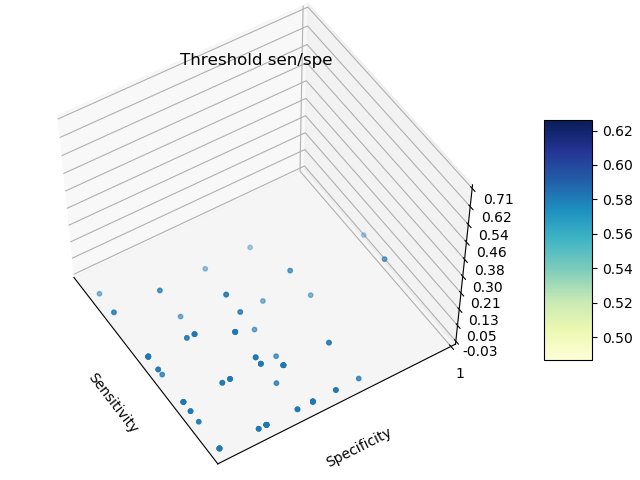

In [18]:
#plot 3D
%matplotlib notebook



X = data_frame_treated['N rule']
Y = data_frame_treated['N var per rule']
Z = data_frame_treated['f1']

y_axis_values = range(math.floor(min(Y)), math.ceil(max(Y))+1)
x_axis_values = range(math.floor(min(X)), math.ceil(max(X))+1)


fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X, Y, Z,  cmap=cm.YlGnBu, linewidth=0, antialiased=False)

#ax.set_zlim(-1.01, 1.01)
ax.set_xticks(x_axis_values, minor=False)
ax.set_yticks(y_axis_values, minor=False)

ax.set_xlabel('$Number of rules$')
ax.set_ylabel('$Number of var per rule$')


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))



fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('F1-Score')
plt.show()

<b style="background-color:red;color:white">Question 11</b> In your opinion, which values/ranges of both parameters: number of rules and vars per rule, should you choose to obtain the best models? (comment briefly on the plot and include it into to report)

Don't forget to change those values below!

### Additional refinement of the parameter search

Now that we observed the plot we can refine the search for parameter values. As for the previous experiment it is necessary to:
<ul>
    <li>define new values/ranges for the number of rules </li>
    <li>define new values/ranges number of variable per rule </li>
    <li>change the path name where you want to save the new models </li>
    <li>change the name of the file that will contain the number of experiments</li>
     
</ul>

In [20]:
#Var per rule and number of rules


#Change the path directory where you want to save the new results
#--------------------
#Path where you want to save yours models (you need to create the directory befor start the algorithm)
path_save_results_directory = 'experiences/n_rules_nvar_tuning/'
#file nam that will contain the results for each model create (so fo each fold)
file_results_dv = 'values_number_of_rules_nvar_tuning.csv'
#Name of the experience, this name will appear on the models files
experience_value_name = 'exps_lab_lfa_number_of_rules_var_tuning'
#--------------------


model_train_obj = ModelTrain(array_index_train_test = array_index_train_test,
                             X_train = X_train,
                             y_train = y_train, 
                             number_rule = 0, var_per_rule = 0, 
                             classifier_trefle = clf, 
                             path_save_results = path_save_results_directory,
                            path_save_results_values=file_results_dv,
                            experience_name = experience_value_name)


#Here we can choose wich values for the number of rules and maximum variable per 
#rule we want to test along our experience 
#('here you need to change and explain your choice, on the repport')
#--------------------
rules_number_vec = [4]
var_per_rule_vec = [2]
#--------------------

for variation_a in rules_number_vec:
    for variation_b in var_per_rule_vec:
        model_train_obj.number_rule = variation_a
        model_train_obj.var_per_rule = variation_b
        model_train_obj.execute_cv()

gen	species	std      	min     	avg     	max     	avg_hof 
1  	sp1    	0.0325536	0.468085	0.539948	0.618182	0.686739
1  	sp2    	0.2934   	0       	0.502425	0.782609	0.72433 
2  	sp1    	0.030189 	0.678571	0.711991	0.782609	0.753842
2  	sp2    	0.226511 	0       	0.598252	0.782609	0.760616
3  	sp1    	0.027924 	0.689655	0.71572 	0.782609	0.762612
3  	sp2    	0.274644 	0       	0.552597	0.782609	0.773803
4  	sp1    	0.0342951	0.689655	0.721727	0.782609	0.782609
4  	sp2    	0.264069 	0       	0.562266	0.782609	0.782609
5  	sp1    	0.0306274	0.689655	0.720229	0.782609	0.782609
5  	sp2    	0.257877 	0       	0.578277	0.8     	0.783333
6  	sp1    	0.0308119	0.666667	0.745283	0.818182	0.79361 
6  	sp2    	0.26277  	0       	0.551181	0.818182	0.79361 
7  	sp1    	0.0343065	0.690909	0.75464 	0.818182	0.806126
7  	sp2    	0.225981 	0       	0.604279	0.818182	0.806126
8  	sp1    	0.0416631	0.62963 	0.763786	0.818182	0.818182
8  	sp2    	0.254142 	0       	0.577489	0.818182	0.818182
9  	sp1    	0.

71 	sp1    	0.0480528	0.666667 	0.787336	0.844444	0.844444
71 	sp2    	0.243516 	0        	0.609842	0.844444	0.844444
72 	sp1    	0.0425531	0.701754 	0.794912	0.844444	0.844444
72 	sp2    	0.244281 	0        	0.638468	0.844444	0.844444
73 	sp1    	0.0467262	0.727273 	0.788373	0.844444	0.844444
73 	sp2    	0.254316 	0        	0.63856 	0.844444	0.844444
74 	sp1    	0.0442693	0.727273 	0.791532	0.844444	0.844444
74 	sp2    	0.203859 	0        	0.651704	0.844444	0.844444
75 	sp1    	0.0401552	0.727273 	0.791604	0.844444	0.844444
75 	sp2    	0.249337 	0        	0.618737	0.844444	0.844444
76 	sp1    	0.0395466	0.727273 	0.794063	0.844444	0.844444
76 	sp2    	0.25322  	0        	0.617739	0.844444	0.844444
77 	sp1    	0.0440978	0.7      	0.794641	0.844444	0.844444
77 	sp2    	0.238885 	0        	0.633236	0.844444	0.844444
78 	sp1    	0.0449149	0.727273 	0.789205	0.844444	0.844444
78 	sp2    	0.243742 	0        	0.634672	0.844444	0.844444
79 	sp1    	0.0406939	0.731707 	0.795089	0.844444	0.8444

40 	sp1    	0.0465005	0.611111 	0.777883 	0.809524	0.809524
40 	sp2    	0.215289 	0        	0.600484 	0.809524	0.809524
41 	sp1    	0.0432252	0.642857 	0.778565 	0.809524	0.809524
41 	sp2    	0.194392 	0        	0.621813 	0.809524	0.809524
42 	sp1    	0.0426543	0.666667 	0.780627 	0.809524	0.809524
42 	sp2    	0.178176 	0        	0.628554 	0.809524	0.809524
43 	sp1    	0.0439864	0.666667 	0.776809 	0.809524	0.809524
43 	sp2    	0.202767 	0        	0.61728  	0.809524	0.809524
44 	sp1    	0.0504795	0.666667 	0.769466 	0.809524	0.809524
44 	sp2    	0.256989 	0        	0.566389 	0.809524	0.809524
45 	sp1    	0.0788403	0.580645 	0.758124 	0.809524	0.809524
45 	sp2    	0.229176 	0        	0.584433 	0.809524	0.809524
46 	sp1    	0.0648859	0.580645 	0.772405 	0.809524	0.809524
46 	sp2    	0.213589 	0        	0.603977 	0.809524	0.809524
47 	sp1    	0.068441 	0.580645 	0.761671 	0.809524	0.809524
47 	sp2    	0.204135 	0        	0.60946  	0.809524	0.809524
48 	sp1    	0.0449798	0.678571 	0.777269

8  	sp1    	0.0165317 	0.641509	0.662919	0.693878	0.682479
8  	sp2    	0.222146  	0       	0.539525	0.693878	0.682479
9  	sp1    	0.0166116 	0.641509	0.671038	0.7     	0.690884
9  	sp2    	0.221798  	0       	0.522027	0.7     	0.691682
10 	sp1    	0.0202457 	0.641509	0.664594	0.7     	0.696739
10 	sp2    	0.166577  	0       	0.568814	0.7     	0.69692 
11 	sp1    	0.0216966 	0.62963 	0.664426	0.7     	0.697464
11 	sp2    	0.199866  	0       	0.542317	0.7     	0.697645
12 	sp1    	0.0145797 	0.653061	0.676408	0.7     	0.699094
12 	sp2    	0.220496  	0       	0.530485	0.7     	0.699275
13 	sp1    	0.0261098 	0.627451	0.663807	0.7     	0.7     
13 	sp2    	0.243389  	0       	0.498589	0.7     	0.7     
14 	sp1    	0.0251948 	0.627451	0.66721 	0.7     	0.7     
14 	sp2    	0.182247  	0       	0.566935	0.7     	0.7     
15 	sp1    	0.025541  	0.627451	0.668541	0.7     	0.7     
15 	sp2    	0.143731  	0       	0.590219	0.711111	0.700463
16 	sp1    	0.0128481 	0.653846	0.693403	0.723404	0.7065

77 	sp2    	0.285509  	0       	0.549134	0.894737	0.894737
78 	sp1    	0.0565344 	0.6875  	0.822065	0.894737	0.894737
78 	sp2    	0.222067  	0       	0.615688	0.894737	0.894737
79 	sp1    	0.053115  	0.666667	0.823294	0.894737	0.894737
79 	sp2    	0.27765   	0       	0.561746	0.894737	0.894737
80 	sp1    	0.0692688 	0.645161	0.816195	0.894737	0.894737
80 	sp2    	0.222902  	0       	0.598139	0.894737	0.894737
81 	sp1    	0.0612404 	0.641509	0.820828	0.894737	0.894737
81 	sp2    	0.284996  	0       	0.529427	0.894737	0.894737
82 	sp1    	0.0531417 	0.693878	0.824075	0.894737	0.894737
82 	sp2    	0.223844  	0       	0.619436	0.894737	0.894737
83 	sp1    	0.054391  	0.6875  	0.819828	0.894737	0.894737
83 	sp2    	0.242565  	0       	0.608008	0.894737	0.894737
84 	sp1    	0.0595263 	0.666667	0.831905	0.894737	0.894737
84 	sp2    	0.227653  	0       	0.626988	0.894737	0.894737
85 	sp1    	0.0616718 	0.625   	0.829074	0.894737	0.894737
85 	sp2    	0.242947  	0       	0.599308	0.894737	0.8947

46 	sp1    	0.0242262  	0.734694	0.779333	0.808511	0.808511
46 	sp2    	0.264312   	0       	0.583727	0.808511	0.808511
47 	sp1    	0.0229302  	0.727273	0.777929	0.808511	0.808511
47 	sp2    	0.24849    	0       	0.609083	0.808511	0.808511
48 	sp1    	0.0245792  	0.72    	0.773942	0.808511	0.808511
48 	sp2    	0.268697   	0       	0.591607	0.808511	0.808511
49 	sp1    	0.0261372  	0.72    	0.774049	0.808511	0.808511
49 	sp2    	0.25705    	0       	0.587411	0.808511	0.808511
50 	sp1    	0.0266685  	0.72    	0.774867	0.808511	0.808511
50 	sp2    	0.257035   	0       	0.58828 	0.808511	0.808511
51 	sp1    	0.0264027  	0.705882	0.773519	0.808511	0.808511
51 	sp2    	0.292211   	0       	0.561026	0.808511	0.808511
52 	sp1    	0.0226566  	0.730769	0.779714	0.808511	0.808511
52 	sp2    	0.276533   	0       	0.560016	0.808511	0.808511
53 	sp1    	0.0265163  	0.705882	0.777223	0.808511	0.808511
53 	sp2    	0.264502   	0       	0.576105	0.808511	0.808511
54 	sp1    	0.024605   	0.705882	0.77845

14 	sp1    	0.0259163  	0.690909	0.729368	0.77551 	0.77019 
14 	sp2    	0.265381   	0       	0.534592	0.77551 	0.770823
15 	sp1    	0.0176367  	0.716981	0.755942	0.77551 	0.77551 
15 	sp2    	0.264369   	0       	0.547701	0.77551 	0.77551 
16 	sp1    	0.018543   	0.716981	0.757864	0.77551 	0.77551 
16 	sp2    	0.23852    	0       	0.586103	0.826087	0.777618
17 	sp1    	0.0340208  	0.703704	0.76647 	0.826087	0.809759
17 	sp2    	0.266508   	0       	0.536605	0.826087	0.809759
18 	sp1    	0.0309154  	0.740741	0.773612	0.826087	0.816566
18 	sp2    	0.274577   	0       	0.533788	0.826087	0.816566
19 	sp1    	0.0267235  	0.716981	0.779358	0.826087	0.818763
19 	sp2    	0.263744   	0       	0.564644	0.826087	0.818763
20 	sp1    	0.0262399  	0.730769	0.780042	0.826087	0.820961
20 	sp2    	0.251373   	0       	0.566047	0.826087	0.820961
21 	sp1    	0.0278611  	0.716981	0.779145	0.826087	0.824622
21 	sp2    	0.239944   	0       	0.58477 	0.826087	0.824622
22 	sp1    	0.0318203  	0.697674	0.77568

82 	sp2    	0.267711   	0       	0.602017	0.869565	0.860315
83 	sp1    	0.0372384  	0.744186	0.816218	0.869565	0.862627
83 	sp2    	0.272999   	0       	0.599392	0.869565	0.862627
84 	sp1    	0.0368313  	0.73913 	0.819816	0.869565	0.865711
84 	sp2    	0.272813   	0       	0.576538	0.869565	0.865711
85 	sp1    	0.040072   	0.727273	0.814367	0.869565	0.868794
85 	sp2    	0.268243   	0       	0.588235	0.869565	0.868794
86 	sp1    	0.0422065  	0.727273	0.815401	0.869565	0.869565
86 	sp2    	0.296123   	0       	0.544862	0.869565	0.869565
87 	sp1    	0.0430276  	0.73913 	0.818706	0.869565	0.869565
87 	sp2    	0.288735   	0       	0.576687	0.869565	0.869565
88 	sp1    	0.0395929  	0.727273	0.820519	0.869565	0.869565
88 	sp2    	0.295361   	0       	0.562763	0.869565	0.869565
89 	sp1    	0.0360106  	0.727273	0.823513	0.869565	0.869565
89 	sp2    	0.285846   	0       	0.573571	0.869565	0.869565
90 	sp1    	0.0399223  	0.727273	0.82773 	0.869565	0.869565
90 	sp2    	0.290694   	0       	0.56046

### Consolidating the results
Now, put all yours models in the same directory (copy/past) and add all the csv results to the dataframe in order to analyse the results

In [25]:
#Filter sen/spe
#read all csv
dataframe_results = pd.read_csv('values_number_of_rules.csv')
dataframe_results_b = pd.read_csv('values_number_of_rules_nvar.csv')
dataframe_results_c = pd.read_csv('values_number_of_rules_nvar_tuning.csv')
#dataframe_results_d = pd.read_csv('values_rmse_weight_v2.csv')
#dataframe_results_e = pd.read_csv('values_sen_spe_weight.csv')

dataframe_results_all = dataframe_results_b.append(dataframe_results)
dataframe_results_all = dataframe_results_all.append(dataframe_results_c)
#dataframe_results_all = dataframe_results_all.append(dataframe_results_d)
#dataframe_results_all = dataframe_results_all.append(dataframe_results_e)

#dataframe_results_c = pd.read_csv('values_w.csv')
dataframe_results_all.columns = ['N rule', 'N var per rule','weight','CV number', 'tn', 'fp', 'fn', 'tp', 'file_name']
dataframe_results_all = dataframe_results_all.reset_index(drop=True)
display(dataframe_results_all)

,N rule,N var per rule,weight,CV number,tn,fp,fn,tp,file_name
0,4.0,1.0,1.0,0.0,2.0,4.0,1.0,3.0,exps_lab_lfa_number_of_rules_var_weigh_actual_...
1,4.0,1.0,1.0,1.0,2.0,3.0,0.0,5.0,exps_lab_lfa_number_of_rules_var_weigh_actual_...
2,4.0,1.0,1.0,2.0,1.0,2.0,3.0,4.0,exps_lab_lfa_number_of_rules_var_weigh_actual_...
3,4.0,1.0,1.0,3.0,0.0,5.0,2.0,2.0,exps_lab_lfa_number_of_rules_var_weigh_actual_...
4,4.0,1.0,1.0,4.0,1.0,4.0,0.0,4.0,exps_lab_lfa_number_of_rules_var_weigh_actual_...
...,...,...,...,...,...,...,...,...,...
95,4.0,2.0,1.0,0.0,2.0,4.0,1.0,3.0,exps_lab_lfa_number_of_rules_var_tuning_weigh_...
96,4.0,2.0,1.0,1.0,2.0,3.0,1.0,4.0,exps_lab_lfa_number_of_rules_var_tuning_weigh_...
97,4.0,2.0,1.0,2.0,1.0,2.0,3.0,4.0,exps_lab_lfa_number_of_rules_var_tuning_weigh_...
98,4.0,2.0,1.0,3.0,1.0,4.0,1.0,3.0,exps_lab_lfa_number_of_rules_var_tuning_weigh_...


# 2 Model selection

Once we have tested all the configurations, we have obtained a **large** number of models exhibiting diverse performance figures. At the end of a modeling process, the goal is to obtain one, or a few, models that would be deployed and used for new predictions. A selection process is thus necessary.

A first selection is performed by applying a filter based on the diagnostic performance, thus reducing the number of models. Below you can see a scatter plot of all the models you obtained according to their sensitivity and specificity (as obtained on the validation subsets).

In [26]:
#Plot sent spe all

#Plot all values
#don't forget to turn off the others plotss
vec_values_sen_spe_models = libraries.interpretability_methods.getSenSpeValuesByScores(dataframe_results_all)
#vec_values_sen_spe_models = libraries.interpretability_methods.getSenSpeValuesByScores(data_frame_treated)

plt.scatter(vec_values_sen_spe_models['Sensitivity'],vec_values_sen_spe_models['Specificity'],s=10, marker='o')

plt.title('Threshold sen/spe')
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')
plt.savefig('ScatterPlot.png')

plt.xlim(0,1)
plt.ylim(0,1)

plt.show()
print('You have {0} models'.format(len(vec_values_sen_spe_models)))


You have 100 models


## First selection filter: based on sen/spe

Having analysed the above performance overview of your models, you can apply a filter based on  sensitivity and specificity. In this way, only those models exhibiting better performance than some specified threshold will be selected for the next step.
The plot below shows the effect of the combined thresholds on the number of models remaining after the filter is applied.

<IPython.core.display.Javascript object>


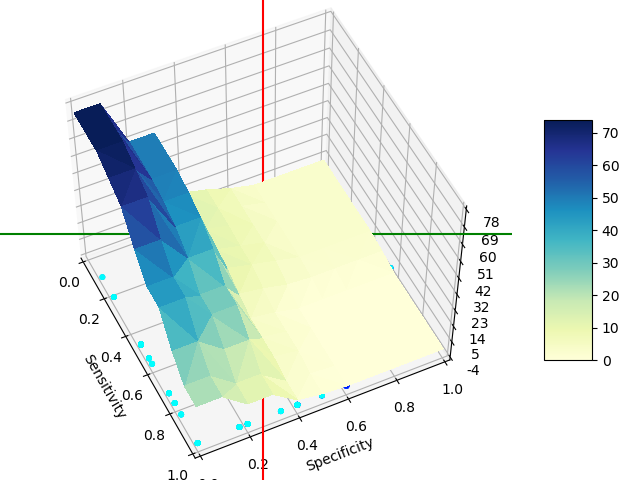

In [27]:
#Plot sen_spe  qty models 3D
#that save x models
%matplotlib notebook

results_qty_models = libraries.interpretability_methods.plotSenSpeQtyModelsByThreshold(vec_values_sen_spe_models)

#display(results_qty_models)

X = results_qty_models['sensitivity']
Y = results_qty_models['specificity']
Z = results_qty_models['qty_models']

#y_axis_values = range(math.floor(min(Y)), math.ceil(max(Y))+1)
#x_axis_values = range(math.floor(min(X)), math.ceil(max(X))+1)

max_quantity = results_qty_models.loc[results_qty_models['qty_models'].idxmax()]
max_quantity = int(max_quantity['qty_models'])

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X, Y, Z.values,  cmap=cm.YlGnBu, linewidth=0, antialiased=False)

#ax.set_zlim(0, max_quantity)
ax.set_zticks(Z)
#ax.set_xticks(x_axis_values, minor=False)
#ax.set_yticks(y_axis_values, minor=False)

ax.set_xlabel('$Sensitivity$')
ax.set_ylabel('$Specificity$')



ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))



fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Sen/Spe threshold')
plt.show()

On the base of this plot, you should decide on threshold values for both, specificity and sensitivity and apply them. The resulting subset of selected models is shown in the scatterplot below.

In [39]:
#select values sen spe filtre
%load_ext autoreload
%autoreload
#Put a limit in sen/spe
#Here you put the threshold for the sensitivity and specificity
#Don't forget to shave the plot and comment into your repport
#--------------------
value_sensitivity = 0.6
value_specificity = 0.6
#--------------------


#We apply them

vec_values_sen_spe_models_filtered = libraries.interpretability_methods.filterDataframeBySenSpeLimit(value_sensitivity, value_specificity, vec_values_sen_spe_models)
vec_values_sen_spe_models_filtered_invert = libraries.interpretability_methods.filterDataframeBySenSpeLimitContrary(value_sensitivity, value_specificity, vec_values_sen_spe_models)


figure = libraries.interpretability_plots.plotDataFrameValuesFiltered(value_sensitivity, value_specificity,vec_values_sen_spe_models_filtered, vec_values_sen_spe_models_filtered_invert)


print('You have {0} models'.format(len(vec_values_sen_spe_models_filtered)))
for index, row in vec_values_sen_spe_models_filtered.iterrows():
    print(index)
    print(row)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'null' is not defined

<b style="background-color:red;color:white">Question 12</b>: Explain your choice of the threshold values for the sensitivity and specificity. (Save both plots into your reports)

<b>Save the plot on the repport</b>

## Second selection: frequency-based filter

Next, a second model-selection filter is applied based on the "importance" of the features. Such feature importance is represented in this context by their relative presence (i.e. their frequency) among the models. 

#### Frequency of the variables
The figure below shows the frequency of the variables among all the remaining models.

In [42]:
%load_ext autoreload
%autoreload
  
    
#--------------------
list_models_path_complete = ["experiences/all_models/exps_lab_lfa_number_of_rules_var_tuning_weigh_actual_1.0_conf_A_CV_3_rule_4_var_per_rule_2.ftt"]

#--------------------
    
#Perform the counting
list_models_vars = libraries.interpretability_methods.transformModelsToModelVarObj(list_models_path_complete)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You have 1 models and 4 variables


<IPython.core.display.Javascript object>


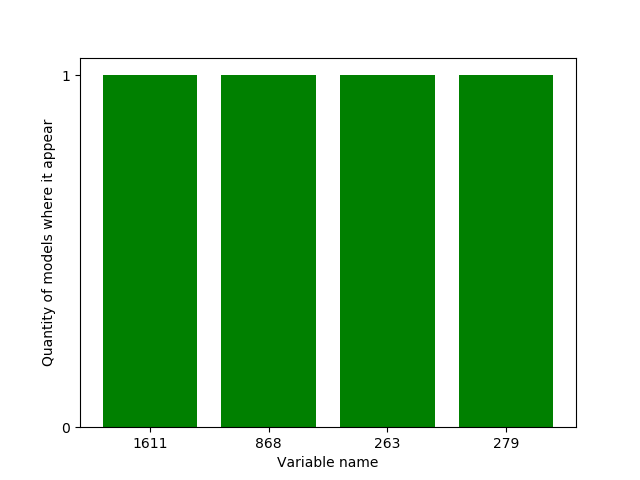

In [43]:
#plot histogram before cut

dict_values_resultant = libraries.interpretability_methods.countVarFreq(list_models_vars)




#indication of the number of models and variables
qty_models = len(list_models_vars)
qty_variables = len(dict_values_resultant)
print("You have {0} models and {1} variables".format(qty_models, qty_variables))

#Plot the new histogram
libraries.interpretability_plots.plotHistogramFreqVar(dict_values_resultant)


#### Choosing a frequency threshold
Filtering features by frequency will result in a reduction of both the number of features and the number of models, as models with eliminated variables are also eliminated. 

The plot below represents the number of models and variables that should remain after the filter is applied in function of the frequency threshold. It helps you to decide on which threshold to use for the filter.

(Note that the frequency of a feature is calculated as the number of <b>different models</b> where it appears irrespective of the number of rules containing it.)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


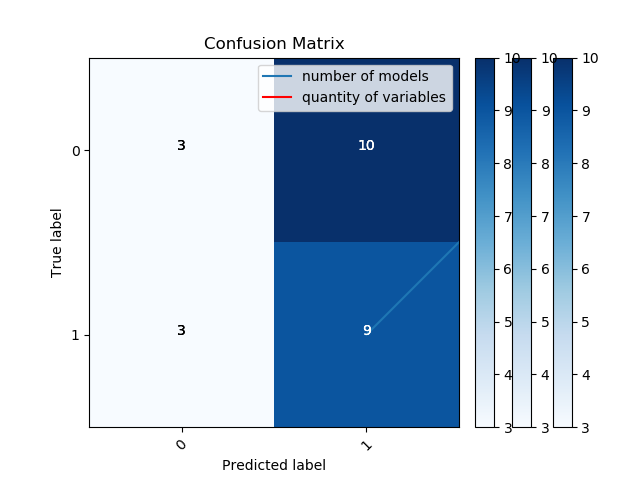

In [46]:
%load_ext autoreload
%autoreload
#Perform the counting
list_models_vars = libraries.interpretability_methods.transformModelsToModelVarObj(list_models_path_complete)
dict_values = libraries.interpretability_methods.countVarFreq(list_models_vars)


#TEST zone
matrix_results = libraries.interpretability_methods.createPlotQtyVarPerModelByMinimumFreq(dict_values,list_models_vars)
#display(matrix_results)
#End test zone



ax = plt.figure().gca()

matrix_results.plot(kind='line',x='min freq var',y='number of models',ax=ax)
matrix_results.plot(kind='line',x='min freq var',y='quantity of variables', color='red', ax=ax)

plt.show()

#libraries.interpretability_plots.plotFreqVarPerFreqMinimum(matrix_results)

based on the plot above, select the minimum frequency (threshold) for the variables on your models.

<b style="background-color:red;color:white">Question 13</b>: Explain your choice of the threshold. (Save both plots into your report)

You need to indicate the name of the file where you want to save the models

You have 1 models and 4 variables


<IPython.core.display.Javascript object>


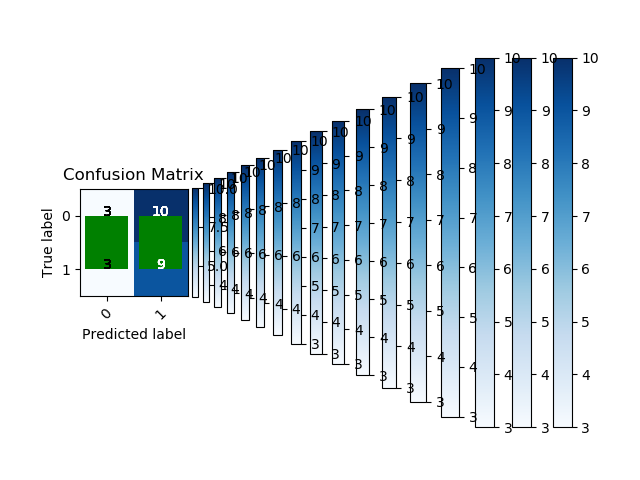

,Variable name,Frequence
0,1611,1
1,868,1
2,263,1
3,279,1


In [57]:
#valide the frequence value

#Create a copy of the list that contains the model_var objects
list_models_vars_cpopy = list_models_vars.copy()
#select the minimum frequenty
#-------------------
nb_min_var = 1
#--------------------

#Perform the frequence
list_model_var_resultant = libraries.interpretability_methods.reduceQtyVars(nb_min_var, dict_values,list_models_vars_cpopy)
dict_values_resultant = libraries.interpretability_methods.countVarFreq(list_model_var_resultant)




#indication of the number of models and variables
qty_models = len(list_model_var_resultant)
qty_variables = len(dict_values_resultant)
print("You have {0} models and {1} variables".format(qty_models, qty_variables))

#Plot the new histogram
libraries.interpretability_plots.plotHistogramFreqVar(dict_values_resultant)
#Show the frequency table
dict_Values_ordered = libraries.interpretability_methods.sort_reverse_dictionary_by_values(dict_values_resultant)
datafram_var_freq = pd.DataFrame(list(dict_Values_ordered.items()),columns=['Variable name','Frequence'])
display(datafram_var_freq)


#Perform the list of the models
#--------------------
file_name = 'models_selected.csv'
#--------------------
list_models_names=[model_var.model_path for model_var in list_model_var_resultant]
dataframe_names_files = pd.DataFrame(list_models_names)
dataframe_names_files.to_csv(file_name, sep=',', encoding='utf-8')

Carlos: Don't forget to save the plot resultant of your choice...
<br>
<b>The objective of the lab is to arrived at the end with 5-10 models

# 3. Analysis of the selected models

Now that you have selected the best models, they are saved on the file "models_selected.CSV" (Or other file if you change the name...)
You may then load these models and use them to compute their predictions for the observations in the test set.

In [80]:
%reload_ext autoreload
%autoreload

# Import from file
#--------------------
fis = TrefleFIS.from_tff_file("experiences/all_models/exps_lab_lfa_number_of_rules_var_tuning_weigh_actual_1.0_conf_A_CV_3_rule_4_var_per_rule_2.ftt")
#--------------------
# In the future, it could possible to call clf.predict_classes() directly
# see issue #1
y_pred_test = fis.predict(X_test)

results_list_predictions = np.squeeze(np.asarray(y_pred_test))


#libraries.results_plot.plotCMByTreflePredictions(y_test, results_list_predictions)
#Convert your results into binary values
results = []
for element in y_pred_test:
    print(element)
    if element > 0.5:
        results.append(1)
    else:
        results.append(0)
print(results)
from libraries.ConfusionMatrix import ConfusionMatrix
cm = confusion_matrix(y_test, results)
print(range(n_classes))
print(cm)
n_classes = len(np.unique(y))
ConfusionMatrix.plot(cm, classes=range(n_classes), title="Confusion Matrix")
print(disp)

[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[0.5]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]
range(0, 2)
[[ 3 10]
 [ 3  9]]
None


The code above is only an example of how to load models and test their performance in the test set. (Remember that the test set is the one who has not been used during the previous training/selectionn steps.)

<b><span style="background-color:red;color:white">Question 14</span></b>: Among the final models, select three of them as follows: the smallest one (in terms of rules and variables), the best one (in terms of performance), and one in the "middle" that you consider as being a good trade-off between size and performance. With them:
<ul>
    <li>Apply them to the test set and analyze the results you obtained</li>
    <li>Analyze them in terms of size, rules, vars per rules and other characteristics that you think are relevant</li>
    <li>As far as possible, analyze their rules and try to "explain" their predictions.
</ul>
<br>
Tips: You can use plots to described your results...